In [419]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os,sys
import urllib.request
from scipy import interpolate
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
import csv
import yaml
import pickle as pk
from matplotlib.ticker import Locator
%matplotlib inline




In [420]:
class MinorSymLogLocator(Locator):
    #Curtosy of https://stackoverflow.com/questions/20470892/how-to-place-minor-ticks-on-symlog-scale
    
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in xrange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))


In [438]:
def s18dStack(ras, decs, data, width = 20., weight = False, normalize = False):
        stack = 0
        divisor = 0
        num = 0
        
        rms = fits.open('/scratch/r/rbond/jorlo/S18d_202006/selFn/RMSMap_Arnaud_M2e14_z0p4.fits')
        
        tileNames = []
        rms_names = []
        for i in range(len(ras)):
            tileNames.append(str(tileFinder(ras[i], decs[i],s18d)))
        for i in range(1,281):
            rms_names.append(str(rms[i].header['EXTNAME']))
            
        tileIndex = []
        for i in range(len(tileNames)):
            if tileNames[i] is None:
                tileIndex.append(None)
            else:
                tileIndex.append(np.where(np.array(rms_names) == str(tileNames[i]))[0][0])
        for i in range(len(ras)):
                path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'
                tileName = tileNames[i]
                
                if tileName is None: continue
                    
                tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
                stamp = reproject.postage_stamp(tile, ras[i], decs[i], width, 0.5)
                if normalize:
                    stamp[0] = stamp[0]/np.amax(stamp[0])
                if weight:
                    
                    index = tileIndex[i]
                    
                    rmsmap = rms[index].data
                    #print(ras[i], decs[i])

                    coords = np.deg2rad(np.array((decs[i],ras[i])))
                    ypix,xpix = enmap.sky2pix(tile.shape,tile.wcs,coords)

                    weight = rmsmap[int(ypix),int(xpix)]**2
                    #print(rmsmap[int(ypix),int(xpix)])
                    
                    if weight < 10**-20:
                        #print(i)
                        continue
                    
                    try: 
                        stack += stamp[0]/weight
                    except:
                        print(tileName)
                        print(tile)
                        print(stamp)
                    num += 1
                    divisor += 1/weight

                else:
                    try: 
                        stack += stamp[0]
                    except:
                        print(tileName)
                        print(tile)
                        print(stamp)

                    divisor += 1
                    num += 1

        
        try:
            stack /= divisor
        except: 
            print("Error: no items in stack")
            return None, None
        print("Number in stack: {}".format(num))
        return stack, num

In [57]:
def s18dStacker(catalog, r_low, r_high, data, remove_act = True):
    ra = catalog[1].data['RADeg']
    dec = catalog[1].data['decDeg']
    ra, dec = np.array(ra), np.array(dec)
    rich = catalog[1].data['Rich']

    act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches.fits')
    in_act = act[1].data['MADCOWSUnion_name']
    
    names = catalog[1].data['name']
    if remove_act:
        flags = [True]*len(ra)

        for i, name in enumerate(names):
            if name in in_act:
                flags[i] = False

        print("Number before confirmed removal: {}".format(len(ra)))
        ra = ra[flags]
        dec = dec[flags]
        rich = rich[flags]
        print("Number after confirmed removal: {}".format(len(ra)))

    print("Number above cut: {}".format(len(ra)))    
        
    cut = np.where((r_low<np.array(rich)) & (np.array(rich)<=r_high))[0]
    
    cut_ra, cut_dec = ra[cut], dec[cut]
    
    stack, num = s18dStack(cut_ra, cut_dec, data)
    print(num)
    
    if type(stack) == type(None):
        print("Error: No objects in stack")
        return None, None
    out, cen, cen_d, out_d = 0,0,0,0

    for i in range(len(stack[0])):
        for j in range(len(stack[0])):
            if (18<i<22) & (18<j<22):
                cen += stack[i][j]
                cen_d += 1
            else:
                out += stack[i][j]
                out_d += 1

    plot = plt.imshow(stack, extent = [-20,20,-20,20])
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.colorbar(plot, format='%.0e')
    plt.title("ACT S18 dStack on MaDCoWS w/ {}=>Richness>{}\n Total in stack: {}".format(r_high, r_low, num))
    plt.savefig("./plots/mdcw_cut_rich_{}_{}_stack_s18d_y.png".format(r_low,r_high))
    plt.show()
    plt.close()
    
    enmap.write_map('./stacks/mdcw_cut_rich_{}_{}_stack_s18d_y.fits'.format(r_low,r_high), stack)
    
    return cen/cen_d, out/out_d

In [58]:
with open('/scratch/r/rbond/jorlo/S18d_202006/selFn/tileDefinitions.yml') as f:
    
    s18d = yaml.load(f)
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
def tileFinder(ra, dec, data):
    #Given an RA and Dec in deg, find the S18d tile containing that RA and Dec
    for i, tile in enumerate(data):
        box = tile['RADecSection']
        if box[0] >= box[1]:
            if (360 >= ra >= box[0] or 0 <= ra <box[1]) and box[2]<=dec<= box[3]:
                return tile['tileName']
        if box[0]<=ra<=box[1] and box[2]<=dec<= box[3]:
            return tile['tileName']
    return None

        

In [60]:
def s18dStamp(ra, dec, data, name, width = 0.5, write = True):
    #Find tile corresponding to RA, Dec
    path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'
    tileName = tileFinder(ra, dec, data)
    if tileName == None: return None
    tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
    
    
    stamp = reproject.postage_stamp(tile, ra, dec, width*60, 0.5)
    if write:
        #tempdec, tempra = np.deg2rad([dec, ra])
        #tempwid = np.deg2rad(width)
        #box = [[tempdec-tempwid,tempra-tempwid],[tempdec+tempwid,tempra+tempwid]]
 
        #stampgeo = tile.submap(box)
        
        #box = np.array([[ra-width/2,dec-width/2],[ra+width/2,dec+width/2]]) * utils.degree
        #shape, wcs = enmap.geometry(pos=box,res=0.5 * utils.arcmin,proj='car')
        #print(shape)
        #print(stampgeo.wcs)
        #print(stamp.wcs)
        #stamp.wcs = wcs
        #print(stamp.wcs)
        #print(stamp[0].shape)
        #plt.imshow(stamp[0])
        #plt.show()
        #Return map
        stamp.wcs.wcs.crval = [ra,dec]
        #plot = enplot.plot(stamp,mask=0)
        #enplot.show(plot)
        enmap.write_map('./for_tony/{}.fits'.format(name), stamp)
    return stamp


In [61]:
def getFlags(ra, dec, data):
    #Returns indeces of ra, dec that are inside a certain data 
    flags = []
    for i in range(len(ra)):
        if tileFinder(ra[i], dec[i], data) != None:
            flags.append(i)
    return flags

In [62]:
def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

In [63]:
def binmap(map2d, x, y, rbin):

    '''Bin a 2d map into a 1d symmteric radial profile (i.e. for B_l or radial profile)'''
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2+Y**2)
    d = np.digitize(R.flatten(), rbin)
    rbin1d = np.zeros(len(rbin))
    bin1d = np.zeros(len(rbin))
    binvar = np.zeros(len(rbin))
    binerr = np.zeros(len(rbin))
    for i in range (len(rbin)):
        rbin1d[i] = np.mean(R.flatten()[d==i+1])
        bin1d[i] = np.mean(map2d.flatten()[d==i+1])
        binvar[i] = np.var(map2d.flatten()[d==i+1])
        binerr[i] = np.sqrt(np.var(map2d.flatten()[d==i]) / len(map2d.flatten()[d==i+1]))
    return  rbin1d, bin1d, binvar, binerr

In [267]:
def offsetSim(ras, decs, name = None, num = 50, width = 25.0, normalize = False, testrun = False):
    bootstraps = {'scatter_rs':[], 'scatter_bin_data':[]}

    xspline = np.linspace(-10, 10, 40)
    yspline = xspline
    rbin = np.linspace(0, np.sqrt(2)*max(xspline), 20)
    
    for j in range(num):
        if testrun:
            catalog = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches_V03.fits')

            ras_temp = catalog[1].data['MaDCoWS RA(deg)']
            decs_temp = catalog[1].data['MaDCoWS Dec(deg)']
            ras_temp, decs_temp = np.array(ra_mdcw), np.array(dec_mdcw)
            
            ra_offsets = ras_temp - ras
            dec_offsets = decs_temp - decs
            #for i in range(len(ras_temp)):
            #    print((ra_act[i]-ra_mdcw[i])*3600, (dec_act[i]-dec_mdcw[i])*3600)
            ras_temp = ras + ra_offsets
            decs_temp = decs + dec_offsets
        
        else:    
            ras_temp = ras + width/3600*np.random.normal(size = len(ras))
            decs_temp = decs + width/3600*np.random.normal(size = len(decs))
        """
        for i in range(len(ras_temp)):
            ras_temp[i] = ras_temp[i] + np.random.normal(scale = np.sqrt(width)/3600)
            decs_temp[i] = decs_temp[i] + np.random.normal(scale = np.sqrt(width)/3600)
        """
        stack_act, stack_num_act = s18dStack(ras_temp, decs_temp, s18d, weight = True, normalize = normalize)
        scatter_r_jk, scatter_bin_data_jk, c, d = binmap(stack_act,xspline,yspline,rbin)

        bootstraps['scatter_rs'].append(scatter_r_jk)
        bootstraps['scatter_bin_data'].append(scatter_bin_data_jk)
        print(j)
        
        if name is not None:
            pk.dump(bootstraps, open(name, "wb" ))
    return bootstraps

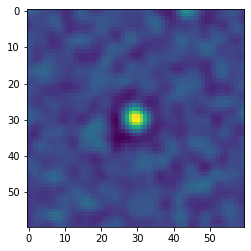

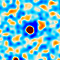

29.5,29.5


In [103]:
ra, dec = 5.55130626, -0.6048555
name = 'ACT-CL J0022.2-0036'
test= s18dStamp(ra, dec, s18d, name.replace(' ', '_'))#, write = True)

#test = enmap.read_map('./for_tony/150_ACT-CL_J2012.4-5649.fits')

plt.imshow(test[0])
plt.show()

plot = enplot.plot(test,mask=0)
enplot.show(plot)

coords = np.deg2rad(np.array((dec,ra)))
xpix,ypix = enmap.sky2pix(test.shape,test.wcs,coords)
print('{},{}'.format(xpix,ypix))

# Stacking all MDCW clusters less ACT Clusters

Number before confirmed removal: 2839
Number after confirmed removal: 2746
Number in ACT footprint: 1479
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 1479


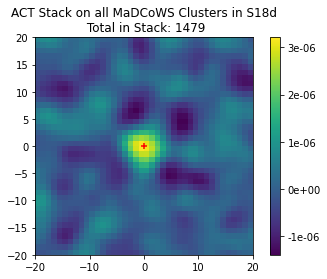

In [451]:
#Try stacking MDCW clusters on S18d
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')
#catalog = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches_V03.fits')

mdcw_ra = mdcw_catalog[1].data['RADeg']
mdcw_dec = mdcw_catalog[1].data['decDeg']
mdcw_ra, mdcw_dec = np.array(mdcw_ra), np.array(mdcw_dec)
mdcw_rich = mdcw_catalog[1].data['Rich']

act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches.fits')
in_act = act[1].data['MaDCoWs Name']


names = mdcw_catalog[1].data['name']

flags = [True]*len(mdcw_ra)

for i, name in enumerate(names):
    #print(name)
    if name in in_act:
        #print(i)
        flags[i] = False

print("Number before confirmed removal: {}".format(len(mdcw_ra)))
mdcw_ra = mdcw_ra[flags]
mdcw_dec = mdcw_dec[flags]
mdcw_rich = mdcw_rich[flags]
print("Number after confirmed removal: {}".format(len(mdcw_ra)))

flags = [False]*len(mdcw_ra)

for i in range(len(mdcw_ra)):
    if tileFinder(mdcw_ra[i], mdcw_dec[i], s18d) is None:
        continue
    flags[i] = True

mdcw_ra = mdcw_ra[flags]
mdcw_dec = mdcw_dec[flags]
mdcw_rich = mdcw_rich[flags]
print("Number in ACT footprint: {}".format(len(mdcw_ra)))


s18d_stack, stack_num = s18dStack(mdcw_ra, mdcw_dec, s18d)
"""
out, cen, cen_d, out_d = 0,0,0,0

for i in range(len(s18d_stack[0])):
    for j in range(len(s18d_stack[0])):
        if (18<i<22) & (18<j<22):
            cen += s18d_stack[i][j]
            cen_d += 1
        else:
            out += s18d_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)
"""

plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("ACT Stack on all MaDCoWS Clusters in S18d\n Total in Stack: {}".format(stack_num))
plt.savefig("./plots/mdcw_stack_s18d_y.png")
plt.show()
plt.close()

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


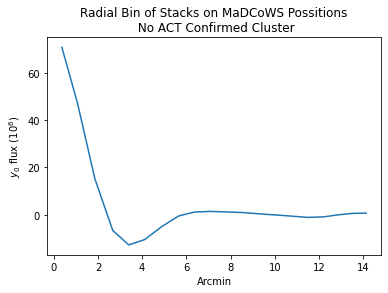

In [205]:
xspline = np.linspace(-10, 10, 40)
yspline = xspline

rbin = np.linspace(0, np.sqrt(2)*max(xspline), 20)


r, bin_data, c, d = binmap(s18d_stack,xspline,yspline,rbin)

plt.plot(r, bin_data*10**6)
plt.title('Radial Bin of Stacks on MaDCoWS Possitions\n No ACT Confirmed Cluster')
plt.xlabel('Arcmin')
plt.ylabel('$y_0$ flux ($10^6$)')
plt.savefig('mdcws_radial_bin.pdf')
plt.show()

# Stacking in bins of 10 richness, ACT clusters removed

Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 28
28


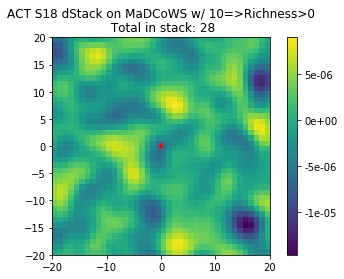

For richness bin 0 to 10 cen/cen_d = 7.965433740571284e-07, out/out_d = -1.0124021479041478e-07, s/n = -7.86785543379293
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 176
176


For richness bin 10 to 20 cen/cen_d = -1.0991249271842603e-06, out/out_d = -8.502609605815506e-09, s/n = 129.26912773138434
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in sta

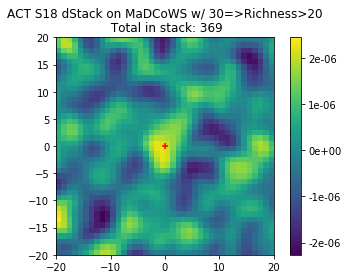

For richness bin 20 to 30 cen/cen_d = -2.144008325748536e-08, out/out_d = 1.3150340209526033e-08, s/n = -1.630382401966626
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 219
219


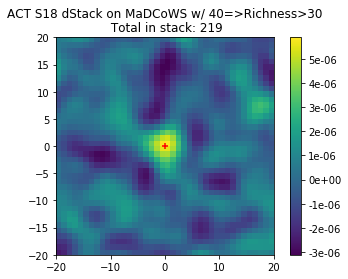

For richness bin 30 to 40 cen/cen_d = 7.248352135427849e-07, out/out_d = -4.008209405900902e-08, s/n = -18.083766094547848
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 72
72


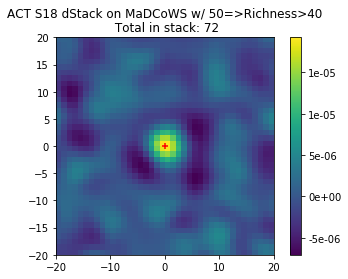

For richness bin 40 to 50 cen/cen_d = 7.991409380250025e-07, out/out_d = -1.0674496822081851e-07, s/n = -7.48645066221628
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 25
25


For richness bin 50 to 60 cen/cen_d = -3.7468555010360293e-06, out/out_d = 5.121059504469371e-08, s/n = -73.16563101377724
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 5
5


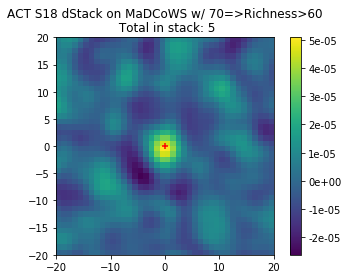

For richness bin 60 to 70 cen/cen_d = 3.235248755079596e-06, out/out_d = -1.7371014596297377e-07, s/n = -18.6244087076479
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Error: no items in stack
None
Error: No objects in stack
For  richness bin 70 to 80, no items in stack
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Error: no items in stack
None
Error: No objects in stack
For  richness bin 80 to 90, no items in stack
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Error: no items in stack
None
Error: No objects in stack
For  richness bin 90 to 100, no items in stack


In [124]:
for i in range(0, 100, 10):
    a,b = s18dStacker(mdcw_catalog, i, i+10, s18d)
    if a == None:
        print("For  richness bin {} to {}, no items in stack".format(i, i+10))
        continue
    print("For richness bin {} to {} cen/cen_d = {}, out/out_d = {}, s/n = {}".format(i, i+10, a, b, a/b))



# Individual plots of clusters not in ACT with Richness > 60

Number before confirmed removal: 2839
Number after confirmed removal: 2746
Number above cut: 2746


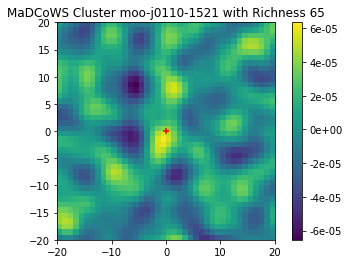

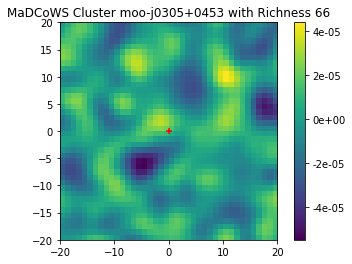

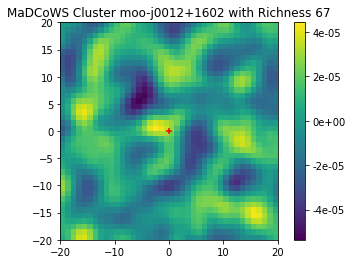

In [166]:
ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches.fits')
in_act = act[1].data['MaDCoWs Name']

names = mdcw_catalog[1].data['name']
flags = [True]*len(ra)

for i, name in enumerate(names):
    if name in in_act:
        flags[i] = False

print("Number before confirmed removal: {}".format(len(ra)))
ra = ra[flags]
dec = dec[flags]
rich = rich[flags]
names = names[flags]
print("Number after confirmed removal: {}".format(len(ra)))

print("Number above cut: {}".format(len(ra)))    

cut = np.where((60<np.array(rich)) & (np.array(rich)<1000))[0]
cut_ra, cut_dec, cut_names, cut_rich = ra[cut], dec[cut], names[cut], rich[cut]

for i in range(len(cut_ra)):
    tileName = tileFinder(cut_ra[i], cut_dec[i], s18d)
    if tileName is None: continue
    tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
    
    name = cut_names[i]
    name = name.replace(' ', '-').lower()
    
    stamp = reproject.postage_stamp(tile, cut_ra[i], cut_dec[i], 20., 0.5)

    
    plot = plt.imshow(stamp[0], extent = [-20,20,-20,20])
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.colorbar(plot, format='%.0e')
    plt.title("MaDCoWS Cluster {} with Richness {}".format(name, cut_rich[i]))
    plt.savefig(name + "_s18d_y.png")
    plt.show()
    plt.close()

# Stacking on matches, MDCWs centers

In [209]:
catalog = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches_V03.fits')
catalog[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  123 / length of dimension 1                          
NAXIS2  =                   93 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   11 / number of table fields                         
TTYPE1  = 'ACT Cluster'                                                         
TFORM1  = '20A     '                                                            
TTYPE2  = 'ACT RA(deg)'                                                         
TFORM2  = 'D       '                                                            
TTYPE3  = 'ACT Dec(deg)'    

Number in stack: 92


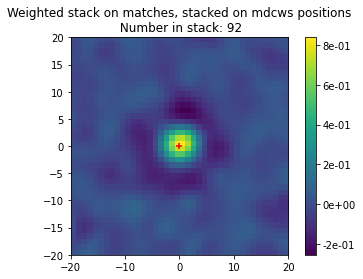

In [444]:
#Stack on MaDCoWS and ACT centers for known cross matches.
#Stacking on MaDCoWS positions
catalog = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches_V03.fits')

ra_mdcw = catalog[1].data['MaDCoWS RA(deg)']
names_mdcw = catalog[1].data['MaDCoWS Name']
dec_mdcw = catalog[1].data['MaDCoWS Dec(deg)']
ra_mdcw, dec_mdcw = np.array(ra_mdcw), np.array(dec_mdcw)
rich_mdcw = catalog[1].data['Richness']

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

"""
act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches.fits')
#act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/AdvACT_S18d_202006_MaDCoWSUnionMatch.fits')

in_act = act[1].data['MaDCoWs Name']
#in_act = act[1].data['MADCOWSUnion_name']

names = mdcw_catalog[1].data['name']
flags = [True]*len(ra_mdcw)

for i, name in enumerate(names):
    if name not in in_act:
        flags[i] = False

print("Number before confirmed removal: {}".format(len(ra_mdcw)))
ra_mdcw = ra_mdcw[flags]
dec_mdcw = dec_mdcw[flags]
rich_mdcw = rich_mdcw[flags]
names_mdcw = names_mdcw[flags]
print("Number after confirmed removal: {}".format(len(ra_mdcw)))
"""
mdcw_s18d_stack, stack_num = s18dStack(ra_mdcw, dec_mdcw, s18d, weight = True, normalize = True)

"""
out, cen, cen_d, out_d = 0,0,0,0

for i in range(len(s18d_stack[0])):
    for j in range(len(s18d_stack[0])):
        if (28<i<32) & (28<j<32):
            cen += s18d_stack[i][j]
            cen_d += 1
        else:
            out += s18d_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)
"""

plot = plt.imshow(mdcw_s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title('Weighted stack on matches, stacked on mdcws positions\n Number in stack: {}'.format(stack_num))
plt.savefig("plots/weighted_stack_mdcw_pos.png")
plt.show()
plt.close()

# Stacking on matches, ACT centers

Number in stack: 92


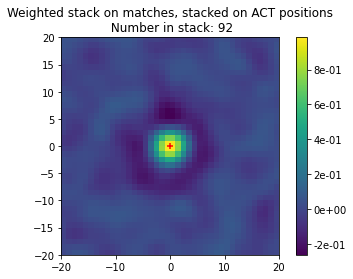

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


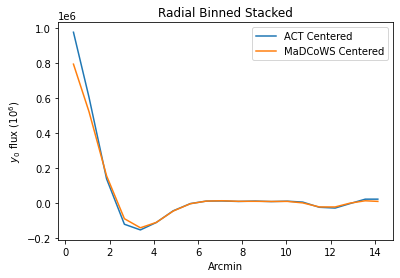

In [445]:
catalog = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches_V03.fits')

ra_act = catalog[1].data['ACT RA(deg)']
names_act = catalog[1].data['ACT Cluster']
dec_act = catalog[1].data['ACT Dec(deg)']
ra_mdcw, dec_mdcw = np.array(ra_mdcw), np.array(dec_mdcw)
"""
path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches.fits')
#act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/AdvACT_S18d_202006_MaDCoWSUnionMatch.fits')

in_act = act[1].data['ACT Cluster']
#in_act = act[1].data['Name']

flags = [True]*len(ra_act)

for i, name in enumerate(names):
    if name not in in_act:
        flags[i] = False

print("Number before confirmed removal: {}".format(len(ra_act)))
ra_act = ra_act[flags]
dec_act = dec_act[flags]
print("Number after confirmed removal: {}".format(len(ra_act)))
"""
act_s18d_stack, stack_num = s18dStack(ra_act, dec_act, s18d, weight = True, normalize = True)

"""
out, cen, cen_d, out_d = 0,0,0,0

for i in range(len(s18d_stack[0])):
    for j in range(len(s18d_stack[0])):
        if (28<i<32) & (28<j<32):
            cen += s18d_stack[i][j]
            cen_d += 1
        else:
            out += s18d_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)
"""

plot = plt.imshow(act_s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title('Weighted stack on matches, stacked on ACT positions\n Number in stack: {}'.format(stack_num))
plt.savefig("plots/unweighted_stack_ACT_pos.png")
plt.show()
plt.close()

xspline = np.linspace(-10, 10, 40)
yspline = xspline

rbin = np.linspace(0, np.sqrt(2)*max(xspline), 20)


act_r_mean, act_bin_data, c, d = binmap(act_s18d_stack,xspline,yspline,rbin)
mdcw_r_mean, mdcw_bin_data, c, d = binmap(mdcw_s18d_stack,xspline,yspline,rbin)

plt.plot(act_r_mean, act_bin_data*10**6, label = 'ACT Centered')
plt.plot(mdcw_r_mean, mdcw_bin_data*10**6, label = 'MaDCoWS Centered')
plt.title('Radial Binned Stacked')
plt.xlabel('Arcmin')
plt.ylabel('$y_0$ flux ($10^6$)')
plt.legend()
plt.savefig('normalized_weighted_comp_radial_bin.pdf')
plt.show()

In [509]:
#Jackknife error bars

jks = {'act_rs':[], 'act_bin_data':[],'mdcw_rs':[], 'mdcw_bin_data':[]}


num_jk = 95

xspline = np.linspace(-10, 10, 40)
yspline = xspline

rbin = np.linspace(0, np.sqrt(2)*max(xspline), 20)



chunks = np.array_split(range(len(ra_act)),num_jk)  


for j in range(int(num_jk)):

    ra_temp_act = np.delete(ra_act, chunks[j])
    dec_temp_act = np.delete(dec_act, chunks[j])
    
    ra_temp_mdcw = np.delete(ra_mdcw, chunks[j])
    dec_temp_mdcw = np.delete(dec_mdcw, chunks[j])
    rich_temp__mdcw = np.delete(rich_mdcw, chunks[j])
    names_temp_mdcw = np.delete(names_mdcw, chunks[j])

    stack_act, stack_num_act = s18dStack(ra_temp_act, dec_temp_act, s18d, weight = True, normalize = True)
    act_r_jk, act_bin_data_jk, c, d = binmap(stack_act,xspline,yspline,rbin)
    
    stack_mdcw, stack_num_mdcw = s18dStack(ra_temp_mdcw, dec_temp_mdcw, s18d, weight = True, normalize = True)
    mdcw_r_jk, mdcw_bin_data_jk, c, d = binmap(stack_mdcw,xspline,yspline,rbin)

    jks['act_rs'].append(act_r_jk)
    jks['act_bin_data'].append(act_bin_data_jk)
    jks['mdcw_rs'].append(mdcw_r_jk)
    jks['mdcw_bin_data'].append(mdcw_bin_data_jk)
    print(j)
    
pk.dump(jks, open( "./pks/normalized_weighted_centers_jks.p", "wb" ))


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
24


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
25


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
26


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
27


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
28


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
29


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
30


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
31


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
32


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
33


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
34


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
35


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
36


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
37


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
38


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
39


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
40


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
41


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
42


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
43


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
44


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
45


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
46


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
47


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
48


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
49


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
50


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
51


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
52


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
53


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
54


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
55


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
56


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
57


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
58


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
59


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
60


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
61


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
62


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
63


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
64


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
65


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
66


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
67


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
68


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
69


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
70


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
71


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
72


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
73


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
74


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
75


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
76


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
77


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
78


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
79


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
80


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
81


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
82


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
83


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
84


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
85


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
86


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
87


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
88


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
89


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
90


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 91
92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
93


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
94


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [224]:

yerr_jk_act = []
yerr_jk_mdcw = []

for i in range(len(jks['act_bin_data'][0])):
    jks_act = []
    jks_mdcw =[]
    
    for j in range(len(jks['act_bin_data'])):
        jks_act.append(jks['act_bin_data'][j][i])
        jks_mdcw.append(jks['mdcw_bin_data'][j][i])
    yerr_jk_act.append(np.sqrt(np.var(jks_act)))
    yerr_jk_mdcw.append(np.sqrt(np.var(jks_mdcw)))   

"""
plt.errorbar(x, y, xerr = xerr, yerr = yerr_jk, ls = 'none')
plt.xticks(x[1::2])
plt.title('Unweighted Richness vs Brightest Pixel, central 4x4\n Jackknife Estimatition, 20 patches')
plt.xlabel('Richness')
plt.ylabel('Brightest Pixel')
plt.savefig('jk_brightrich_unweighted.pdf')
plt.show()
"""
print(yerr_jk_act)

plt.errorbar(act_r_mean, act_bin_data, yerr = (np.array(yerr_jk_act)), label = 'ACT Centered')
plt.errorbar(mdcw_r_mean, mdcw_bin_data, yerr = (np.array(yerr_jk_mdcw)), label = 'MaDCoWS Centered')
plt.title('Radial Binned Stacked')
plt.xlabel('Arcmin')
plt.ylabel('$y_0$ flux ($10^6$)')
plt.legend()
plt.savefig('new_normalized_jk_comp_radial_bin.pdf')
plt.show()

[0.0004134687209006816, 0.0016370495053477387, 0.001972630074448902, 0.0012685599558733807, 0.0010549169398476773, 0.0009243584523180925, 0.0009665990007716097, 0.0009528091219595385, 0.0006781716854179832, 0.0006037696218823035, 0.0007017438514939816, 0.0007851225203398913, 0.0008018945523610221, 0.0007281934105331665, 0.0007537700541002336, 0.0009883674911737206, 0.0011771356804183785, 0.001451708131978324, 0.0020996830447455135, 0.0022145183384187795]


In [225]:
#Bootstrap 

bootstraps = {'act_rs':[], 'act_bin_data':[],'mdcw_rs':[], 'mdcw_bin_data':[]}

for j in range(200):
    flags = np.random.randint(len(ra_act), size = len(ra_act))


    ra_temp_act = ra_act[flags]
    dec_temp_act = dec_act[flags]
    
    ra_temp_mdcw = ra_mdcw[flags]
    dec_temp_mdcw = dec_mdcw[flags]

    stack_act, stack_num_act = s18dStack(ra_temp_act, dec_temp_act, s18d, weight = True, normalize = True)
    act_r_jk, act_bin_data_jk, c, d = binmap(stack_act,xspline,yspline,rbin)
    
    stack_mdcw, stack_num_mdcw = s18dStack(ra_temp_mdcw, dec_temp_mdcw, s18d, weight = True, normalize = True)
    mdcw_r_jk, mdcw_bin_data_jk, c, d = binmap(stack_mdcw,xspline,yspline,rbin)

    bootstraps['act_rs'].append(act_r_jk)
    bootstraps['act_bin_data'].append(act_bin_data_jk)
    bootstraps['mdcw_rs'].append(mdcw_r_jk)
    bootstraps['mdcw_bin_data'].append(mdcw_bin_data_jk)
    print(j)
    
pk.dump(bootstraps, open( "./pks/scatters/new_normalized_weighted_centers_bootstraps.p", "wb" ))


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
25


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
26


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 93


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 93
27


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
28


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
29


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
30


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
31


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
32


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
33


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
34


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
35


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
36


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
37


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 93


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 93
38


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
39


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
40


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
41


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
42


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
43


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
44


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
45


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
46


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 93


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 93
47


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
48


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
49


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
50


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
51


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
52


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
53


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
54


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
55


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
56


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
57


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
58


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
59


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
60


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
61


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
62


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
63


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
64


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
65


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
66


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
67


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
68


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
69


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
70


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
71


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
72


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
73


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
74


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
75


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
76


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
77


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
78


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
79


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
80


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
81


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
82


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
83


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
84


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
85


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
86


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
87


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
88


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
89


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
90


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
91


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
93


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
94


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
95


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
96


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
97


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
98


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
99


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
100


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
101


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
102


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
103


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
104


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
105


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
106


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
107


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
108


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
109


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
110


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
111


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
112


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
113


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
114


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
115


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
116


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
117


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
118


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
119


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
120


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
121


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
122


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
123


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
124


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
125


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 93


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 93
126


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
127


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
128


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
129


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
130


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
131


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
132


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
133


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
134


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
135


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
136


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
137


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
138


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
139


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
140


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
141


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
142


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
143


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
144


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
145


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
146


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
147


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
148


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
149


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
150


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
151


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
152


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
153


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
154


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
155


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
156


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
157


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
158


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
159


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
160


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
161


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
162


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
163


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
164


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
165


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
166


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
167


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
168


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
169


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
170


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
171


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
172


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
173


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
174


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
175


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
176


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
177


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
178


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
179


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
180


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
181


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
182


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
183


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
184


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
185


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
186


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
187


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
188


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
189


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
190


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
191


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
192


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
193


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
194


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
195


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
196


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
197


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
198


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
199


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.010835904716566048, 0.02485258920794761, 0.03368217329609324, 0.023929839158230295, 0.019369246754688, 0.017622562431592822, 0.0197293969025403, 0.018404383142921282, 0.016397651572867714, 0.015670756983127032, 0.014314311145397081, 0.017142514976575065, 0.016886378713748502, 0.013414899394110587, 0.016203536656426376, 0.023705846717501085, 0.028925294410733684, 0.028792650885295996, 0.03923767892392927, 0.042865458453744704]


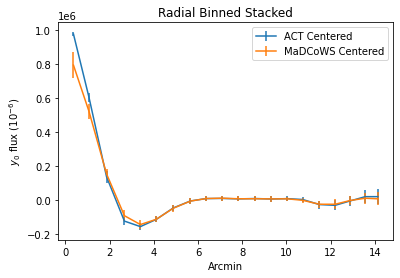

In [226]:
yerr_boot_act = []
yerr_boot_mdcw = []

for i in range(len(bootstraps['act_bin_data'][0])):
    boot_act = []
    boot_mdcw =[]
    
    for j in range(len(bootstraps['act_bin_data'])):
        boot_act.append(bootstraps['act_bin_data'][j][i])
        boot_mdcw.append(bootstraps['mdcw_bin_data'][j][i])
    yerr_boot_act.append(np.sqrt(np.var(boot_act)))
    yerr_boot_mdcw.append(np.sqrt(np.var(boot_mdcw)))   

"""
plt.errorbar(x, y, xerr = xerr, yerr = yerr_jk, ls = 'none')
plt.xticks(x[1::2])
plt.title('Unweighted Richness vs Brightest Pixel, central 4x4\n Jackknife Estimatition, 20 patches')
plt.xlabel('Richness')
plt.ylabel('Brightest Pixel')
plt.savefig('jk_brightrich_unweighted.pdf')
plt.show()
"""
print(yerr_boot_act)

plt.errorbar(act_r_mean, act_bin_data*10**6, yerr = (np.array(yerr_boot_act)*10**6), label = 'ACT Centered')
plt.errorbar(mdcw_r_mean, mdcw_bin_data*10**6, yerr = (np.array(yerr_boot_mdcw)*10**6), label = 'MaDCoWS Centered')
plt.title('Radial Binned Stacked')
plt.xlabel('Arcmin')
plt.ylabel('$y_0$ flux ($10^{-6}$)')
plt.legend()
plt.savefig('new_normalized_comp_radial_bin.pdf')
plt.show()

# Add Scatter to ACT Centers

In [268]:
catalog = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches_V03.fits')

ra_act = catalog[1].data['ACT RA(deg)']
names_act = catalog[1].data['ACT Cluster']
dec_act = catalog[1].data['ACT Dec(deg)']
ra_mdcw, dec_mdcw = np.array(ra_mdcw), np.array(dec_mdcw)

width = 25.0
#'./pks/scatters/normalized_{}_arcsec_scatter.p'.format(width)
test = offsetSim(ra_act, dec_act, name = './pks/scatters/normalized_{}_arcsec_scatter.p'.format(width), num = 10, width = width, normalize = True)

Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [327]:
scatters = {}
linsp = np.linspace(1, 40, 40)
for width in linsp:
    print(width)
    test = offsetSim(ra_act, dec_act, num = 25, width = width, normalize = True)
    #print(test['scatter_bin_data'])
    scatters['r'] = test['scatter_rs'][0]
    #print(test['scatter_bin_data'])
    scatters['{}_mean'.format(width)] = np.mean(test['scatter_bin_data'], axis = 0)
    scatters['{}_var'.format(width)] = np.sqrt(np.var(test['scatter_bin_data'], axis = 0))
    
pk.dump(scatters, open('.pks/scattters/scatter_for_colorbar.p', 'wb'))    

1.0
Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
2.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
3.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
4.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
5.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
6.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
7.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
8.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
9.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
10.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
11.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
12.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
13.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
14.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
15.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
16.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
17.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
18.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
19.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
20.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
21.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
22.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
23.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
24.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
25.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
26.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
27.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
28.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
29.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
30.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
31.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
32.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
33.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
34.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
35.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
36.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
37.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
38.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
39.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24
40.0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
0


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
1


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
2


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
3


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
4


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
5


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
6


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
7


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
8


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
9


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
10


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
11


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
12


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
13


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
14


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
15


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
16


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
17


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
18


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
19


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
20


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
21


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
22


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
23


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number in stack: 92
24


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


FileNotFoundError: [Errno 2] No such file or directory: '.pks/scattters/scatter_for_colorbar.p'

In [235]:
for key in scatters:
    print(scatters[key])

[ 0.36261886  1.06488385  1.86072091  2.66810514  3.39276289  4.11256474
  4.88029957  5.65544573  6.3696697   7.07919321  7.82968882  8.59368727
  9.31710827 10.04502087 10.74252956 11.49467348 12.20941001 12.88695833
 13.57168832 14.14213562]
[ 0.97345432  0.60332747  0.13769861 -0.12202826 -0.15445608 -0.11181716
 -0.04496831 -0.0040204   0.01004582  0.01089681  0.00816248  0.01033525
  0.00745631  0.00963839  0.0044662  -0.02505322 -0.02945071 -0.00372382
  0.02127385  0.02135406]
[6.23417244e-04 4.27737036e-04 2.00046873e-04 2.49264628e-04
 1.71100837e-04 2.10792761e-04 1.43056499e-04 1.46719614e-04
 1.07824276e-04 8.89428510e-05 7.04821288e-05 1.02393674e-04
 6.46111288e-05 1.19938697e-04 1.33372116e-04 1.62238725e-04
 1.33252043e-04 2.46914641e-04 3.19809137e-04 4.15279658e-04]
[ 0.96737909  0.60020681  0.13749552 -0.12095327 -0.15341241 -0.11145148
 -0.04491183 -0.00424709  0.00979935  0.01087573  0.00827488  0.01041998
  0.00751607  0.00969433  0.00436548 -0.02507602 -0.029377

In [513]:
thing = linsp
cmap = mpl.cm.bwr

#Interpolate for clean look
normalize = mpl.colors.Normalize(vmin=thing.min(), vmax=thing.max())
xinterp = np.linspace(np.min(scatters['r']), np.max(scatters['r']), 1000)

interp_scatter = {'r':xinterp}
for i in range(len(linsp)):
    x, y = scatters['r'], scatters[str(linsp[i])+'_mean']
    interp = interpolate.interp1d(x, y, kind = 'cubic')
    interp_scatter[i] = interp(xinterp)

fig = plt.figure()

frame1 = fig.add_axes((.1,.3,.8,.6))

#Make the main plot
for i in range(len(linsp)-1):
    #plt.fill_between(scatters['r'], y1 = scatters[str(linsp[i])+'_mean'], y2 = scatters[str(linsp[i+1])+'_mean'], alpha = 0.6, color=cmap(normalize(linsp[i])))
    plt.fill_between(interp_scatter['r'], y1 = interp_scatter[i], y2 = interp_scatter[i+1], alpha = 0.6, color=cmap(normalize(linsp[i])))

plt1 = plt.errorbar(scatters['r'], mean_data_act, yerr = (np.array(yerr_boot_act)), fmt = '.', label = 'ACT Centered', c = 'black')
plt2 = plt.errorbar(scatters['r'], mdcw_bin_data, yerr = (np.array(yerr_boot_mdcw)), fmt = '_', label = 'MaDCoWS Centered', alpha = 1.0, c = 'black')

#plt.legend([plt1,plt2],["ACT Centered", "MaDCoWS Centered"], loc='best', bbox_to_anchor=(0.5, 0.45, 0.5, 0.5))

a = plt.axes([.4, .5, .5, .4])

for i in range(len(linsp)-1):
    #plt.fill_between(scatters['r'], y1 = scatters[str(linsp[i])+'_mean'], y2 = scatters[str(linsp[i+1])+'_mean'], alpha = 0.6, color=cmap(normalize(linsp[i])))
    plt.fill_between(interp_scatter['r'], y1 = interp_scatter[i], y2 = interp_scatter[i+1], alpha = 0.6, color=cmap(normalize(linsp[i])))

plt1 = plt.errorbar(scatters['r'], mean_data_act, yerr = (np.array(yerr_boot_act)), fmt = '.', label = 'ACT Centered', c = 'black')
plt2 = plt.errorbar(scatters['r'], mdcw_bin_data, yerr = (np.array(yerr_boot_mdcw)), fmt = '_', label = 'MaDCoWS Centered', alpha = 1.0, c = 'black')

plt.legend([plt1,plt2],["ACT Centered", "MaDCoWS Centered"], loc='best', bbox_to_anchor=(0.41, 0.1, 0.25, 0.28))
plt.xticks(np.arange(0, 2, step=0.5))
plt.yticks(np.arange(0, 1, step = 0.2))
plt.axis([0,2,0,1])

cbax = fig.add_axes([0.90, 0.3, 0.015, 0.6])
cb = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb.set_label("Offset Magnigtude (\")", rotation=270, labelpad=15)    

plt.savefig('./plots/scatters/scatter_range.pdf')
plt.savefig('./plots/scatters/scatter_range.png', dpi=300)


#difference = mdcw_bin_data - mean_data_act
frame2 = fig.add_axes((.1,.1,.8,.2))        
#plt.errorbar(scatters['r'],difference,yerr = (np.array(yerr_boot_mdcw)), fmt='_')
for i in [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]:
    plt.errorbar(scatters['r'], scatters[str(i)+'_mean'] - mdcw_bin_data, yerr = scatters[str(i)+'_var'], fmt = '_', label = '{}\"'.format(i))
plt.legend(ncol = len([5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]), loc='best')
#plt.grid()

plt.savefig('./plots/scatters/scatter_range_residuals.pdf')
plt.savefig('./plots/scatters/scatter_range_residuals.png', dpi=300)
plt.show()
plt.close()

"""
fig2 = plt.figure()
plt.errorbar(scatters['r'], np.zeros(len(yerr_boot_mdcw)), yerr= yerr_boot_mdcw, fmt = 'none', c = 'black')
for i in [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]:
    plt.errorbar(scatters['r'], scatters[str(i)+'_mean'] - mdcw_bin_data, yerr = scatters[str(i)+'_var'], alpha = 0.5, fmt = '_', label = '{}\"'.format(i))
plt.legend(ncol = 3)
plt.savefig('./plots/scatters/scatter_just_residuals.pdf')
"""

'\nfig2 = plt.figure()\nplt.errorbar(scatters[\'r\'], np.zeros(len(yerr_boot_mdcw)), yerr= yerr_boot_mdcw, fmt = \'none\', c = \'black\')\nfor i in [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]:\n    plt.errorbar(scatters[\'r\'], scatters[str(i)+\'_mean\'] - mdcw_bin_data, yerr = scatters[str(i)+\'_var\'], alpha = 0.5, fmt = \'_\', label = \'{}"\'.format(i))\nplt.legend(ncol = 3)\nplt.savefig(\'./plots/scatters/scatter_just_residuals.pdf\')\n'

In [331]:
fit = plt.figure()

xinterp = np.linspace(np.min(scatters['r']), np.max(scatters['r']), 1000)

x, y = scatters['r'], mean_data_act
norm_interp = interpolate.interp1d(x,y, kind = 'cubic')

norm = norm_interp(xinterp)
#plt.plot(xinterp, norm)
#plt.plot(interp_scatter['r'], interp_scatter[9])
plt.axis([0,3,0.5,2])
for i in range(len(linsp)-1):
    #plt.fill_between(scatters['r'], y1 = scatters[str(linsp[i])+'_mean'], y2 = scatters[str(linsp[i+1])+'_mean'], alpha = 0.6, color=cmap(normalize(linsp[i])))
    plt.fill_between(interp_scatter['r'], y1 = interp_scatter[i]/norm, y2 = interp_scatter[i+1]/norm, alpha = 0.6, color=cmap(normalize(linsp[i])))
    
plt.errorbar(scatters['r'], mean_data_act/mean_data_act, yerr = (np.array(yerr_boot_act)), fmt = 'o', label = 'ACT Centered')
plt.errorbar(scatters['r'], mdcw_bin_data/mean_data_act, yerr = (np.array(yerr_boot_mdcw)), fmt = 'o', label = 'MaDCoWS Centered', alpha = 0.9, c = 'black')


<ErrorbarContainer object of 3 artists>

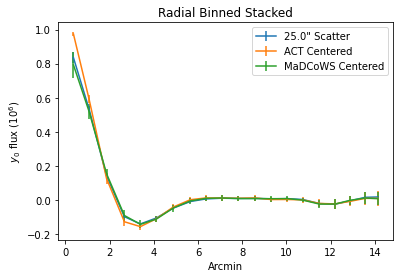

In [269]:
act_centered = pk.load( open( "./pks/scatters/new_normalized_weighted_centers_jks.p", "rb" ) )

mean_data_scatter = np.mean(test['scatter_bin_data'], axis = 0)
mean_data_act = np.mean(act_centered['act_bin_data'], axis = 0)
r = test['scatter_rs'][0]

yerr_scatter_boot = []
yerr_act_boot =[]

for i in range(len(test['scatter_bin_data'][0])):
    boot_scatter = []
    for j in range(len(test['scatter_bin_data'])):
        boot_scatter.append(test['scatter_bin_data'][j][i])
    yerr_scatter_boot.append(np.sqrt(np.var(boot_scatter)))
    
for i in range(len(act_centered['act_bin_data'][0])):
    boot_act = []
    for j in range(len(act_centered['act_bin_data'])):
        boot_act.append(act_centered['act_bin_data'][j][i])
    yerr_act_boot.append(np.sqrt(np.var(boot_act)))
    
plt.errorbar(r, mean_data_scatter, yerr = (np.array(yerr_scatter_boot)), label = '{}\" Scatter'.format(width))
plt.errorbar(r, mean_data_act, yerr = (np.array(yerr_boot_act)), label = 'ACT Centered')
plt.errorbar(mdcw_r_mean, mdcw_bin_data, yerr = (np.array(yerr_boot_mdcw)), label = 'MaDCoWS Centered')
plt.title('Radial Binned Stacked')
plt.xlabel('Arcmin')
plt.ylabel('$y_0$ flux ($10^6$)')
plt.legend()
plt.savefig('new_normalized_{}_arcsec_scatter.pdf'.format(width))
plt.show()

In [173]:
#print(mean_data_act)
#print(act_bin_data)
print(mdcw_bin_data)
print(max(np.transpose(act_centered['act_bin_data'])[0]))

[ 7.34799875e-01  4.93897865e-01  1.61247588e-01 -7.12724421e-02
 -1.29958930e-01 -1.10899066e-01 -5.08287524e-02 -8.38339629e-03
  7.95026458e-03  9.92804616e-03  8.21804170e-03  1.01037595e-02
  1.16660787e-02  9.82170786e-03 -8.30819795e-05 -2.27839883e-02
 -2.53366874e-02  1.43303392e-03  2.04731644e-02  1.83621777e-02]
0.9767142749541555


# Looking at brightness by richness bin

In [110]:

def richStat(data, catalog, r_low, r_high, bins = 1, save_plot = False):
    ra = catalog[1].data['RADeg']
    names = catalog[1].data['name']
    dec = catalog[1].data['decDeg']
    ra, dec = np.array(ra), np.array(dec)
    rich = catalog[1].data['Rich']
    names = catalog[1].data['name']
    path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

    cut = np.where((r_low<np.array(rich)) & (np.array(rich)<=r_high))[0]
    cut_ra, cut_dec, cut_names, cut_rich = ra[cut], dec[cut], names[cut], rich[cut]
    
    if bins == 1:
        stack, num = s18dStack(cut_ra, cut_dec, data)

        plot = plt.imshow(stack)
        plt.colorbar(plot, format='%.0e')
        plt.title("ACT S18 dStack on MaDCoWS w/ {}=>Richness>{}\n Total in stack: {}".format(r_high, r_low, num))

        plt.show()
        mean = np.amax(stack[18:22, 18:22])

        brights = []
        for i in range(len(cut_ra)):
            stamp = s18dStamp(cut_ra[i], cut_dec[i], s18d, 'fakename', width = 1/3, write = False)
            if stamp is None: continue
            brights.append(np.amax(stamp[0][18:22, 18:22]))

            if save_plot:
                plot = plt.imshow(stamp[0], extent = [-20,20,-20,20])
                plt.scatter(0,0, marker = '+', color = 'r')
                plt.colorbar(plot, format='%.0e')
                plt.title('Cluster {}, {}th Percentile'.format(cut_names[i], round(100/(bin))))

                plt.savefig('plots/indv_clusters/' + str(cut_names[i]) + '.png')
                plt.close()

        var = np.var(brights)
        #print(brights)
    
        return mean, var
    else:
        percs = [r_low]
        means = []
        varies =[]
        #NOTE: Percentiles are in terms of the full MaDCoWS catalog: these will not neccesarily be exactly the
        #percentiles for the subset of the clusters that are in the s18d footprint
        for i in range(bins):
            perc = np.percentile(cut_rich, (i+1)*100/(bins))
            percs.append(perc)
        for i in range(bins):
            flags2 = np.where((percs[i] < cut_rich) & (cut_rich <= percs[i+1]))[0]
            cut_ra2, cut_dec2, cut_names2, cut_rich2 = cut_ra[flags2], cut_dec[flags2], cut_names[flags2], cut_rich[flags2]
        
            stack, num = s18dStack(cut_ra2, cut_dec2, data)

            plot = plt.imshow(stack, extent = [-20,20,-20,20])
            plt.colorbar(plot, format='%.0e')
            plt.scatter(0,0, marker = '+', color = 'r')
            
            plt.title("ACT S18d Stack on MaDCoWS w/ {}=>Richness>{}\n {} to {}th percentile, total in stack: {}".format(r_high, r_low, int((i)*100/(bins)), int((i+1)*100/(bins)), num))
            plt.savefig('plots/rich_bins/rich_bin_{}_{}_{}_rich_perc.png'.format(r_low, r_high, int((i+1)*100/(bins))))
            plt.show()
            mean = np.amax(stack[18:22, 18:22])

            brights = []
            for i in range(len(cut_ra2)):
                stamp = s18dStamp(cut_ra2[i], cut_dec2[i], s18d, 'fakename', width = 1/3, write = False)
                if stamp is None: continue
                brights.append(np.amax(stamp[0][18:22, 18:22]))

                if save_plot:
                    plot = plt.imshow(stamp[0], extent = [-20,20,-20,20])
                    plt.scatter(0,0, marker = '+', color = 'r')
                    plt.colorbar(plot, format='%.0e')
                    plt.title('Cluster {}, {}th Richness Percentile'.format(cut_names2[i], int((i+1)*100/(bins))))
                    
                    plt.savefig('plots/indv_clusters/' + str(cut_names2[i]) + '_richness_' + str(cut_rich2[i]) + '_perc_' + str(int((i+1)*100/(bins))) + '.png')
                    plt.close()

            var = np.var(brights)
            varies.append(np.sqrt(var))
            means.append(mean)
            
        return means, varies
    

# Stacking in richness bins, quartiles of richness

Number in stack: 28


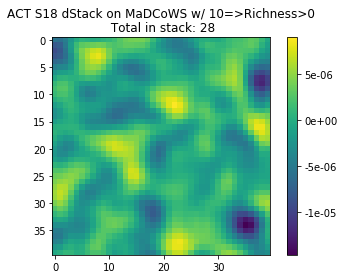

1.18257606444e-05
Number in stack: 178


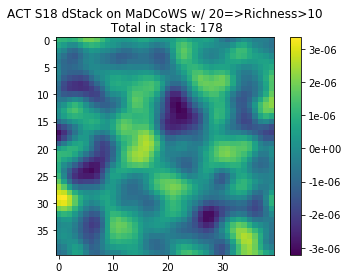

1.49838762966e-05
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 376


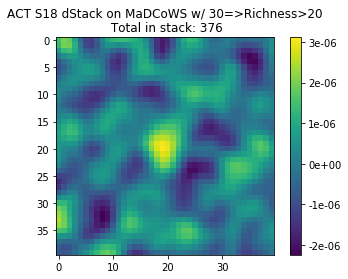

1.60489309828e-05
Number in stack: 233


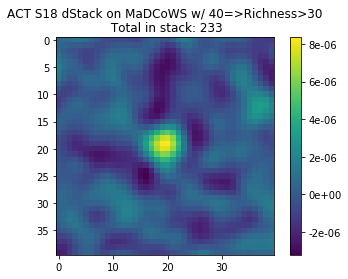

1.87012302936e-05
Number in stack: 89


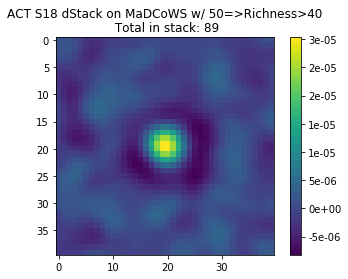

3.53194427629e-05
Number in stack: 33


5.71648651158e-05
Number in stack: 7


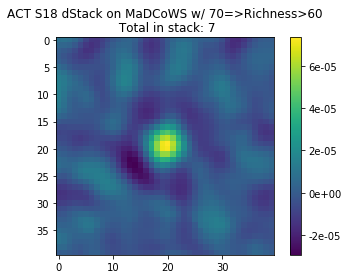

4.4753701463e-05


In [13]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

means = []
for i in range(0, 70, 10):
    mean, ignore = richStat(s18d, mdcw_catalog, i, i + 10)
    means.append(mean)
    print(np.sqrt(ignore))

Number in stack: 12


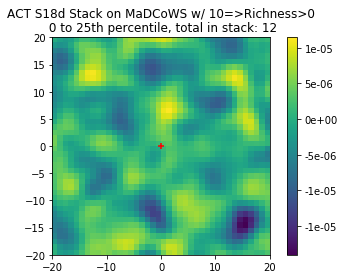

Number in stack: 1


Number in stack: 9


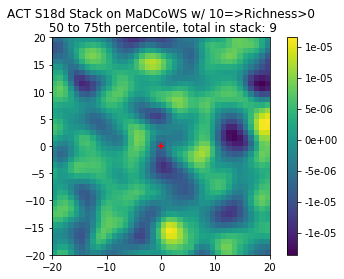

Number in stack: 6


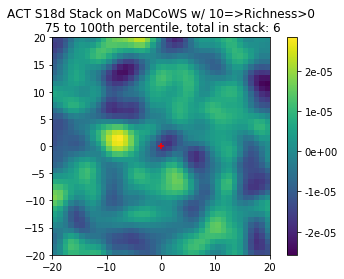

Number in stack: 62


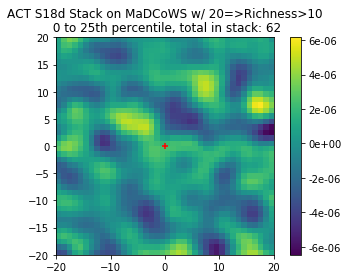

Number in stack: 46


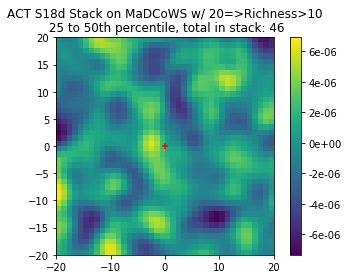

Number in stack: 40


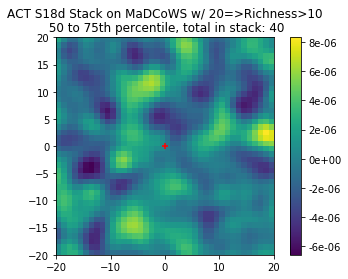

Number in stack: 30


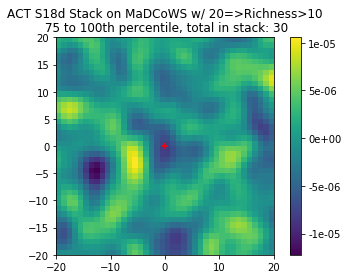

Number in stack: 115


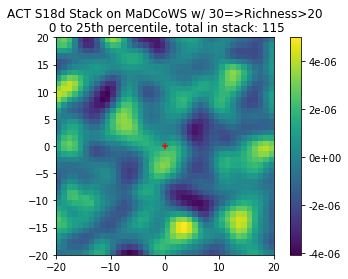

Number in stack: 71


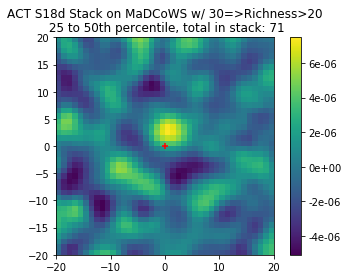

3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 115


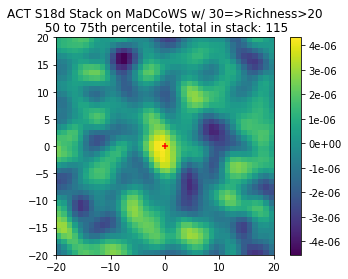

Number in stack: 75


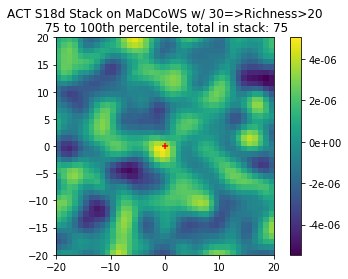

Number in stack: 83


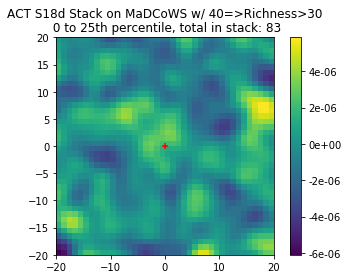

Number in stack: 56


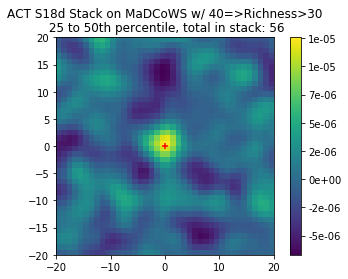

Number in stack: 54


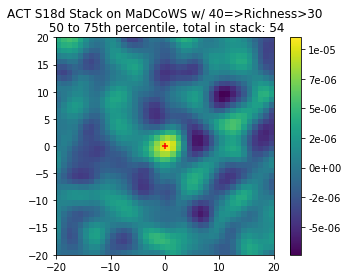

Number in stack: 40


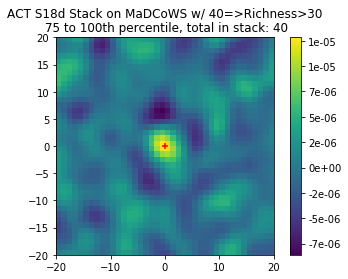

Number in stack: 31


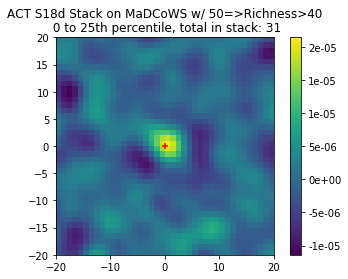

Number in stack: 20


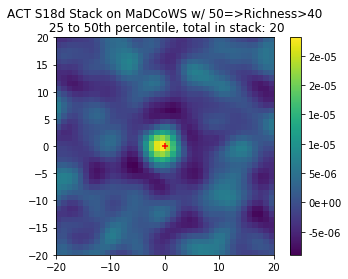

Number in stack: 20


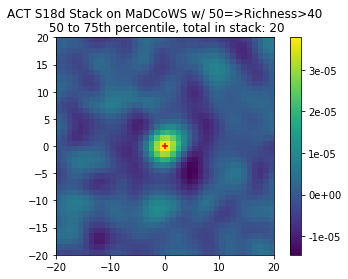

Number in stack: 18


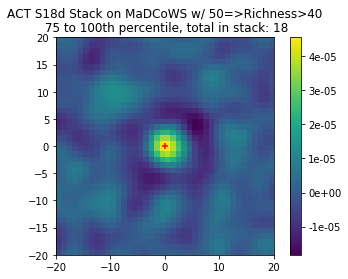

Number in stack: 15


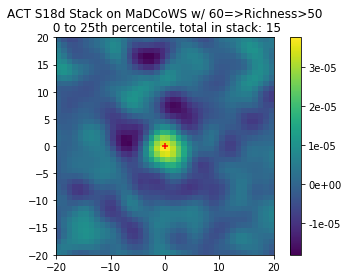

Number in stack: 5


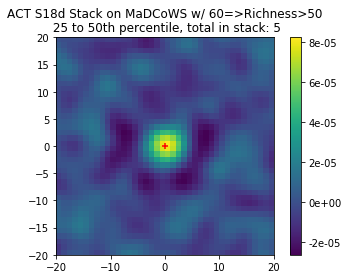

Number in stack: 7


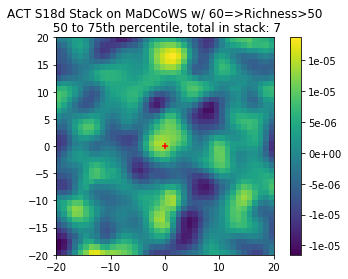

Number in stack: 6


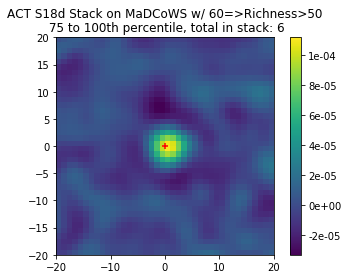

In [32]:
long_means =[]
long_vars = []
for i in range(0, 60, 10):
    mean, var = richStat(s18d, mdcw_catalog, i, i+10, bins = 4, save_plot = True)
    long_means.append(mean)
    long_vars.append(var)

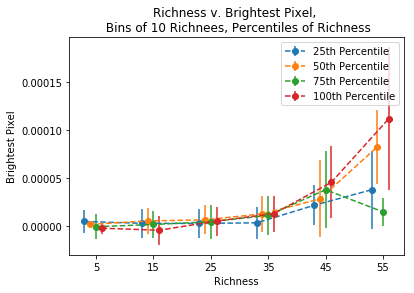

In [19]:
temp_var = np.transpose(long_vars)
temp = np.transpose(long_means)
for i in range(len(temp)):
    plt.errorbar( range(3+i,63+i, 10),temp[i], yerr= temp_var[i], label = str(int((i+1)*100/(len(temp))))+'th Percentile', marker='o',linestyle="dashed")
plt.legend()
plt.xlabel('Richness')
plt.xticks(range(5, 65, 10))
plt.ylabel('Brightest Pixel')
plt.title('Richness v. Brightest Pixel, \n Bins of 10 Richnees, Percentiles of Richness')
plt.savefig('richness-brightness.png')
plt.show()

# Stacking in bins of richness, brightness bin

In [28]:
#Now still binning in Richness but in percentiles of brightest pixel (center 4x4 pixels)
def richStatBright(data, catalog, r_low, r_high, bins = 1, save_plot = False):
    ra = catalog[1].data['RADeg']
    names = catalog[1].data['name']
    dec = catalog[1].data['decDeg']
    ra, dec = np.array(ra), np.array(dec)
    rich = catalog[1].data['Rich']
    names = catalog[1].data['name']
    path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

    cut = np.where((r_low<np.array(rich)) & (np.array(rich)<=r_high))[0]
    cut_ra, cut_dec, cut_names, cut_rich = ra[cut], dec[cut], names[cut], rich[cut]
    
    stack, num = s18dStack(cut_ra, cut_dec, data)

    #plot = plt.imshow(stack)
    #plt.colorbar(plot, format='%.0e')
    #plt.title("ACT S18 dStack on MaDCoWS w/ {}=>Richness>{}\n Total in stack: {}".format(r_high, r_low, num))

    #plt.show()
    #mean = np.amax(stack[18:22, 18:22])

    brights = []
    for i in range(len(cut_ra)):
        stamp = s18dStamp(cut_ra[i], cut_dec[i], s18d, 'fakename', width = 1/3, write = False)
        if stamp is None: continue
        brights.append(np.amax(stamp[0][18:22, 18:22]))



    
    percs = [0]
    means = []
    varies = []
    #NOTE: Percentiles are in terms of the full MaDCoWS catalog: these will not neccesarily be exactly the
    #percentiles for the subset of the clusters that are in the s18d footprint
    for i in range(bins):
        perc = np.percentile(brights, (i+1)*100/(bins))
        percs.append(perc)
        
    for i in range(bins):
        flag = np.where((percs[i] < np.array(brights)) & (np.array(brights) <= percs[i+1]))[0]
        
        cut_ra2, cut_dec2, cut_names2, brights2 = cut_ra[flag], cut_dec[flag], cut_names[flag], np.array(brights)[flag]
        
        stack, num = s18dStack(cut_ra2, cut_dec2, data)
        
        plot = plt.imshow(stack, extent = [-20,20,-20,20])
        plt.scatter(0,0, marker = '+', color = 'r')
        plt.colorbar(plot, format='%.0e')
        plt.title("ACT S18d Stack on MaDCoWS w/ {}=>Richness>{}\n {} to {}th brightness percentile, total in stack: {}".format(r_high, r_low, int((i)*100/(bins)), int((i+1)*100/(bins)), num))
        plt.savefig('plots/rich_bins/rich_bin_{}_{}_{}_bright_perc.png'.format(r_low, r_high, int((i+1)*100/(bins))))
        plt.show()
        plt.close()

        means.append(np.amax(stack[18:22, 18:22]))
        var = np.var(brights2)
        varies.append(np.sqrt(var))
        
    return means, varies

Number in stack: 28
Number in stack: 3


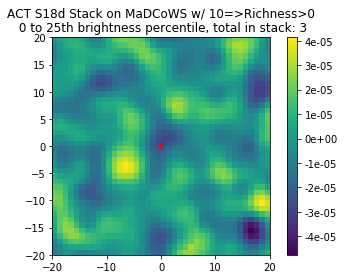

Number in stack: 5


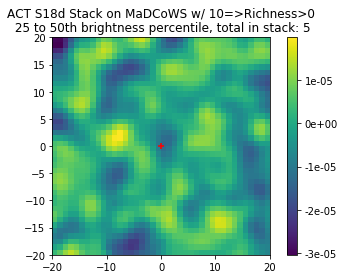

Number in stack: 5


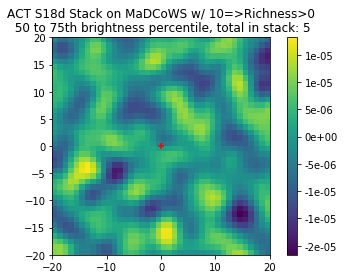

Number in stack: 5


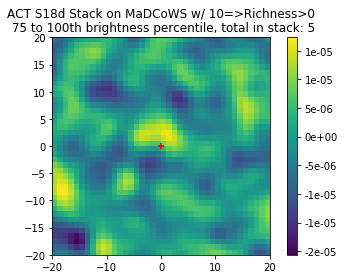

Number in stack: 178
Number in stack: 7


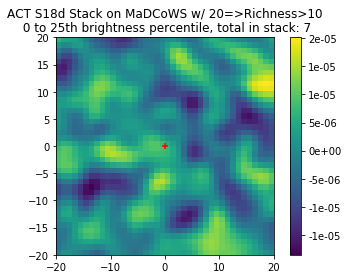

Number in stack: 21


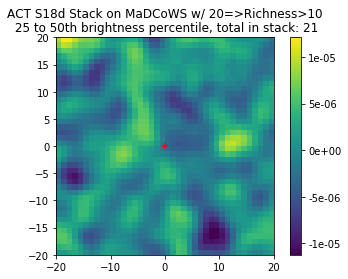

Number in stack: 30


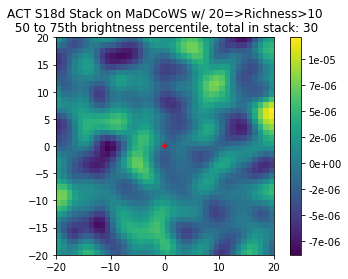

Number in stack: 27


3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 376
Number in stack: 38


3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 54


Number in stack: 58


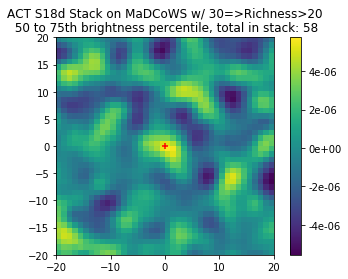

Number in stack: 60


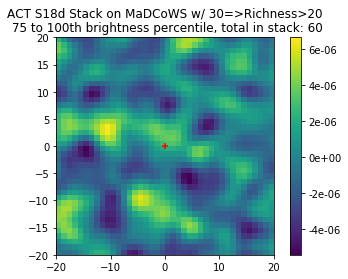

Number in stack: 233
Number in stack: 21


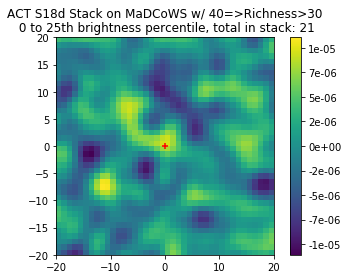

Number in stack: 29


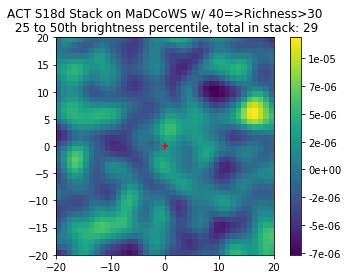

Number in stack: 27


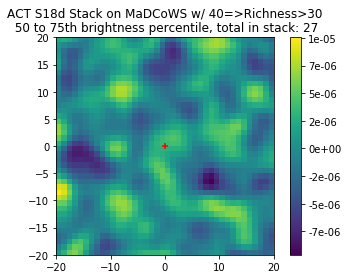

Number in stack: 35


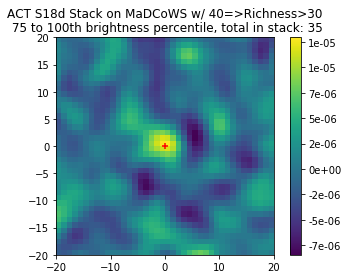

Number in stack: 89
Number in stack: 11


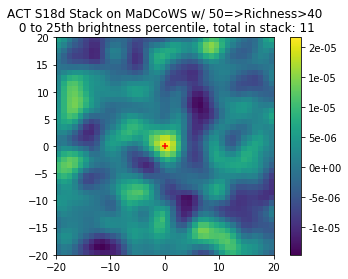

Number in stack: 12


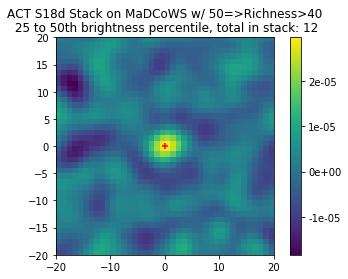

Number in stack: 13


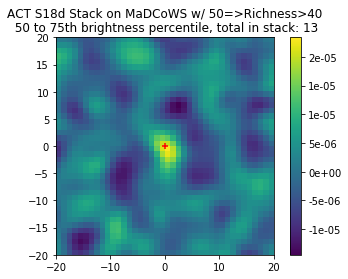

Number in stack: 7


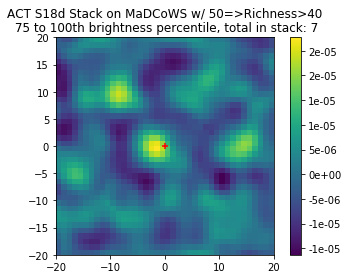

Number in stack: 33
Number in stack: 4


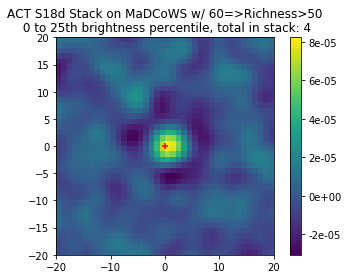

Number in stack: 4


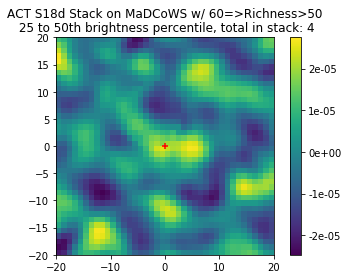

Number in stack: 5


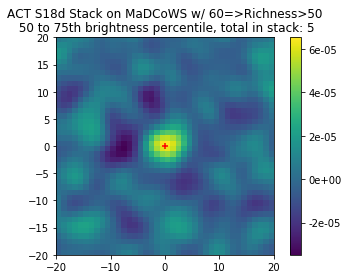

Number in stack: 3


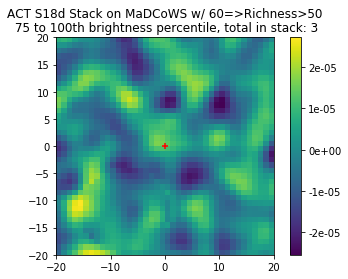

In [29]:
long_means2 = []
long_vars2 = []
for i in range(0, 60, 10):
    mean, var = richStatBright(s18d, mdcw_catalog, i, i+10, bins = 4)
    long_means2.append(mean)
    long_vars2.append(var)
    

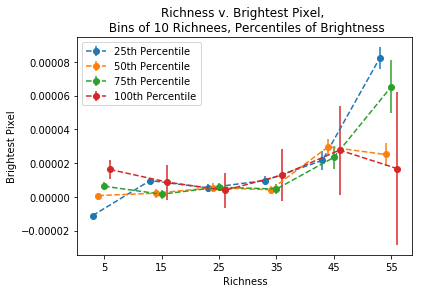

In [30]:
temp2 = np.transpose(long_means2)
temp_var2 = np.transpose(long_vars2)
for i in range(len(temp)):
    plt.errorbar( range(3+i,63+i, 10),temp2[i], yerr = temp_var2[i], label = str(int((i+1)*100/(len(temp))))+'th Percentile', marker='o',linestyle="dashed")
plt.legend()
plt.xlabel('Richness')
plt.xticks(range(5, 65, 10))
plt.ylabel('Brightest Pixel')
plt.title('Richness v. Brightest Pixel, \n Bins of 10 Richnees, Percentiles of Brightness')
plt.savefig('richness-brightness2.png')
plt.show()

# Inverse Noise weighted stacking


In [38]:
rms = fits.open('/scratch/r/rbond/jorlo/S18d_202006/selFn/RMSMap_Arnaud_M2e14_z0p4.fits')


In [11]:
#i=10
#plots = enplot.plot(rms[i].data,mask=0)
#enplot.show(plots)

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

mdcw_ra = mdcw_catalog[1].data['RADeg']
mdcw_dec =mdcw_catalog[1].data['decDeg']

#print(mdcw_ra[5])

tileName = tileFinder(3.63875, -9.15638888889, s18d)
print(tileName)
path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'
#tileName = rms[i].header['EXTNAME']
tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+str(tileName)+'_filteredMap.fits')

#test = enmap.read_map('/scratch/r/rbond/jorlo/S18d_202006/selFn/RMSMap_Arnaud_M2e14_z0p4.fits')
#plt.imshow(tile, vmin=-1e-6,vmax=1e-6)
#plt.colorbar()
#plt.show()

for i in range(1,500):
    if rms[i].header['EXTNAME'] == tileName:
        temp = i
        break
print(i)

rmsmap = rms[i].data
print(rmsmap.shape)

coords = np.deg2rad(np.array(( -18.5816666667, 206.622916667)))
ypix,xpix = enmap.sky2pix(tile.shape,tile.wcs,coords)

print('{},{}'.format(ypix,xpix))

#ypix = 100 ; xpix = 300
#pixes = np.array((ypix,xpix))
#dec,ra = enmap.pix2sky(tile.shape,tile.wcs,pixes)
#ra, dec = np.rad2deg([ra,dec])
#print('{},{}'.format(ra,dec))

weight = rmsmap[int(ypix),int(xpix)]
print(weight**2)

1_9_7
144
(882, 1468)
-659.8000000040083,19808.24999996007


IndexError: index 19808 is out of bounds for axis 1 with size 1468

# Stacking in decade bins of richness

In [542]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')
rms = fits.open('/scratch/r/rbond/jorlo/S18d_202006/selFn/RMSMap_Arnaud_M2e14_z0p4.fits')


ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

"""
act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches.fits')
in_act = act[1].data['MADCOWSUnion_name']

names = mdcw_catalog[1].data['name']
flags = [True]*len(ra)

for i, name in enumerate(names):
    if name not in in_act:
        flags[i] = True

print("Number before confirmed removal: {}".format(len(ra)))
ra = ra[flags]
dec = dec[flags]
rich = rich[flags]
names = names[flags]
print("Number after confirmed removal: {}".format(len(ra)))
#print(rich)
"""
flags = np.where((rich < 1000) & (rich>0))[0]

print('Number before no richness removal: {}'.format(len(ra)))
z = z[flags]
ra = ra[flags]
dec = dec[flags]
rich = rich[flags]
names = names[flags]
print('Number after no richness removal: {}'.format(len(ra)))

flags = getFlags(ra, dec, s18d)

print('Number before outside map removal: {}'.format(len(ra)))
z = z[flags]
ra = ra[flags]
dec = dec[flags]
rich = rich[flags]
names = names[flags]
print('Number after outside map removal: {}'.format(len(ra)))

bins = 10

perc = np.percentile(rich, np.linspace(0,100, bins+1))
perc[0] = perc[0]-1

stacks = []
stack_nums = []
for i in range(bins):
    cut = np.where((rich>perc[i]) & (rich <= perc[i+1]))[0]
    
    ra_cut = ra[cut]
    dec_cut = dec[cut]
    rich_cut = rich[cut]
    names_cut = names[cut]
    
    stack, stack_num = s18dStack(ra_cut, dec_cut, s18d, weight = True)
    
    stacks.append(stack)
    stack_nums.append(stack_num)

pk.dump(stacks, open( "weighted_stacks.p", "wb" ))


Number before no richness removal: 2839
Number after no richness removal: 1869
Number before outside map removal: 1869
Number after outside map removal: 1012
Number in stack: 111
Number in stack: 106
Number in stack: 121
Number in stack: 74
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
Number in stack: 

In [543]:
stacks[4]

ndmap([[-2.33535436e-06 -1.59265236e-06 -2.99897359e-06 ... -4.56448567e-06
  -4.84955934e-06 -2.97339931e-06]
 [ 4.67311538e-07  5.28364155e-07 -1.90430211e-06 ... -7.30393163e-06
  -5.92555940e-06 -2.98291335e-06]
 [ 3.08237853e-06  2.30808529e-06 -1.00359195e-06 ... -9.07461011e-06
  -5.72463343e-06 -1.73051351e-06]
 ...
 [-2.36201587e-06 -9.05059165e-07  1.05575248e-06 ...  1.79377218e-06
   3.77468907e-06  3.40457706e-06]
 [-3.00736992e-06 -2.55032362e-06 -1.00087227e-06 ...  1.58598159e-06
   4.31513650e-06  4.02820157e-06]
 [-2.64533673e-06 -2.62886817e-06 -1.13592168e-06 ...  9.54159920e-07
   3.83674929e-06  3.37674907e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})

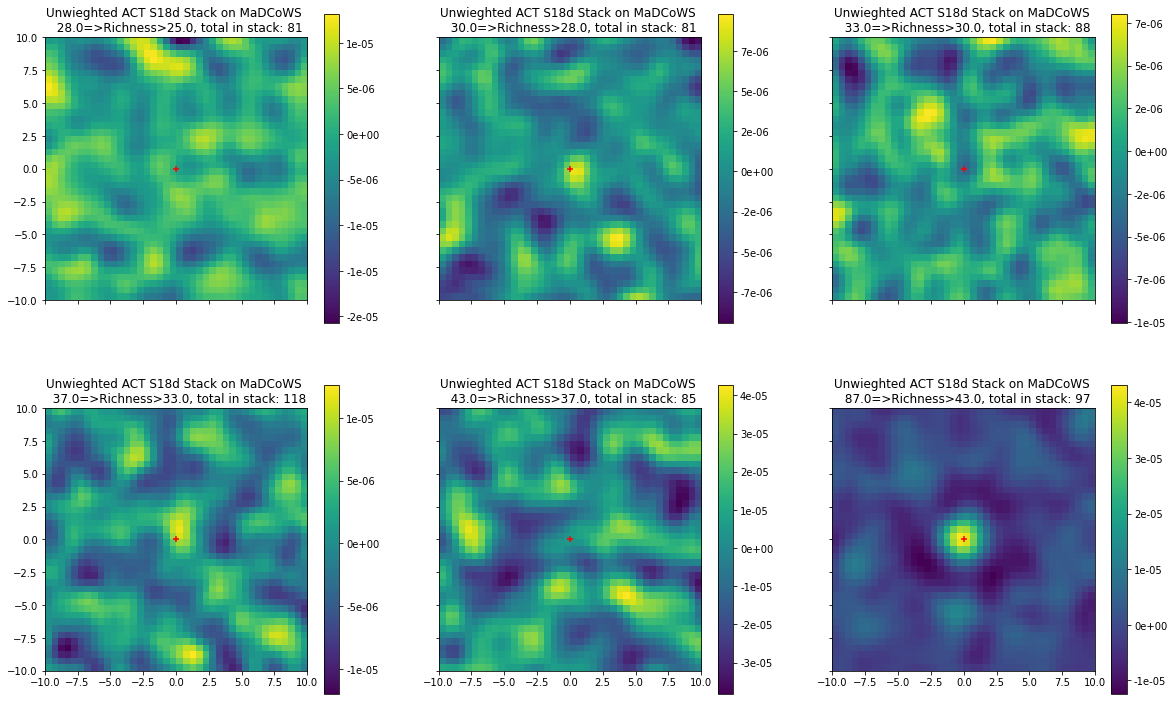

In [545]:
#norm = matplotlib.colors.Normalize(vmin=-1.5*10**-5, vmax = 5*10**-5)
#cmap = matplotlib.cm.PRGn
#sm = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)

"""
for i in range(len(perc)-1):
    width = 0.5*len(stacks[i][0])/2
    
    plot = plt.imshow(stacks[i],  extent = [-width,width,-width,width])
    plt.scatter(0,0, marker = '+', color = 'r')
    #plt.clim(vmin, vmax);
    plt.colorbar(plot, format='%.0e')
    #plt.pcolor(X, Y, f(data), cmap=cm, vmin=-4, vmax=4)

    plt.title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], stack_nums[i]))
    plt.savefig('plots/inv_noise/rich_bin_{}_unnormed_weighted.pdf'.format(perc[i+1]))
    plt.show()
    plt.close()
    
    width = 0.5*len(stacks[i][0])/2
    vmin, vmax = -5*10**-5, 5*10**-5
    plot = plt.imshow(stacks[i],  extent = [-width,width,-width,width],vmin = vmin, vmax = vmax)
    plt.scatter(0,0, marker = '+', color = 'r')
    #plt.clim(vmin, vmax);
    plt.colorbar(plot, format='%.0e')
    #plt.pcolor(X, Y, f(data), cmap=cm, vmin=-4, vmax=4)

    plt.title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], stack_nums[i]))
    plt.savefig('plots/inv_noise/rich_bin_{}_normed_weighted.pdf'.format(perc[i+1]))
    plt.show()
    plt.close()
"""  
#stacks = pk.load(open( "weighted_stacks.p", "rb" ))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(20,12.5))
width = 0.5*len(stacks[0][0])/2

i = 4
plot = ax1.imshow(stacks[i],  extent = [-width,width,-width,width])
ax1.scatter(0,0, marker = '+', color = 'r')
ax1.set_title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], stack_nums[5]))
fig.colorbar(plot, ax = ax1, format='%.0e')

i = 5
plot = ax2.imshow(stacks[i],  extent = [-width,width,-width,width])
ax2.scatter(0,0, marker = '+', color = 'r')
ax2.set_title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], stack_nums[i]))
fig.colorbar(plot, ax = ax2, format='%.0e')

i = 6
plot = ax3.imshow(stacks[i],  extent = [-width,width,-width,width])
ax3.scatter(0,0, marker = '+', color = 'r')
ax3.set_title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], stack_nums[i]))
fig.colorbar(plot, ax = ax3, format='%.0e')

i = 7
plot = ax4.imshow(stacks[i],  extent = [-width,width,-width,width])
ax4.scatter(0,0, marker = '+', color = 'r')
ax4.set_title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], stack_nums[i]))
fig.colorbar(plot, ax = ax4, format='%.0e')

i = 8
plot = ax5.imshow(stacks[i],  extent = [-width,width,-width,width])
ax5.scatter(0,0, marker = '+', color = 'r')
ax5.set_title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], stack_nums[i]))
fig.colorbar(plot, ax = ax5, format='%.0e')

i = 9
plot = ax6.imshow(stacks[i],  extent = [-width,width,-width,width])
ax6.scatter(0,0, marker = '+', color = 'r')
ax6.set_title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], stack_nums[i]))
fig.colorbar(plot, ax = ax6, format='%.0e')

"""
for i in range(0,6):
    
    ax1 = plt.subplot(2, 3, i+1)
    width = 0.5*len(stacks[i][0])/2
    
    plot = plt.imshow(stacks[i+5],  extent = [-width,width,-width,width])
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+6], perc[i+5], stack_nums[i+5]))
    plt.colorbar(plot, format='%.0e')
"""
plt.savefig('./plots/inv_noise/all_rich.pdf')
plt.savefig('./plots/inv_noise/all_rich.png', dpi = 300)
plt.show()

# Adding z cuts


In [42]:
zbins = 5
zcut_dict = {}
for i in range(bins):
    cut = np.where((rich>perc[i]) & (rich <= perc[i+1]))[0]
    z_cut = z[cut]
    ra_cut = ra[cut]
    dec_cut = dec[cut]
    rich_cut = rich[cut]
    names_cut = names[cut]
    zperc = np.percentile(z_cut, np.linspace(0,100, bins+1))
    zperc[0] = zperc[0]-0.1
    for j in range(zbins):
        cut2 = np.where((z_cut>zperc[j]) & (z_cut <= zperc[j+1]))[0]
        ra_cut2 = ra_cut[cut2]
        dec_cut2 = dec_cut[cut2]
        rich_cut2 = rich_cut[cut2]
        names_cut2 = names_cut[cut2]

        stack, stack_num = s18dStack(ra_cut2, dec_cut2, s18d, weight = True)

        zcut_dict['rich_{}_z_{}'.format(i,j)] =[stack, stack_num]

    pk.dump(zcut_dict, open( "zcut_weighted_stacks.p", "wb" ))


5
Number in stack: 12
8
Number in stack: 11
6
Number in stack: 11
1
Number in stack: 11
1
Number in stack: 6
Number in stack: 11
0
Number in stack: 10
4
Number in stack: 9
Number in stack: 11
Number in stack: 12
Number in stack: 14
0
Number in stack: 10
4
Number in stack: 12
15
Number in stack: 15
1
Number in stack: 6
7
Number in stack: 9
Number in stack: 9
Number in stack: 5
Number in stack: 6
0
Number in stack: 7
2
Number in stack: 12
Number in stack: 13
4
Number in stack: 11
1
Number in stack: 11
5
Number in stack: 12
4
Number in stack: 8
5
Number in stack: 8
1
Number in stack: 8
3
Number in stack: 8
5
Number in stack: 6
Number in stack: 10
2
Number in stack: 8
Number in stack: 10
Number in stack: 7
5
Number in stack: 11
3
Number in stack: 12
13
Number in stack: 13
Number in stack: 9
Number in stack: 16
1
Number in stack: 12
1
Number in stack: 8
4
Number in stack: 9
Number in stack: 10
Number in stack: 8
5
Number in stack: 5
1
Number in stack: 9
5
Number in stack: 9
7
Number in stac

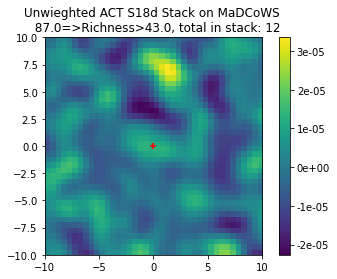

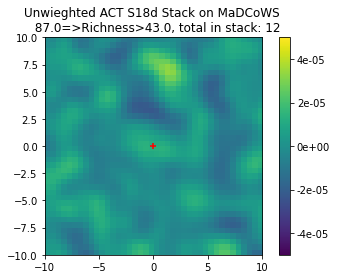

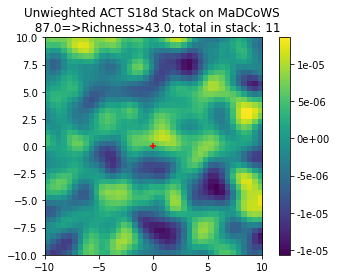

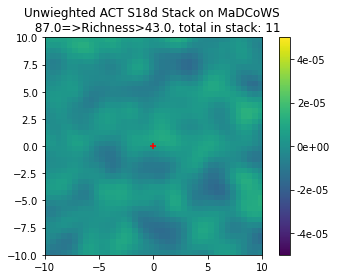

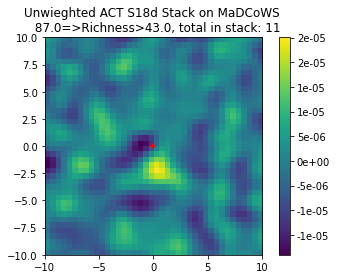

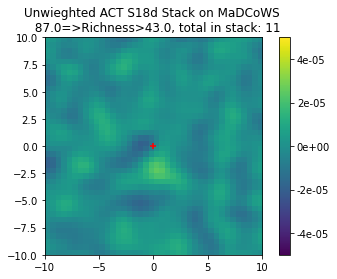

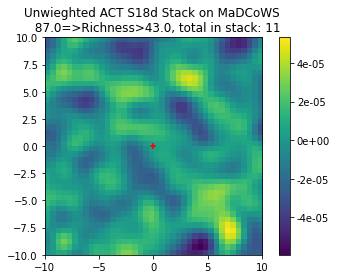

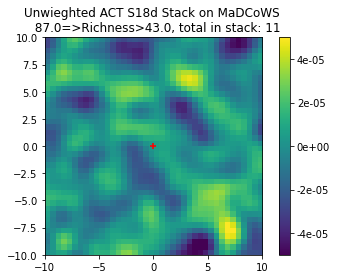

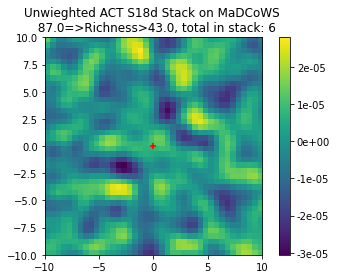

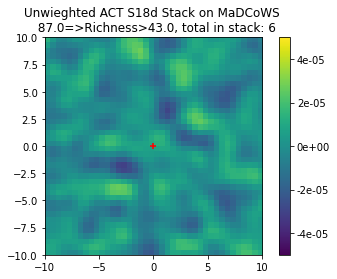

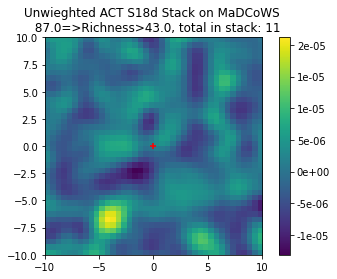

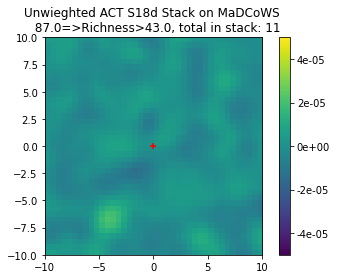

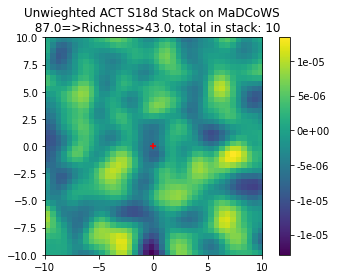

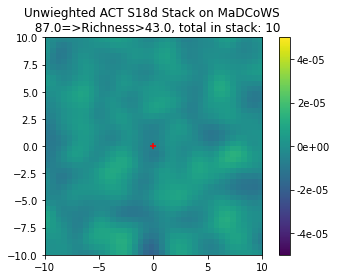

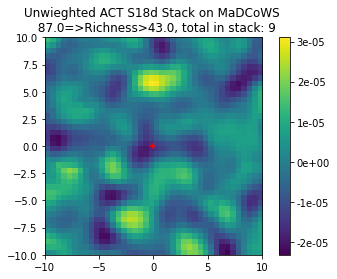

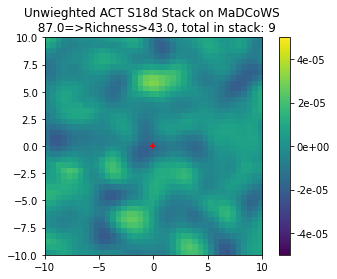

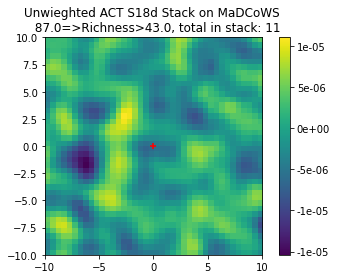

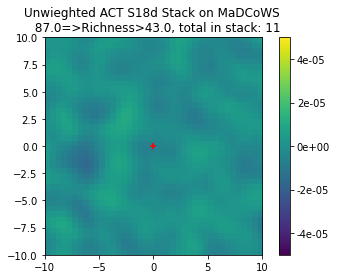

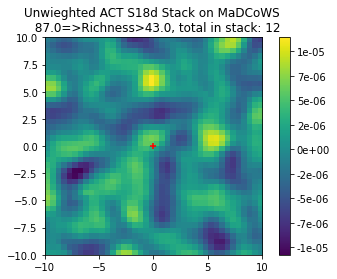

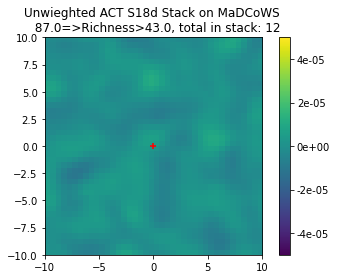

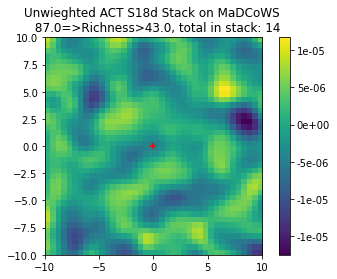

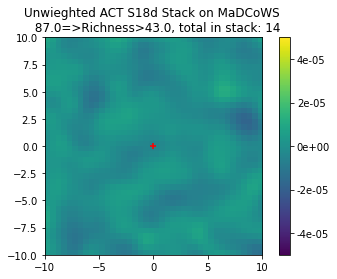

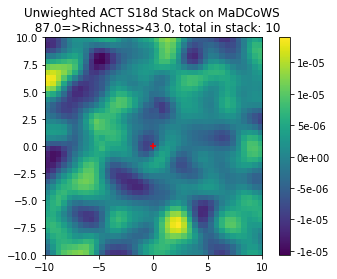

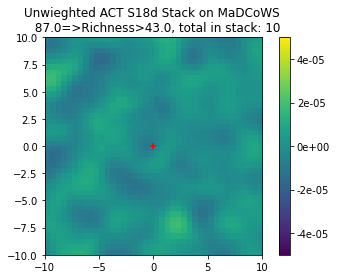

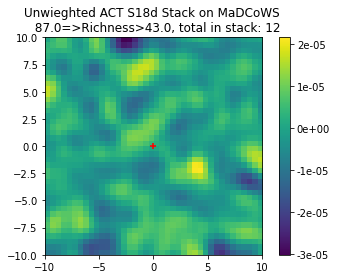

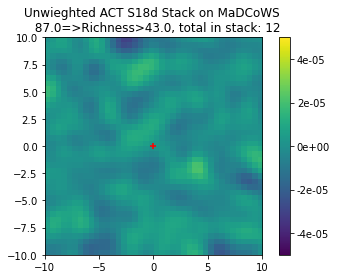

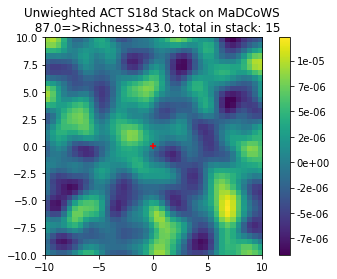

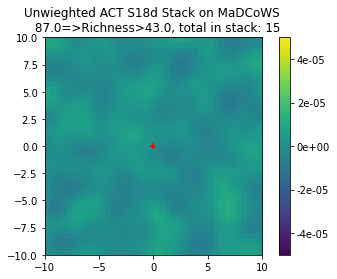

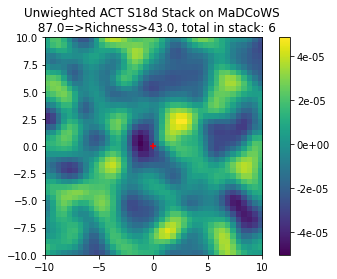

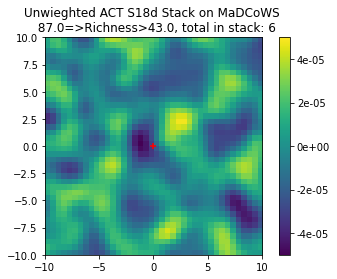

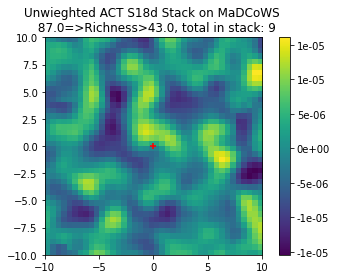

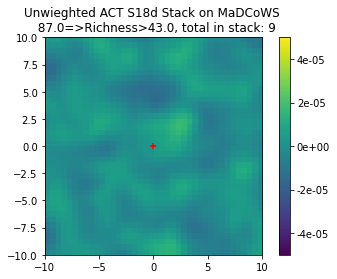

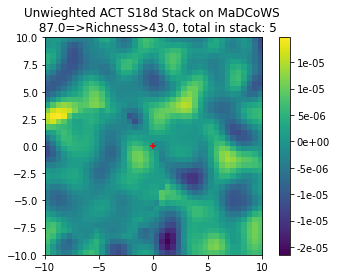

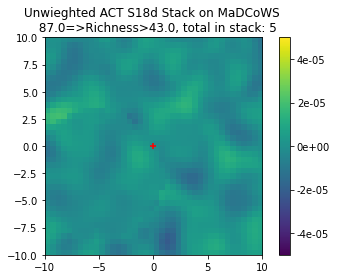

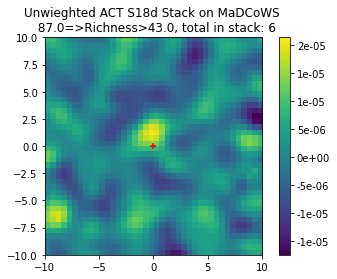

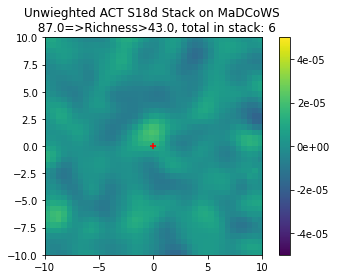

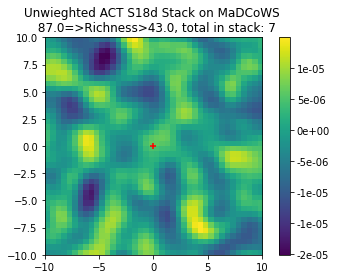

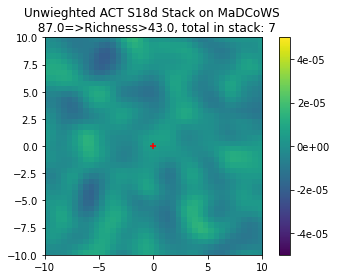

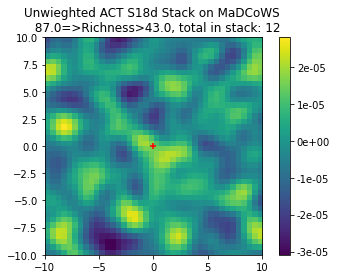

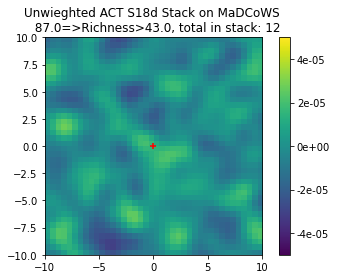

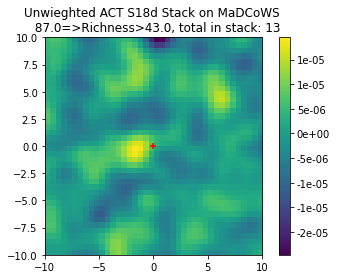

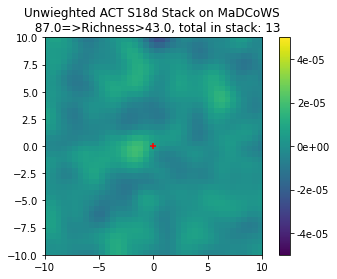

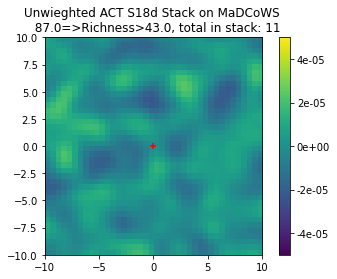

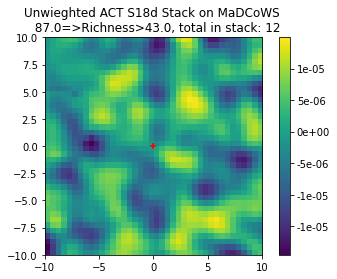

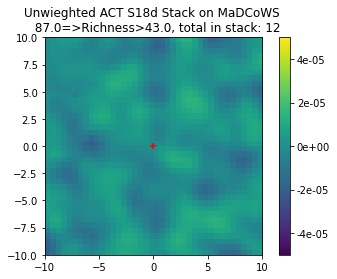

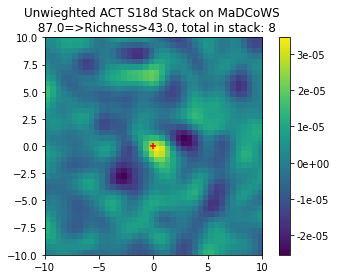

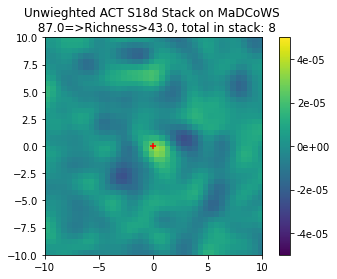

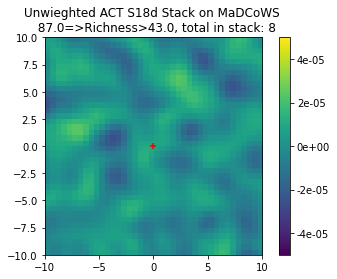

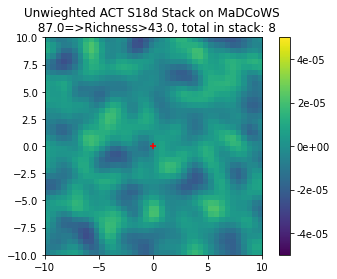

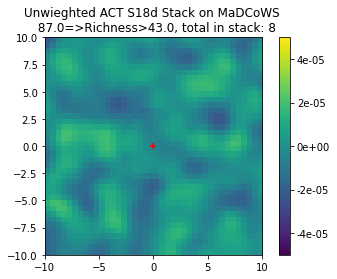

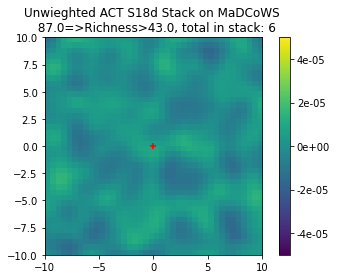

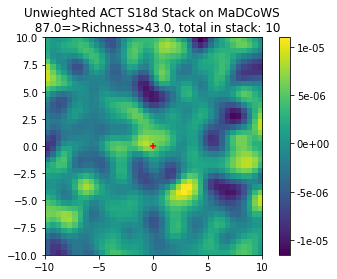

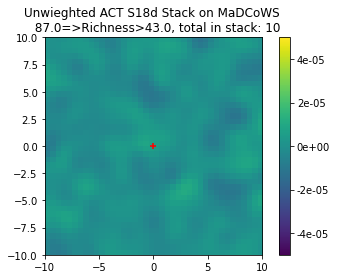

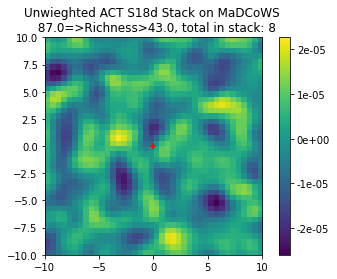

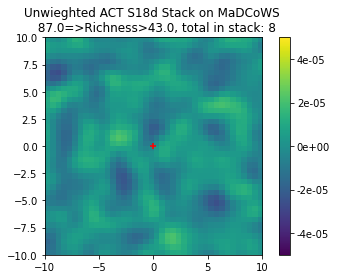

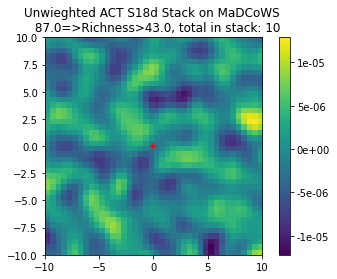

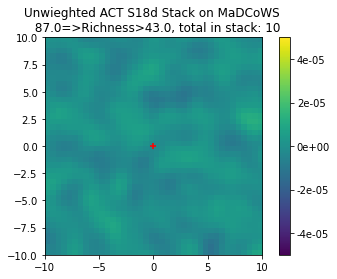

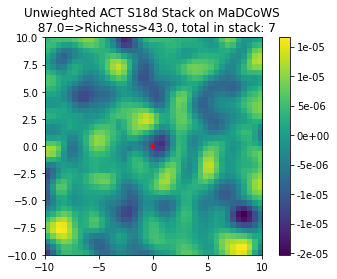

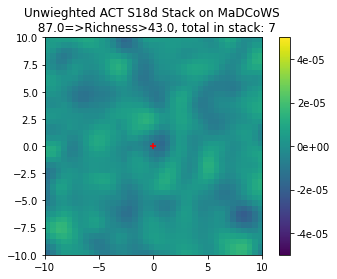

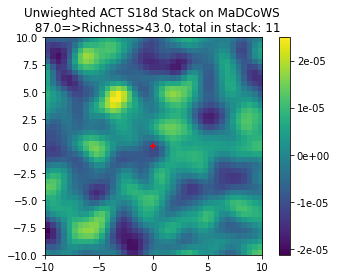

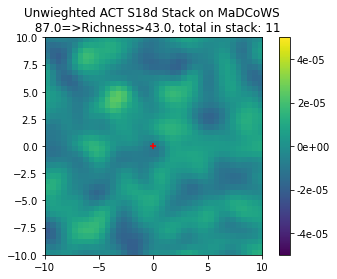

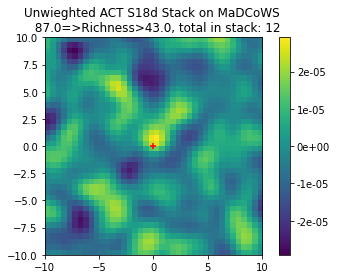

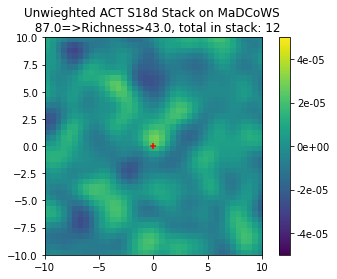

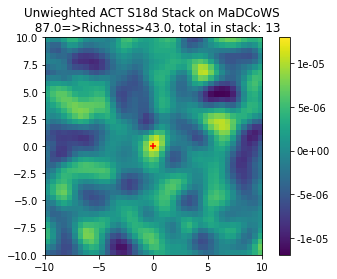

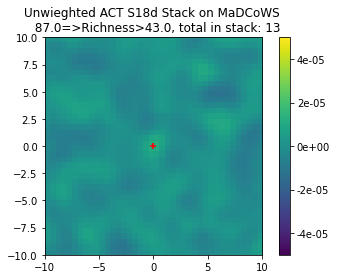

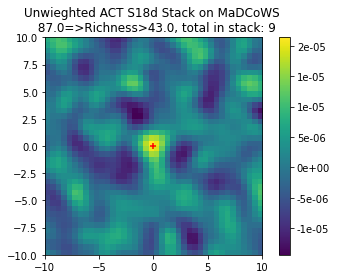

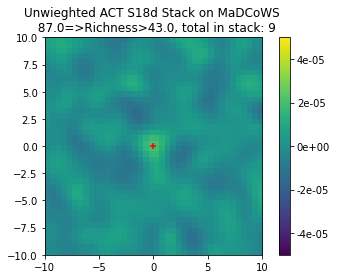

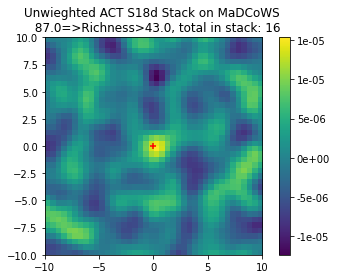

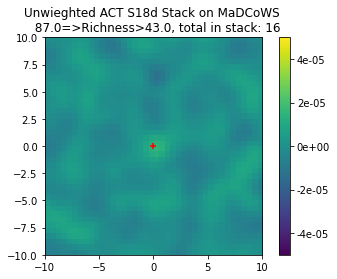

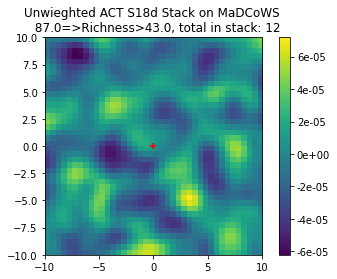

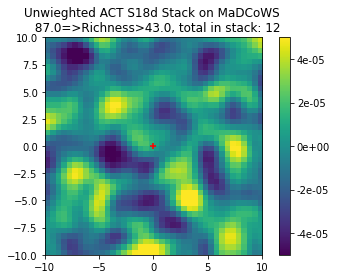

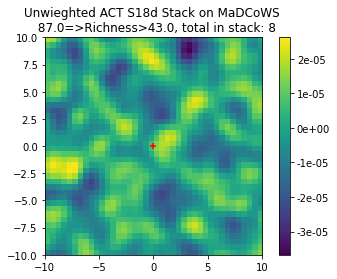

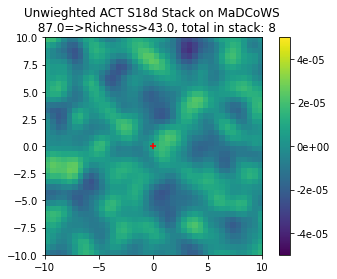

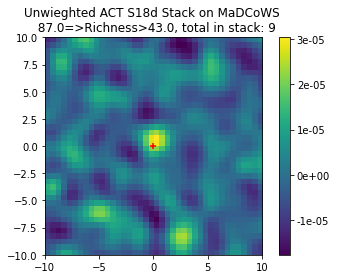

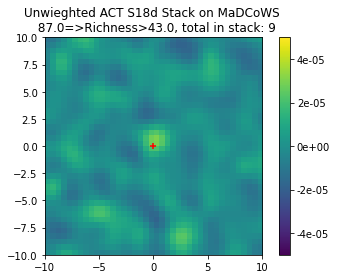

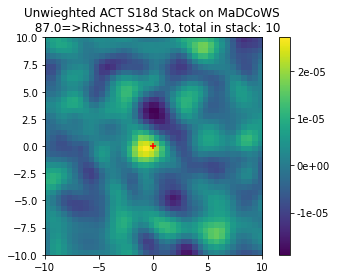

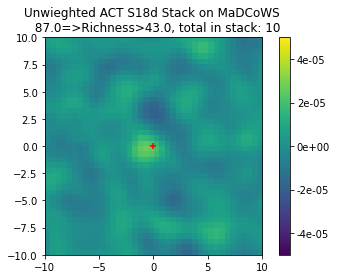

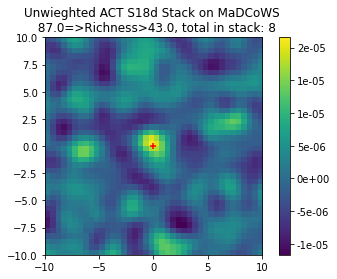

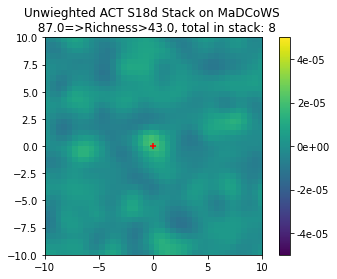

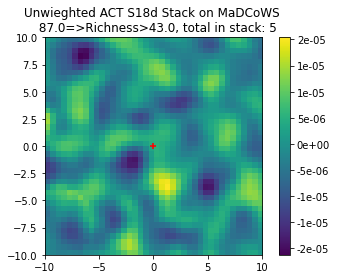

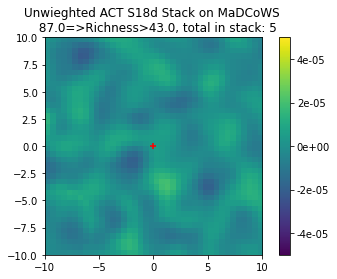

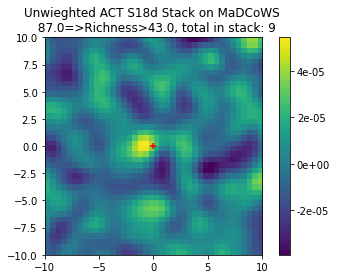

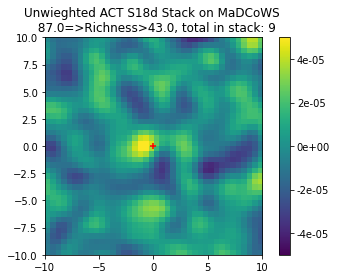

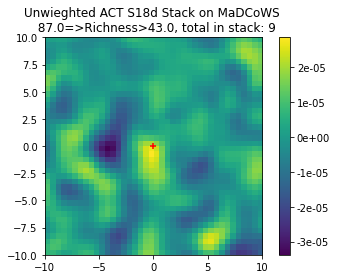

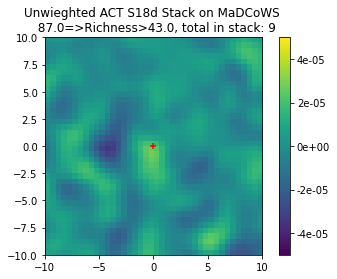

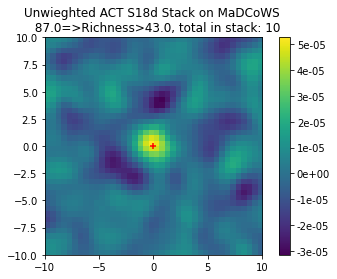

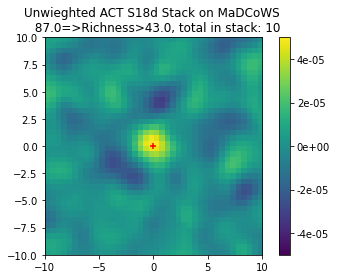

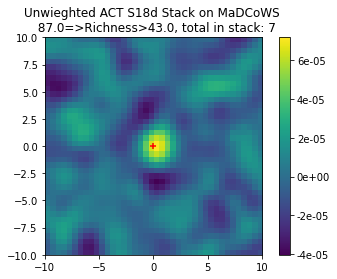

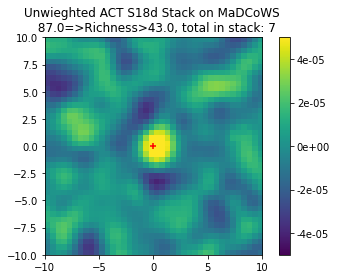

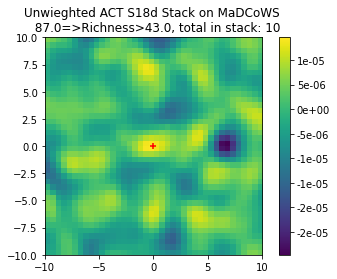

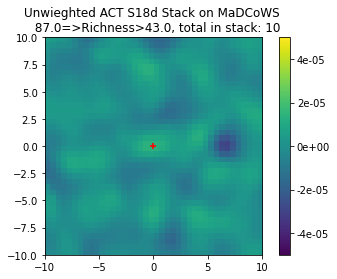

In [54]:
for key in zcut_dict:
    stack = zcut_dict[key][0]
    num = zcut_dict[key][1]
    width = 0.5*len(stack[0])/2
    
    plot = plt.imshow(stack, extent = [-width,width,-width,width])
    plt.scatter(0,0, marker = '+', color = 'r')
    #plt.clim(vmin, vmax);
    plt.colorbar(plot, format='%.0e')
    #plt.pcolor(X, Y, f(data), cmap=cm, vmin=-4, vmax=4)

    plt.title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], num))
    #plt.savefig('plots/inv_noise/rich_bin_{}_unnormed_weighted.pdf'.format(perc[i+1]))
    plt.show()
    plt.close()
    
    
    vmin, vmax = -5*10**-5, 5*10**-5
    plot = plt.imshow(stack,  extent = [-width,width,-width,width],vmin = vmin, vmax = vmax)
    plt.scatter(0,0, marker = '+', color = 'r')
    #plt.clim(vmin, vmax);
    plt.colorbar(plot, format='%.0e')
    #plt.pcolor(X, Y, f(data), cmap=cm, vmin=-4, vmax=4)

    plt.title("Unwieghted ACT S18d Stack on MaDCoWS \n  {}=>Richness>{}, total in stack: {}".format(perc[i+1], perc[i], num))
    #plt.savefig('plots/inv_noise/rich_bin_{}_normed_weighted.pdf'.format(perc[i+1]))
    plt.show()
    plt.close()

# Bootstraping 

In [78]:
#for stack in stacks:
    #print(np.amax(stack[18:22, 18:22]))
    
bootstraps = {}
for i in range(bins):
    
    bootstraps['{}'.format(i)] = []
    
    cut = np.where((rich>perc[i]) & (rich <= perc[i+1]))[0]
    
    ra_cut = ra[cut]
    dec_cut = dec[cut]
    rich_cut = rich[cut]
    names_cut = names[cut]
    for j in range(200):
        flags = np.random.randint(len(ra_cut), size = len(ra_cut))
        
        #print(flags)
        
        ra_temp = ra_cut[flags]
        dec_temp = dec_cut[flags]
        rich_temp = rich_cut[flags]
        names_temp = names_cut[flags]
        
        #print(ra_temp)
        
        stack, stack_num = s18dStack(ra_temp, dec_temp, s18d, weight = True)
    
        bootstraps['{}'.format(i)].append(stack)
        #stack_nums.append(stack_num)
        
        print(j)
pk.dump(bootstraps, open( "weighted_bootstraps.p", "wb" ))


Number in stack: 111
0
Number in stack: 111
1
Number in stack: 111
2
Number in stack: 111
3
Number in stack: 111
4
Number in stack: 111
5
Number in stack: 111
6
Number in stack: 111
7
Number in stack: 111
8
Number in stack: 111
9
Number in stack: 111
10
Number in stack: 111
11
Number in stack: 111
12
Number in stack: 111
13
Number in stack: 111
14
Number in stack: 111
15
Number in stack: 111
16
Number in stack: 111
17
Number in stack: 111
18
Number in stack: 111
19
Number in stack: 111
20
Number in stack: 111
21
Number in stack: 111
22
Number in stack: 111
23
Number in stack: 111
24
Number in stack: 111
25
Number in stack: 111
26
Number in stack: 111
27
Number in stack: 111
28
Number in stack: 111
29
Number in stack: 111
30
Number in stack: 111
31
Number in stack: 111
32
Number in stack: 111
33
Number in stack: 111
34
Number in stack: 111
35
Number in stack: 111
36
Number in stack: 111
37
Number in stack: 111
38
Number in stack: 111
39
Number in stack: 111
40
Number in stack: 111
41
Nu

Number in stack: 106
137
Number in stack: 106
138
Number in stack: 106
139
Number in stack: 106
140
Number in stack: 106
141
Number in stack: 106
142
Number in stack: 106
143
Number in stack: 106
144
Number in stack: 106
145
Number in stack: 106
146
Number in stack: 106
147
Number in stack: 106
148
Number in stack: 106
149
Number in stack: 106
150
Number in stack: 106
151
Number in stack: 106
152
Number in stack: 106
153
Number in stack: 106
154
Number in stack: 106
155
Number in stack: 106
156
Number in stack: 106
157
Number in stack: 106
158
Number in stack: 106
159
Number in stack: 106
160
Number in stack: 106
161
Number in stack: 106
162
Number in stack: 106
163
Number in stack: 106
164
Number in stack: 106
165
Number in stack: 106
166
Number in stack: 106
167
Number in stack: 106
168
Number in stack: 106
169
Number in stack: 106
170
Number in stack: 106
171
Number in stack: 106
172
Number in stack: 106
173
Number in stack: 106
174
Number in stack: 106
175
Number in stack: 106
176


Number in stack: 74
76
Number in stack: 74
77
Number in stack: 74
78
Number in stack: 74
79
Number in stack: 74
80
Number in stack: 74
81
Number in stack: 74
82
Number in stack: 74
83
Number in stack: 74
84
Number in stack: 74
85
Number in stack: 74
86
Number in stack: 74
87
Number in stack: 74
88
Number in stack: 74
89
Number in stack: 74
90
Number in stack: 74
91
Number in stack: 74
92
Number in stack: 74
93
Number in stack: 74
94
Number in stack: 74
95
Number in stack: 74
96
Number in stack: 74
97
Number in stack: 74
98
Number in stack: 74
99
Number in stack: 74
100
Number in stack: 74
101
Number in stack: 74
102
Number in stack: 74
103
Number in stack: 74
104
Number in stack: 74
105
Number in stack: 74
106
Number in stack: 74
107
Number in stack: 74
108
Number in stack: 74
109
Number in stack: 74
110
Number in stack: 74
111
Number in stack: 74
112
Number in stack: 74
113
Number in stack: 74
114
Number in stack: 74
115
Number in stack: 74
116
Number in stack: 74
117
Number in stack:

3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
9
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07 

Number in stack: 121
20
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07

Number in stack: 121
31
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
32
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.6326

Number in stack: 121
47
Number in stack: 121
48
Number in stack: 121
49
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
50
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e

3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
64
Number in stack: 121
65
Number in stack: 121
66
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9

Number in stack: 121
72
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
73
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.6326

Number in stack: 121
80
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
81
Number in stack: 121
82
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9

Number in stack: 121
87
Number in stack: 121
88
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.6326

Number in stack: 121
98
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
99
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.6326

3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
109
Number in stack: 121
110
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63

Number in stack: 121
118
Number in stack: 121
119
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
120
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06

Number in stack: 121
129
Number in stack: 121
130
Number in stack: 121
131
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06

Number in stack: 121
143
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-0

Number in stack: 121
154
Number in stack: 121
155
Number in stack: 121
156
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
157
Number in stack: 121
158
Number in stack: 121
159
Number in stack: 121
160
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.5

Number in stack: 121
168
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 121
169
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63

3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.

3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.36431357e-07
   9.26680718e-07  6.16932325e-07]
 ...
 [-1.07708599e-06 -2.20417463e-06 -2.83803638e-06 ...  7.66560581e-07
   5.11300214e-07 -6.17231556e-08]
 [-4.63541682e-07 -1.29824653e-06 -1.87580029e-06 ...  8.99601875e-07
   5.82618799e-07  2.21502833e-07]
 [-1.50598363e-08 -6.04037129e-07 -1.09981336e-06 ...  1.34174376e-06
   9.54024841e-07  5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
3_1_0
ndmap([[ 3.02442893e-07 -1.44052551e-07 -4.99107357e-07 ...  1.68750295e-06
   1.38042037e-06  8.51664067e-07]
 [ 5.49177759e-07  2.73158396e-07  1.06821380e-07 ...  1.54246363e-06
   1.42076961e-06  9.61853604e-07]
 [ 4.63262765e-07  4.57864496e-07  5.33337922e-07 ...  9.

Number in stack: 81
1
Number in stack: 81
2
Number in stack: 81
3
Number in stack: 81
4
Number in stack: 81
5
Number in stack: 81
6
Number in stack: 81
7
Number in stack: 81
8
Number in stack: 81
9
Number in stack: 81
10
Number in stack: 81
11
Number in stack: 81
12
Number in stack: 81
13
Number in stack: 81
14
Number in stack: 81
15
Number in stack: 81
16
Number in stack: 81
17
Number in stack: 81
18
Number in stack: 81
19
Number in stack: 81
20
Number in stack: 81
21
Number in stack: 81
22
Number in stack: 81
23
Number in stack: 81
24
Number in stack: 81
25
Number in stack: 81
26
Number in stack: 81
27
Number in stack: 81
28
Number in stack: 81
29
Number in stack: 81
30
Number in stack: 81
31
Number in stack: 81
32
Number in stack: 81
33
Number in stack: 81
34
Number in stack: 81
35
Number in stack: 81
36
Number in stack: 81
37
Number in stack: 81
38
Number in stack: 81
39
Number in stack: 81
40
Number in stack: 81
41
Number in stack: 81
42
Number in stack: 81
43
Number in stack: 81


Number in stack: 88
152
Number in stack: 88
153
Number in stack: 88
154
Number in stack: 88
155
Number in stack: 88
156
Number in stack: 88
157
Number in stack: 88
158
Number in stack: 88
159
Number in stack: 88
160
Number in stack: 88
161
Number in stack: 88
162
Number in stack: 88
163
Number in stack: 88
164
Number in stack: 88
165
Number in stack: 88
166
Number in stack: 88
167
Number in stack: 88
168
Number in stack: 88
169
Number in stack: 88
170
Number in stack: 88
171
Number in stack: 88
172
Number in stack: 88
173
Number in stack: 88
174
Number in stack: 88
175
Number in stack: 88
176
Number in stack: 88
177
Number in stack: 88
178
Number in stack: 88
179
Number in stack: 88
180
Number in stack: 88
181
Number in stack: 88
182
Number in stack: 88
183
Number in stack: 88
184
Number in stack: 88
185
Number in stack: 88
186
Number in stack: 88
187
Number in stack: 88
188
Number in stack: 88
189
Number in stack: 88
190
Number in stack: 88
191
Number in stack: 88
192
Number in stack:

Number in stack: 85
94
Number in stack: 85
95
Number in stack: 85
96
Number in stack: 85
97
Number in stack: 85
98
Number in stack: 85
99
Number in stack: 85
100
Number in stack: 85
101
Number in stack: 85
102
Number in stack: 85
103
Number in stack: 85
104
Number in stack: 85
105
Number in stack: 85
106
Number in stack: 85
107
Number in stack: 85
108
Number in stack: 85
109
Number in stack: 85
110
Number in stack: 85
111
Number in stack: 85
112
Number in stack: 85
113
Number in stack: 85
114
Number in stack: 85
115
Number in stack: 85
116
Number in stack: 85
117
Number in stack: 85
118
Number in stack: 85
119
Number in stack: 85
120
Number in stack: 85
121
Number in stack: 85
122
Number in stack: 85
123
Number in stack: 85
124
Number in stack: 85
125
Number in stack: 85
126
Number in stack: 85
127
Number in stack: 85
128
Number in stack: 85
129
Number in stack: 85
130
Number in stack: 85
131
Number in stack: 85
132
Number in stack: 85
133
Number in stack: 85
134
Number in stack: 85
13

In [116]:
xspline = np.linspace(-10, 10, 40)
yspline = xspline

rbin = np.linspace(0, np.sqrt(2)*max(xspline), 20)


bin_dict = {}
for key in bootstraps:
    stacks = bootstraps[key]
    bin_dict['rich_bin_{}_{}'.format(perc[int(key)], perc[int(key)+1])] = {}
    bin_dict['rich_bin_{}_{}'.format(perc[int(key)], perc[int(key)+1])]['stacks'] = []
    for i in range(len(stacks)):
        stack = stacks[i]
        stack_r_mean, stack_bin_data, c, d = binmap(stack,xspline,yspline,rbin)
        bin_dict['rich_bin_{}_{}'.format(perc[int(key)], perc[int(key)+1])]['stacks'].append(stack_bin_data)
        bin_dict['rich_bin_{}_{}'.format(perc[int(key)], perc[int(key)+1])]['r_mean'] = stack_r_mean
    





ndmap([[-2.78140841e-06 -1.14407643e-06  8.72687264e-07 ... -6.47649524e-07
  -6.04960838e-07 -1.33927557e-06]
 [-2.90502085e-06 -1.70423376e-06 -3.67538865e-07 ... -1.51591456e-06
  -1.65369261e-06 -1.79334219e-06]
 [-2.87134975e-06 -1.89912428e-06 -8.31093282e-07 ... -1.67154422e-06
  -2.23210661e-06 -2.28846340e-06]
 ...
 [ 1.01063618e-06  9.21826962e-07  7.09887329e-07 ...  1.28410490e-06
   6.19837097e-07  5.34250032e-07]
 [ 7.28286960e-07  2.20713730e-07  1.75956409e-07 ...  2.05445527e-06
   1.78128843e-06  1.93417022e-06]
 [ 2.67329258e-07 -7.24125318e-07 -7.61828776e-07 ...  1.90964242e-06
   1.79344063e-06  1.94277210e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-4.75072253e-06 -3.03097827e-06 -9.38087931e-07 ...  4.39014508e-07
   1.94106322e-06  3.55079684e-06]
 [-4.03695276e-06 -2.85296856e-06 -1.96292027e-06 ... -9.34987915e-07
  -6.03646517e-07  5.14893009e-07]
 [-3.89892139e-06 -3.19301189e-06 -3.16278606e-06 ... -2.41913948e-06
  -3.0603

ndmap([[ 7.52739729e-06  1.69108094e-05  2.06316056e-05 ... -2.07244352e-06
  -5.50901244e-06 -4.87584724e-06]
 [ 7.15367213e-06  1.39404760e-05  1.36827031e-05 ... -1.63744607e-05
  -1.67151025e-05 -1.18611724e-05]
 [ 4.02385001e-06  8.43008348e-06  5.56821657e-06 ... -2.08806359e-05
  -1.82053149e-05 -1.12909367e-05]
 ...
 [ 5.35355010e-06 -3.89711816e-07 -4.95054430e-06 ... -7.88530239e-06
  -1.50591889e-06  8.39629846e-06]
 [-1.41025329e-06 -2.01252477e-06  4.77286060e-07 ... -1.18982624e-05
  -8.02171565e-06 -9.03640004e-07]
 [-6.71089437e-06 -6.68984253e-06 -1.76147823e-06 ... -9.62596194e-06
  -9.03031231e-06 -5.88416949e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 9.16742567e-07  1.23069091e-06  1.19273497e-06 ...  9.40675800e-07
   1.64639852e-07 -9.94469008e-07]
 [-2.11132222e-07 -4.60049257e-07 -1.17477482e-06 ...  5.17096617e-07
  -8.45405599e-08 -8.96492874e-07]
 [-1.20309924e-06 -1.92291971e-06 -3.04551814e-06 ...  4.24182182e-08
  -1.3762

ndmap([[ 2.76175593e-06  7.96525535e-06  1.06943336e-05 ... -1.46416310e-07
  -2.00534522e-06 -3.54529540e-06]
 [ 1.10365953e-06  6.84081003e-06  1.04636471e-05 ...  1.88186186e-06
  -4.60803009e-07 -1.70772580e-06]
 [-1.22409569e-06  3.77452729e-06  7.69446614e-06 ...  2.92420173e-06
   1.12773440e-07 -1.30596355e-06]
 ...
 [ 2.53755175e-06 -2.01065041e-06 -5.82625351e-06 ... -1.30714009e-06
  -5.05782817e-06 -5.52572621e-06]
 [-1.89742108e-06 -5.23811620e-06 -7.79418580e-06 ...  2.06159474e-06
  -3.26221005e-06 -5.25698220e-06]
 [-4.90057514e-06 -7.03796044e-06 -8.08249694e-06 ...  3.70153655e-06
  -2.26881373e-06 -5.42912658e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-4.73711519e-06 -2.02966488e-06  2.62076288e-08 ...  3.86804933e-06
   3.04133695e-06  5.87072532e-07]
 [-5.84028462e-06 -3.84174979e-06 -1.45664573e-06 ...  3.38854830e-06
   2.90486973e-06  1.11780392e-06]
 [-5.35056478e-06 -4.17061475e-06 -1.99640577e-06 ...  2.36357335e-06
   2.0161

ndmap([[-1.82975817e-06  4.46809806e-06  7.11558636e-06 ... -7.21948106e-06
  -7.71574375e-06 -5.32781715e-06]
 [ 1.47696682e-06  6.76011002e-06  7.68267151e-06 ... -9.36703689e-06
  -1.04661134e-05 -7.33793837e-06]
 [ 5.36973631e-06  1.07976579e-05  1.09862875e-05 ... -9.99721939e-06
  -1.15148763e-05 -7.78643536e-06]
 ...
 [-5.37140459e-07  1.02167846e-06  2.96534749e-06 ...  1.76120536e-06
  -3.02381823e-06 -4.73450418e-06]
 [ 6.01913104e-07  3.07184233e-06  5.31329286e-06 ...  2.27088698e-06
  -4.73612747e-06 -8.16442770e-06]
 [ 2.07430862e-06  5.09134530e-06  7.40182669e-06 ...  7.51810178e-07
  -6.40816863e-06 -9.94929507e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-6.11427470e-06 -1.16956102e-05 -1.10996144e-05 ... -3.16331060e-06
  -6.25495785e-06 -8.04626668e-06]
 [-2.13328147e-05 -2.75389667e-05 -2.60326922e-05 ... -7.54389528e-06
  -1.15524983e-05 -1.08146693e-05]
 [-2.90586305e-05 -3.18820759e-05 -2.86511648e-05 ... -1.38912755e-05
  -1.8541

ndmap([[ 2.14321125e-06 -5.83826707e-08 -2.06962034e-06 ... -1.02823329e-05
  -1.47900757e-05 -1.43166196e-05]
 [ 1.60198945e-06 -4.36794370e-07 -2.79653097e-06 ... -1.39890648e-05
  -1.90151592e-05 -1.73443235e-05]
 [-8.26867603e-07 -1.78978398e-06 -4.11838102e-06 ... -1.29626291e-05
  -1.82224082e-05 -1.70892150e-05]
 ...
 [ 2.36055082e-06  4.33171526e-06  5.14383202e-06 ...  8.08551889e-06
   7.23569311e-06  6.42707902e-06]
 [ 4.46694348e-06  3.31595295e-06  1.98010671e-06 ...  1.25398546e-05
   1.15477181e-05  1.02118151e-05]
 [ 3.84513436e-06 -1.56226071e-07 -3.22575953e-06 ...  1.65346227e-05
   1.63458333e-05  1.44402240e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 2.93623400e-06  2.82358735e-06  2.50476903e-06 ... -2.31579283e-06
  -4.23202961e-06 -7.03539593e-06]
 [ 2.80728185e-06  2.89686605e-06  3.02171708e-06 ... -2.80865578e-07
  -3.48837420e-06 -7.57948981e-06]
 [ 3.19040526e-06  2.00027391e-06  6.43349479e-07 ...  3.11233735e-06
  -2.3889

ndmap([[-3.38267106e-07  1.51197883e-06  2.87441578e-06 ... -7.69262159e-07
  -3.05554098e-06 -4.68714935e-06]
 [-1.44748721e-06  7.73892395e-08  9.87778180e-07 ... -2.88587015e-06
  -5.03488433e-06 -6.11763609e-06]
 [-1.09874452e-06 -2.61014025e-08 -5.43265589e-08 ... -3.74442849e-06
  -5.60424834e-06 -6.45919320e-06]
 ...
 [ 2.51461949e-06  2.11592576e-06  1.44389501e-06 ...  7.32679041e-07
  -4.85867769e-07 -8.19076266e-07]
 [ 2.50026676e-07  6.62334988e-07  1.07054422e-06 ...  1.71855721e-07
  -6.12429694e-07 -2.98360617e-07]
 [-2.26678011e-06 -1.37604375e-06 -2.51642301e-07 ...  4.14918107e-07
  -1.60531950e-07 -3.30836626e-08]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.07725567e-06  2.60324558e-06  4.04331933e-06 ...  1.96466834e-06
   2.28150794e-06  2.24719415e-06]
 [-1.89623728e-06  1.07634856e-06  1.45138442e-06 ...  2.29539088e-07
   1.65194064e-06  2.71115825e-06]
 [-2.24719484e-06 -2.56601584e-07 -4.89297129e-07 ... -1.65823230e-06
   7.9998

ndmap([[ 3.51135074e-06  9.24867067e-06  1.43352056e-05 ...  1.12168401e-06
   7.69624805e-07 -4.54900978e-07]
 [ 2.55521038e-06  8.63922928e-06  1.44121563e-05 ...  3.37292268e-06
   2.37049496e-06  3.75949443e-07]
 [-1.33461222e-06  3.71857595e-06  9.26718460e-06 ...  6.70570606e-06
   4.67820731e-06  1.80716627e-06]
 ...
 [ 8.23265539e-06  7.08603217e-06  5.11554985e-06 ... -2.34629801e-06
  -4.79816502e-06 -5.88717742e-06]
 [ 7.76129821e-06  7.64043035e-06  6.65832303e-06 ... -4.18514768e-06
  -4.44397906e-06 -3.48010061e-06]
 [ 5.66643346e-06  6.55642449e-06  6.45124081e-06 ... -5.27190714e-06
  -2.72412598e-06  7.83361181e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-2.98528200e-06 -1.63873889e-06  9.08896615e-07 ...  1.01737949e-06
   3.27622393e-06  4.09599354e-06]
 [-2.19129365e-06 -1.10047733e-06  8.40687119e-07 ...  2.51991093e-06
   5.06127264e-06  6.28622803e-06]
 [-1.77969732e-06 -9.15941171e-07  3.74288118e-07 ...  4.02461777e-06
   6.3007

ndmap([[ 1.20891961e-06  5.11462930e-06  8.26149926e-06 ... -4.04127663e-06
  -4.18752085e-06 -4.35730188e-06]
 [ 1.94136905e-06  5.81945077e-06  8.96257818e-06 ... -3.44236813e-06
  -4.16731244e-06 -3.70565737e-06]
 [ 3.57321962e-07  3.35370373e-06  6.69148342e-06 ... -1.86274113e-06
  -3.39202123e-06 -3.01052783e-06]
 ...
 [ 6.22832200e-06  7.15656098e-06  6.41828736e-06 ... -2.50028845e-06
  -1.73202899e-06 -2.54885956e-06]
 [ 2.49086779e-06  3.60592504e-06  4.15909892e-06 ... -1.87807597e-06
  -9.88585335e-07 -2.74537341e-06]
 [-1.00045517e-06  1.24800462e-06  3.31666333e-06 ...  1.39139381e-06
   1.79610554e-06 -1.02286424e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-2.55597211e-06 -2.19424899e-06 -1.29807321e-06 ...  3.43764961e-06
  -3.31773249e-06 -1.16862192e-05]
 [-1.48011155e-07 -4.03063207e-07 -6.69797795e-07 ...  4.06742784e-06
  -3.63546078e-06 -1.32179764e-05]
 [ 8.70171330e-06  5.54419542e-06 -4.93658394e-08 ...  7.13491323e-06
  -1.9714

ndmap([[-1.65994817e-06 -3.80759469e-06 -4.18441022e-06 ... -3.72458019e-06
  -4.31211939e-06 -4.97776214e-06]
 [-7.30076290e-06 -9.37018150e-06 -8.21451295e-06 ... -4.25966969e-06
  -5.63695378e-06 -6.24875033e-06]
 [-9.41127338e-06 -1.09880733e-05 -8.96491818e-06 ... -6.26891833e-06
  -7.83425251e-06 -8.01538261e-06]
 ...
 [-6.73323928e-06 -6.87574638e-06 -5.13127724e-06 ... -2.07061903e-05
  -2.44068095e-05 -2.24379725e-05]
 [-3.30681418e-06 -3.51989726e-06 -2.29131172e-06 ... -1.80262112e-05
  -2.08615681e-05 -1.84679853e-05]
 [-6.44650680e-07 -4.38211134e-07  2.99843731e-07 ... -1.25265845e-05
  -1.39772860e-05 -1.12668275e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 5.84402664e-06  6.80633667e-06  6.84300447e-06 ... -1.58475268e-06
  -1.99953766e-06 -1.31724304e-06]
 [ 3.77923205e-06  4.26958801e-06  4.01442102e-06 ... -3.41597153e-06
  -4.22778510e-06 -3.42006194e-06]
 [ 7.49802381e-07  4.85496494e-07 -1.05559381e-07 ... -5.33133332e-06
  -6.3369

ndmap([[-4.65705646e-07  6.53177065e-07  1.63681639e-06 ...  1.07852439e-06
   7.81730281e-07  1.07762383e-07]
 [-1.68772241e-06 -5.15564199e-07  4.07067284e-07 ... -2.12914438e-07
  -8.65075661e-07 -1.42153452e-06]
 [-2.82007717e-06 -1.73497030e-06 -8.91359302e-07 ... -7.22166700e-07
  -1.78163872e-06 -2.63634022e-06]
 ...
 [ 2.85384521e-07 -5.10036913e-07 -3.41417604e-07 ... -1.87292114e-06
  -2.88221041e-06 -2.50221370e-06]
 [-1.87598497e-06 -2.71917607e-06 -2.10273962e-06 ... -1.01728296e-06
  -2.36902756e-06 -2.13190367e-06]
 [-2.72178724e-06 -3.52113166e-06 -2.88960276e-06 ...  4.22948894e-07
  -9.41898191e-07 -1.04291827e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.24275438e-06  1.51245075e-06  2.15438493e-06 ... -1.86270108e-06
  -2.41267056e-06 -3.26557296e-06]
 [-7.37560184e-07 -1.85518974e-07  7.24317259e-07 ... -3.00970578e-06
  -3.96679717e-06 -4.68919177e-06]
 [-1.84543633e-06 -1.33037217e-06 -6.54360466e-07 ... -2.61773090e-06
  -4.2675

ndmap([[-3.60607217e-06 -2.13485157e-06 -5.36810163e-07 ...  7.31821070e-07
   4.61560750e-07 -8.41265536e-08]
 [-3.95867293e-06 -2.90348331e-06 -1.84180870e-06 ...  1.58834080e-06
   1.09002168e-06  4.55764113e-07]
 [-3.91594095e-06 -3.61153173e-06 -3.23727285e-06 ...  2.10349614e-06
   1.35806049e-06  5.01695627e-07]
 ...
 [-1.23087143e-06 -9.91296209e-07 -1.07743704e-06 ... -2.35559767e-06
  -3.09477544e-06 -2.42071309e-06]
 [-3.06596412e-06 -2.67116435e-06 -1.93833690e-06 ... -1.20032424e-06
  -2.22489473e-06 -1.81215090e-06]
 [-4.08973235e-06 -3.32594498e-06 -2.01374211e-06 ...  3.35425032e-07
  -8.17065389e-07 -9.51190967e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 7.18863653e-06  8.75688236e-06  7.37207688e-06 ... -3.39178344e-06
  -5.54362029e-06 -6.94221153e-06]
 [ 4.81835477e-06  5.88306456e-06  3.86871647e-06 ... -7.45357224e-06
  -8.66874997e-06 -8.39606435e-06]
 [ 9.73760754e-07  1.79967349e-06 -2.11978154e-07 ... -7.50594096e-06
  -8.5431

ndmap([[ 1.35636482e-06  2.53366830e-07 -1.69209121e-06 ... -3.04732206e-06
  -3.44017531e-06 -2.25224201e-06]
 [-1.17984045e-07 -1.16741102e-06 -2.42947621e-06 ... -1.80895828e-06
  -2.10396171e-06 -1.24303908e-06]
 [-1.20407046e-06 -2.30291401e-06 -3.05784307e-06 ... -1.21088134e-06
  -1.69982916e-06 -1.28566259e-06]
 ...
 [ 8.49093786e-07  1.89809445e-06  1.21707096e-06 ...  1.69253056e-06
  -7.18128319e-07 -1.97598270e-06]
 [ 2.96243085e-06  3.34113433e-06  4.40118309e-06 ...  1.58527738e-06
   1.12260901e-07 -6.56437242e-07]
 [ 4.18683861e-06  4.56961274e-06  4.51197167e-06 ...  7.08516182e-07
  -1.49650923e-08 -2.71673009e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-6.15796066e-07 -2.28600779e-06 -3.16986470e-06 ... -7.12697553e-06
  -6.11347455e-06 -4.25798729e-06]
 [-1.91623055e-06 -3.47279211e-06 -4.56328102e-06 ... -9.15761710e-06
  -7.32176952e-06 -4.90120591e-06]
 [-2.15594062e-06 -4.15704839e-06 -5.75992741e-06 ... -9.46693953e-06
  -7.8889

ndmap([[-1.89897947e-06 -3.32484591e-06 -3.50375407e-06 ...  3.74465709e-07
   1.39246871e-06  1.03904512e-06]
 [-1.25050902e-07 -2.79616660e-06 -4.30329934e-06 ...  1.94777369e-06
   3.14934647e-06  3.27034761e-06]
 [ 1.67306325e-07 -3.25945206e-06 -5.55871499e-06 ...  2.65997109e-06
   3.57004555e-06  4.04282634e-06]
 ...
 [ 7.15059132e-07  8.27261802e-07  1.57097648e-06 ...  5.60474414e-06
   5.51540672e-07 -3.74210820e-06]
 [ 1.36760600e-06  1.35532222e-06  2.10471109e-06 ...  2.01238603e-06
  -1.30315235e-06 -3.89541505e-06]
 [ 4.23355786e-07  6.16339826e-07  1.31788610e-06 ... -1.43474189e-07
  -1.58970194e-06 -3.21689185e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 7.96562801e-06  9.42142110e-06  9.41630021e-06 ... -3.00206175e-06
  -2.11016706e-06 -7.29606637e-07]
 [ 5.28638179e-06  6.50529781e-06  6.73414037e-06 ... -2.73534135e-06
  -1.86773156e-06 -3.41976118e-07]
 [ 1.11903953e-06  1.66016003e-06  2.13807055e-06 ... -2.43008598e-06
  -1.9726

ndmap([[ 7.68058762e-06  7.10037732e-06  4.46066373e-06 ...  2.30426593e-06
   7.72311793e-06  9.23671322e-06]
 [ 4.95016368e-06  1.35313041e-06 -2.83040617e-06 ... -7.54054930e-07
   3.76713695e-06  5.39022350e-06]
 [ 1.61243864e-06 -4.13043334e-06 -9.28921156e-06 ... -3.88973179e-06
  -1.52201374e-06 -9.03421759e-07]
 ...
 [ 1.48982036e-05  1.49403735e-05  1.68438703e-05 ...  1.23118281e-05
   6.73061635e-06 -2.27424988e-06]
 [ 7.11614392e-06  1.00227137e-05  1.48061807e-05 ...  1.29669313e-05
   7.06590188e-06 -1.98598296e-06]
 [-2.78828605e-06  2.61416929e-06  1.02565080e-05 ...  1.04752032e-05
   5.36187955e-06 -1.88814785e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 8.22730646e-07  2.04879998e-07 -1.65423134e-06 ... -4.14621735e-06
  -5.47238873e-06 -5.31206063e-06]
 [ 3.81781645e-07  3.06552057e-07 -1.13692253e-06 ... -9.48516674e-07
  -3.14403671e-06 -4.05645326e-06]
 [ 4.51809941e-08  6.91624004e-07 -1.29573845e-07 ...  1.76754006e-06
  -9.8219

ndmap([[-4.33564169e-07 -1.39056752e-06 -1.77599973e-06 ... -3.31091788e-06
  -3.28087842e-06 -2.36250117e-06]
 [-6.39493958e-07 -1.45805817e-06 -1.85801209e-06 ... -5.21263482e-06
  -4.93282042e-06 -3.97851074e-06]
 [-4.62729074e-07 -1.13617544e-06 -1.57085901e-06 ... -6.45019221e-06
  -5.99422624e-06 -4.90609688e-06]
 ...
 [-9.40507319e-07 -9.08723532e-07 -4.67324872e-07 ...  7.98505477e-07
   5.06436636e-07  5.33732885e-07]
 [ 2.13370198e-06  2.41600936e-06  2.03131369e-06 ... -5.34599143e-07
  -4.15510353e-07 -1.58498095e-07]
 [ 4.76538412e-06  5.09035529e-06  3.87993658e-06 ... -2.06786778e-06
  -1.71024010e-06 -1.45087173e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-3.00533472e-06 -5.93141598e-06 -6.71529649e-06 ...  5.23218445e-06
  -3.11727981e-08 -3.88057418e-06]
 [-5.71628259e-07 -2.99105340e-06 -3.76507582e-06 ...  7.42080799e-06
   1.84354951e-06 -2.37250202e-06]
 [ 4.44155682e-07 -1.04017495e-06 -1.77047507e-06 ...  7.55795295e-06
   2.3673

ndmap([[-2.55396192e-06 -5.61414679e-06 -5.54879763e-06 ...  1.75588034e-06
   1.91969805e-06  2.51810797e-06]
 [-4.69739307e-06 -6.18443050e-06 -4.51655178e-06 ...  9.35694365e-07
   1.35862477e-06  1.63136802e-06]
 [-5.65256785e-06 -5.48128379e-06 -2.82330046e-06 ... -4.74686218e-07
  -1.05952029e-06 -1.20426712e-06]
 ...
 [-2.13411496e-06 -1.18206945e-06 -1.11026887e-06 ... -3.55144062e-06
  -5.25142973e-06 -3.93034249e-06]
 [-3.07945263e-06 -2.34744786e-06 -2.03451430e-06 ... -4.33513199e-06
  -4.74122948e-06 -2.14750364e-06]
 [-3.81818949e-06 -3.32744264e-06 -3.04836893e-06 ... -5.35076098e-06
  -3.93813466e-06 -4.06239674e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-2.71369567e-06 -3.58536659e-06 -3.45173822e-06 ...  4.16448439e-06
   1.21047263e-08 -4.64982641e-06]
 [-1.17990096e-06 -1.68421589e-06 -1.52488197e-06 ...  5.83224304e-06
   1.71475484e-06 -3.52944852e-06]
 [ 5.05354772e-07  4.79152365e-07  7.10831072e-07 ...  6.43919042e-06
   3.4089

ndmap([[ 4.68602779e-06  3.27916506e-06  2.10248607e-06 ...  2.34201559e-06
  -5.64901899e-06 -1.24024512e-05]
 [ 4.46171419e-08 -2.97902149e-06 -5.14947576e-06 ...  2.66132306e-06
  -5.60862562e-06 -1.35427226e-05]
 [-1.71834663e-06 -6.26454694e-06 -9.20473387e-06 ...  6.31275020e-06
  -8.62779837e-07 -9.32046961e-06]
 ...
 [-4.24174500e-06 -2.23343800e-06  1.07229255e-06 ... -2.00253018e-06
  -4.34330491e-07  8.69855548e-07]
 [-2.68596480e-06 -1.27302619e-06 -1.10319727e-07 ...  1.87834801e-06
   3.07339094e-06  3.82093078e-06]
 [-5.50859825e-07 -2.81845022e-07 -1.15384868e-06 ...  4.59557189e-06
   5.99498484e-06  6.15479894e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 4.56024844e-06  4.26218655e-06  2.22620555e-06 ...  3.68090756e-06
   4.07393351e-06  3.33096807e-06]
 [ 1.93341375e-06  7.60553832e-07 -1.25303661e-06 ...  5.80176830e-06
   5.38286333e-06  3.12683409e-06]
 [ 1.58900568e-07 -2.51229307e-06 -4.80199257e-06 ...  5.32377305e-06
   5.2295

ndmap([[ 5.34486891e-08 -3.99851598e-07 -3.88835876e-07 ... -7.79373864e-07
  -3.41769915e-06 -4.90811541e-06]
 [ 1.23246538e-06  6.74797596e-07  1.23607381e-07 ...  6.55282526e-07
  -2.44537772e-06 -4.08309693e-06]
 [ 7.04292440e-07  4.40863010e-07  1.62535332e-07 ...  2.04284472e-06
  -1.16525092e-06 -2.82163734e-06]
 ...
 [ 3.01166462e-06  4.15851146e-06  2.54733513e-06 ...  3.63865372e-06
   1.52735295e-06  1.61686600e-07]
 [ 2.47717566e-06  3.40756938e-06  3.80220944e-06 ...  2.92508225e-06
   1.02512058e-06 -7.26769710e-07]
 [ 1.78009177e-06  3.16523414e-06  3.54755926e-06 ...  1.46686593e-06
   1.44637582e-08 -1.71140236e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.80073097e-06 -8.99420713e-07 -6.47520589e-07 ... -2.79380148e-06
  -4.03382371e-06 -3.74413894e-06]
 [-1.72828241e-06 -7.20125172e-07 -2.19030168e-07 ... -2.56853941e-06
  -3.11850271e-06 -2.22726647e-06]
 [-9.45418411e-07  8.76501858e-08  7.72335066e-07 ... -1.55475261e-06
  -1.8905

ndmap([[-5.55822794e-06 -1.85543895e-06  2.72060602e-06 ... -1.05620339e-06
  -4.83200656e-06 -8.38556723e-06]
 [-8.12519493e-06 -5.69233165e-06 -3.17023175e-06 ... -1.82953530e-06
  -3.23833626e-06 -5.99884930e-06]
 [-8.65025212e-06 -7.74632858e-06 -6.34407668e-06 ... -2.47671789e-06
  -1.46445064e-06 -2.85989463e-06]
 ...
 [ 4.45458913e-07 -2.14972206e-06 -5.24281693e-06 ...  1.61555908e-06
  -3.38045613e-07 -2.63514685e-06]
 [ 3.36048060e-06  3.36536322e-06  2.06247804e-06 ...  4.70833289e-06
   2.88562162e-06  8.66435137e-07]
 [ 5.43819415e-06  7.41844292e-06  7.72501611e-06 ...  6.34398065e-06
   5.61948691e-06  4.89693522e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 5.14220039e-07  6.38512481e-08 -1.00278986e-07 ... -4.20557764e-07
   6.52312015e-07  1.31989798e-06]
 [-1.74502052e-07 -7.19777418e-07 -9.41720341e-07 ... -1.03417236e-07
   1.14095997e-06  1.96814886e-06]
 [-8.22704417e-07 -1.17618775e-06 -1.08249055e-06 ... -9.20100164e-08
   1.1999

ndmap([[-4.94771810e-06 -3.76114282e-06 -2.17901519e-06 ... -7.12268620e-07
  -6.39211276e-07 -7.80363102e-07]
 [-5.43748536e-06 -4.77753912e-06 -3.49655688e-06 ...  3.44380770e-07
  -5.05226628e-08 -3.54166327e-07]
 [-5.54453111e-06 -5.22715080e-06 -4.15624670e-06 ...  1.30991803e-06
   7.04814974e-07  4.53954060e-07]
 ...
 [-2.80917326e-06 -2.63546904e-06 -1.84568614e-06 ... -3.36200198e-06
  -3.75458654e-06 -4.24751210e-06]
 [-1.77302132e-06 -1.30971198e-06 -5.45981417e-07 ... -5.75604221e-06
  -5.07803293e-06 -4.28804186e-06]
 [-9.27369860e-07  9.47671724e-08  1.02052316e-06 ... -5.90541196e-06
  -4.38798190e-06 -2.82950666e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.08122394e-06 -2.58722232e-06 -2.77136219e-06 ...  1.38493311e-06
  -6.01487704e-07 -1.26494746e-06]
 [-1.90045026e-06 -2.68071902e-06 -1.87183976e-06 ... -8.16058695e-07
  -2.39789566e-06 -2.36393259e-06]
 [-1.94009241e-06 -2.02430386e-06 -7.01531017e-07 ... -2.95250186e-06
  -4.2836

ndmap([[ 3.51741926e-06  3.89594557e-06  3.72557230e-06 ... -3.65357888e-06
  -3.51109048e-06 -3.33381813e-06]
 [ 4.16935517e-06  4.94639439e-06  4.72892557e-06 ... -3.98912522e-06
  -3.06088328e-06 -2.31640479e-06]
 [ 3.54564829e-06  4.58999029e-06  4.55775391e-06 ... -2.93690220e-06
  -1.70724564e-06 -7.35191801e-07]
 ...
 [-3.75759419e-07  5.69087926e-07  6.28650000e-07 ...  4.25319094e-07
  -8.80707680e-07 -1.42095546e-06]
 [ 1.26934566e-06  1.84166123e-06  1.94782874e-06 ... -9.50928977e-07
  -1.53877644e-06 -1.25904827e-06]
 [ 2.28970662e-06  2.60528933e-06  3.07018967e-06 ... -7.95736004e-07
  -1.22789844e-06 -1.14349956e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-9.92185135e-07 -1.20064237e-06 -1.36246219e-06 ...  5.03517782e-07
   1.32471666e-06  2.05951246e-06]
 [ 1.84740373e-07  3.13230974e-07 -4.48517863e-08 ... -1.85795839e-07
   2.83331093e-07  1.38944919e-07]
 [ 9.75582043e-07  1.52071208e-06  1.16781569e-06 ... -2.20920730e-06
  -2.0863

ndmap([[-2.84608445e-06 -2.58005676e-06 -1.83827452e-07 ... -1.59614762e-08
   3.05032777e-07 -1.75328733e-07]
 [-2.85576616e-06 -2.98355042e-06 -6.75237254e-07 ...  3.72820854e-09
   1.45242600e-06  1.66811902e-06]
 [-3.33092538e-06 -3.72330822e-06 -1.32142460e-06 ...  9.34585498e-07
   2.50938517e-06  2.70288408e-06]
 ...
 [-4.24881304e-06 -5.54038769e-06 -5.17864677e-06 ... -1.89790767e-06
  -2.77264834e-06 -2.55774062e-06]
 [-2.58647520e-06 -3.97780468e-06 -3.51435696e-06 ... -4.08377397e-06
  -3.99354342e-06 -2.93731873e-06]
 [-1.23451020e-06 -2.59625551e-06 -2.45686810e-06 ... -5.28109841e-06
  -4.30078349e-06 -2.54007056e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.94839752e-06 -1.33309245e-06 -6.76951464e-07 ... -5.68996399e-07
  -3.15865573e-06 -5.43080764e-06]
 [-3.73897653e-06 -3.28274042e-06 -2.35850279e-06 ... -5.73952182e-07
  -3.12086849e-06 -5.81404781e-06]
 [-4.30941749e-06 -4.04140962e-06 -3.14293962e-06 ... -6.32163779e-08
  -2.1731

ndmap([[-1.11721556e-05 -8.63837099e-06 -4.77298341e-06 ...  3.30217319e-06
   1.38745825e-06 -4.74143504e-07]
 [-9.37153166e-06 -8.99119770e-06 -6.02983548e-06 ...  3.55854216e-06
   1.63478979e-06 -1.24612897e-06]
 [-6.93981026e-06 -9.59737760e-06 -8.35027858e-06 ...  4.21491553e-06
   3.18637203e-06  1.56157300e-06]
 ...
 [ 6.88090425e-06  8.98654243e-06  8.15375683e-06 ...  1.18840694e-05
   1.06362135e-05  9.17250849e-06]
 [ 2.61083095e-06  6.25850947e-06  7.16046421e-06 ...  5.08611717e-06
   5.03543174e-06  6.03015221e-06]
 [ 2.11424490e-06  7.35063990e-06  9.74615498e-06 ... -1.52152958e-06
  -8.76301229e-07  1.65478633e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 4.13522391e-07  5.80841027e-07 -5.80184799e-07 ...  4.33550125e-06
   3.39420164e-06  2.04701968e-06]
 [ 1.37820931e-06  5.07642062e-07 -7.77671454e-07 ...  2.90765530e-06
   3.07116213e-06  2.22586051e-06]
 [ 1.43294946e-06 -4.63281517e-07 -1.46593186e-06 ...  3.60920904e-07
   2.7204

ndmap([[-1.60574005e-05 -6.95367335e-06  4.70336598e-06 ...  2.48737666e-05
   1.30499578e-05 -5.20375219e-06]
 [-8.46495037e-06  1.06724070e-07  9.69704192e-06 ...  2.54658865e-05
   1.68980725e-05  4.76550791e-08]
 [ 3.45203467e-06  1.06307566e-05  1.60366222e-05 ...  1.90908303e-05
   1.47093947e-05  3.15471262e-06]
 ...
 [-2.71157289e-06  2.28065387e-06  7.93082487e-06 ...  8.05093427e-06
   6.63542731e-06  1.60187156e-06]
 [ 2.08954066e-06  7.83937034e-06  1.31109887e-05 ...  9.54026011e-06
   8.83155235e-06  5.71902140e-06]
 [ 1.90610710e-06  1.21880648e-05  2.08962548e-05 ...  1.43582065e-05
   1.38425243e-05  1.08777601e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 6.22945405e-07 -3.28091256e-06 -5.24864607e-06 ... -1.11309490e-05
  -9.18545028e-06 -2.81347637e-06]
 [-1.18589550e-05 -1.66109477e-05 -2.09289290e-05 ... -1.13175021e-05
  -4.90831250e-06  2.48363514e-06]
 [-1.95201942e-05 -2.36262312e-05 -2.84313114e-05 ... -9.70266574e-06
  -2.2691

ndmap([[ 3.37828933e-06  6.08177546e-06  5.76707438e-06 ... -7.22637191e-06
  -8.86858029e-06 -8.08403451e-06]
 [ 2.56509152e-06  4.16333474e-06  3.47281556e-06 ... -5.78058776e-06
  -6.70420861e-06 -6.23319457e-06]
 [ 5.81081560e-07  1.12566135e-06  2.20479111e-07 ... -5.53432455e-06
  -5.75108062e-06 -5.36848802e-06]
 ...
 [-4.55278835e-06 -3.79430819e-06 -2.99001194e-06 ...  1.80506526e-07
  -1.41371075e-06 -2.16774478e-06]
 [-1.92758608e-06 -3.32566814e-07 -6.19093143e-07 ... -5.01126441e-07
  -8.44634621e-08  7.50942878e-07]
 [-3.46550941e-06 -1.46896032e-06  1.82038645e-06 ...  4.26503015e-07
   1.77391331e-06  3.40663426e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 8.52692896e-06  5.35798074e-06  5.04807708e-06 ...  5.43169983e-06
   6.89800457e-06  6.53468153e-06]
 [ 5.25976749e-06  4.36200972e-06  5.34982686e-06 ...  8.18653387e-06
   9.11331477e-06  7.28738380e-06]
 [ 5.74678401e-07  2.88644498e-06  5.39704554e-06 ...  6.85215638e-06
   8.3548

ndmap([[ 9.86973197e-06  1.39167139e-05  1.39742008e-05 ...  7.65002924e-06
   1.17098849e-05  1.32883041e-05]
 [ 8.00317011e-06  1.07516317e-05  1.07731905e-05 ...  9.85695001e-06
   1.56744496e-05  1.83362660e-05]
 [ 5.71766953e-06  5.63310483e-06  4.58489533e-06 ...  1.16930620e-05
   1.87004577e-05  2.19747824e-05]
 ...
 [ 1.15555012e-05  7.07138788e-06  3.47074617e-06 ... -6.66073171e-07
  -3.80163722e-06 -5.37519145e-06]
 [ 1.05262687e-05  5.49728035e-06  2.42740994e-06 ...  9.04480658e-07
  -2.69274753e-06 -3.83005000e-06]
 [ 7.37083084e-06  2.89455524e-06  1.45048512e-06 ...  2.09093845e-06
  -7.17196594e-07 -6.21200303e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.71035330e-05  1.45552040e-05  1.05224787e-05 ...  5.53786117e-06
   1.38978579e-05  2.00229568e-05]
 [ 6.90141149e-06  4.09123088e-06 -5.50783064e-07 ...  4.46564207e-06
   1.17185884e-05  1.54807670e-05]
 [-5.99669402e-06 -8.20765867e-06 -1.13481915e-05 ...  2.31336985e-06
   6.9127

ndmap([[-1.25394445e-05 -6.58628430e-06 -1.27946326e-06 ... -7.17311276e-06
  -2.21248560e-06  5.68412507e-06]
 [-7.12246794e-06 -2.85494826e-06  3.76829566e-06 ...  1.32451816e-06
   9.13769262e-06  1.80257686e-05]
 [-3.40492371e-06 -1.29752634e-06  4.86469707e-06 ...  1.11368451e-05
   2.12863865e-05  3.15704025e-05]
 ...
 [-9.59478655e-06 -1.85624654e-06  8.20562191e-06 ... -1.03401321e-05
  -1.52372983e-05 -1.78522011e-05]
 [-5.32413776e-06  5.26818768e-06  1.66222028e-05 ... -1.56045296e-05
  -1.68517516e-05 -1.67025824e-05]
 [-1.25893509e-06  1.10754622e-05  2.24585387e-05 ... -1.69647852e-05
  -1.46506658e-05 -1.13813946e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-6.64729282e-07 -8.10915795e-06 -1.47874641e-05 ... -4.91018370e-06
  -2.93304884e-06  3.03973559e-07]
 [ 1.86236771e-06 -5.04198920e-06 -1.08975984e-05 ... -5.95976635e-06
  -3.81444429e-06 -3.21002491e-07]
 [ 3.50840738e-06 -1.48122611e-06 -5.50543500e-06 ... -4.82562835e-06
  -3.2032

ndmap([[-1.63125072e-06 -5.33190953e-07  2.23918622e-07 ... -7.66560835e-06
  -6.24691374e-06 -5.04000845e-06]
 [-6.02122771e-06 -5.04689602e-06 -3.91896217e-06 ... -7.59884846e-06
  -6.23501975e-06 -4.88327921e-06]
 [-8.90138619e-06 -8.25530690e-06 -7.29813812e-06 ... -7.21549252e-06
  -6.83402164e-06 -5.73300001e-06]
 ...
 [ 7.26950950e-06  7.37018608e-06  4.91505368e-06 ...  3.24677453e-06
   3.61703568e-06  3.91700344e-06]
 [ 5.26572541e-06  5.97419421e-06  4.07006093e-06 ...  3.38713027e-06
   4.92420388e-06  6.17126900e-06]
 [ 9.40478010e-07  1.25903548e-06  2.59619228e-06 ...  3.08530071e-06
   5.45364300e-06  7.66277038e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 4.11368733e-06  2.98027679e-06  5.93270489e-07 ... -5.16290519e-06
  -4.28869389e-06 -1.39541620e-06]
 [ 3.24505656e-06  1.98812153e-06 -2.20257000e-07 ... -6.55018176e-06
  -5.00094425e-06 -1.49294403e-06]
 [ 9.87214934e-07 -6.69372277e-08 -1.82098499e-06 ... -7.30377170e-06
  -5.9163

ndmap([[-4.14024308e-06 -2.51168276e-06  2.17200577e-06 ... -3.64965433e-06
  -2.46514004e-06  8.03161765e-07]
 [-3.21825505e-07  1.02607901e-06  5.50671385e-06 ... -2.40905880e-06
  -1.86788058e-06  1.40011427e-06]
 [ 4.43450165e-06  4.88114291e-06  8.27564030e-06 ...  6.52018226e-07
   1.98303891e-06  5.49514111e-06]
 ...
 [ 2.05763754e-05  1.58348121e-05  8.22448017e-06 ...  1.38796772e-06
   5.51116826e-06  9.63039355e-06]
 [ 1.82637833e-05  1.39977602e-05  7.32407824e-06 ... -5.41626427e-06
  -4.49604335e-06 -1.86811507e-07]
 [ 1.24429895e-05  8.48287344e-06  3.17087499e-06 ... -9.51962924e-06
  -1.05827629e-05 -5.86021727e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 3.62071461e-06  2.92805891e-06  8.75021690e-07 ...  1.78718960e-06
   4.14218089e-06  4.79584399e-06]
 [-2.37623100e-07 -1.90555760e-06 -3.20865287e-06 ...  1.69473642e-06
   4.66735648e-06  5.88971567e-06]
 [-3.89105038e-06 -6.31392829e-06 -6.78076689e-06 ...  1.00416160e-06
   4.3253

ndmap([[-3.38160641e-06 -6.37570895e-06 -8.62359971e-06 ... -5.91770061e-06
  -7.89397054e-06 -9.38963543e-06]
 [-8.82874804e-07 -4.65800198e-06 -7.30849615e-06 ... -4.12939978e-06
  -4.64176813e-06 -5.47051628e-06]
 [ 8.29227529e-07 -3.59716481e-06 -6.42266459e-06 ... -6.13844423e-07
   1.55806134e-06  2.22450185e-06]
 ...
 [ 2.82732725e-06  5.88478068e-06  7.10327337e-06 ...  5.50478956e-06
   6.18046409e-06  3.40774955e-06]
 [ 2.11656354e-06  6.32547468e-06  7.59329098e-06 ...  3.07652881e-06
   1.81227631e-06 -1.87268189e-06]
 [ 8.68798148e-07  4.94408150e-06  5.63190975e-06 ... -5.56966313e-07
  -2.76421197e-06 -5.87980063e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 9.12231003e-06  7.03412476e-06  4.25239427e-06 ... -8.33932864e-06
  -9.02175484e-06 -8.05957345e-06]
 [ 9.67298957e-06  6.49290581e-06  3.07589156e-06 ... -7.69361608e-06
  -8.32188411e-06 -6.88183505e-06]
 [ 6.94679244e-06  2.73671596e-06 -8.02709851e-07 ... -4.42180413e-06
  -5.0903

ndmap([[ 6.85284107e-06  7.53301351e-06  5.81543271e-06 ... -3.80471154e-06
  -7.38739058e-06 -7.98192338e-06]
 [ 4.35758867e-06  4.83925342e-06  1.56355269e-06 ... -4.15692464e-06
  -8.01879766e-06 -1.04521025e-05]
 [-3.80722460e-07  4.24524224e-07 -3.16218804e-06 ... -3.42781143e-06
  -6.68997652e-06 -1.00910651e-05]
 ...
 [-2.68679762e-06 -2.97742926e-06 -5.40407096e-06 ... -2.77424217e-08
  -1.16888862e-06  9.83899942e-07]
 [ 1.41438817e-06  2.07309639e-06 -3.90878804e-06 ...  8.38931920e-07
   2.81151283e-06  7.58819880e-06]
 [-8.39334128e-07 -1.27433046e-06  2.50905278e-07 ...  3.31327312e-06
   6.26760016e-06  1.14193321e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.47329539e-06  4.56811604e-07 -1.25734557e-06 ... -2.17808598e-06
  -2.97975492e-06 -3.01116869e-06]
 [ 8.47931018e-07  2.20213294e-07 -8.36800021e-07 ... -3.48497095e-06
  -3.23554918e-06 -2.53898780e-06]
 [-1.15384967e-06 -1.32938791e-06 -1.49009747e-06 ... -4.41544203e-06
  -3.3551

ndmap([[ 5.17475850e-06  3.85290995e-06  1.26031224e-06 ...  2.01734044e-07
   9.17325048e-07  1.25451588e-06]
 [ 4.34002975e-06  2.09733785e-06 -8.33446023e-07 ... -3.91719464e-07
   3.77901775e-07  6.43901818e-07]
 [ 3.19523856e-06  2.76946431e-08 -3.10277108e-06 ... -1.49224476e-06
  -7.76081858e-07 -4.14719749e-07]
 ...
 [ 2.91802526e-06  3.63537340e-06  4.71972101e-06 ... -2.38008997e-07
   1.19349461e-06  1.49944745e-06]
 [ 2.47731673e-06  3.08490507e-06  3.52866701e-06 ... -1.50179233e-06
  -5.12448362e-07 -3.34742024e-07]
 [ 1.59910900e-07  7.05133749e-07  9.45148209e-07 ... -1.67762911e-06
  -1.24518029e-06 -1.18886260e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 6.02131652e-06  5.66343719e-06  4.35203001e-06 ... -1.95350029e-06
   2.31059992e-07  2.30048003e-06]
 [ 5.20640797e-06  4.83304614e-06  3.71941419e-06 ... -1.70962385e-06
   8.73136721e-07  3.23933140e-06]
 [ 3.04883593e-06  2.93670844e-06  2.28033218e-06 ... -1.30903162e-06
   1.3854

ndmap([[-7.51351930e-07  9.09622613e-07  5.86667161e-07 ... -4.72446329e-06
  -2.66703953e-06 -1.57414285e-06]
 [-1.96781465e-06 -4.15116434e-07  3.25461695e-07 ... -5.36155941e-06
  -2.78455529e-06 -1.04936938e-06]
 [-2.69496704e-06 -1.78542082e-06 -4.70463213e-07 ... -6.58082467e-06
  -4.00025966e-06 -1.61230009e-06]
 ...
 [ 6.13908070e-07  1.23054022e-06  9.74429177e-07 ...  3.10342201e-06
   2.28355589e-06  5.61290723e-07]
 [-2.11263935e-06 -1.50037325e-06 -1.33972825e-06 ...  2.60366719e-06
   2.51124517e-06  1.34748678e-06]
 [-4.51096427e-06 -3.96195291e-06 -3.53990755e-06 ...  2.81728335e-06
   2.86607630e-06  2.10315278e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-2.50513771e-06 -5.34827340e-06 -7.46888420e-06 ... -3.87017652e-06
  -4.73233596e-06 -6.36693784e-06]
 [-6.62396728e-06 -1.02146110e-05 -1.12367974e-05 ... -6.20717172e-06
  -5.72139732e-06 -5.61484112e-06]
 [-8.68750326e-06 -1.22614565e-05 -1.23849938e-05 ... -7.87090697e-06
  -6.3078

ndmap([[ 1.85865082e-07  1.97258250e-06  1.65838514e-06 ... -5.39379682e-07
   3.56096805e-07  9.42426611e-07]
 [-1.23666701e-06  1.22240110e-06  1.59781519e-06 ... -1.30721058e-06
  -2.66042457e-07  7.98079102e-07]
 [-2.74808357e-06 -9.25322212e-08  7.47996318e-07 ... -2.44044209e-06
  -9.65851714e-07  5.48071090e-07]
 ...
 [ 4.31982330e-07 -9.23096932e-07 -2.60003848e-06 ...  5.66154528e-07
   1.61258249e-06  2.59487971e-06]
 [-8.25082363e-07 -2.44961987e-06 -4.17686161e-06 ...  1.24750870e-06
   2.30321708e-06  3.18618830e-06]
 [-1.77363207e-06 -2.90537210e-06 -3.81194191e-06 ...  1.52738429e-06
   2.72380860e-06  3.56753413e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 4.20512502e-07  2.22015536e-06  3.00269694e-06 ...  6.06679583e-06
   2.21030573e-06 -1.57739233e-06]
 [-5.74256615e-07  2.40641592e-06  4.35805514e-06 ...  1.02399470e-05
   8.50005055e-06  6.64523024e-06]
 [ 1.63572696e-06  4.68905114e-06  6.57802812e-06 ...  1.30484601e-05
   1.3319

ndmap([[ 5.68364032e-06  5.07361929e-06  2.57247290e-06 ...  9.09373553e-07
   3.58037581e-07 -1.86142997e-06]
 [ 6.72527743e-06  6.32404070e-06  3.88904432e-06 ...  2.16652836e-06
   2.09995616e-06  4.80654151e-08]
 [ 8.53627494e-06  7.96282526e-06  5.49404860e-06 ...  1.65764208e-06
   2.05451351e-06  7.29234646e-07]
 ...
 [ 3.91303509e-06  2.90746461e-06  8.72037500e-07 ...  4.66845778e-06
   5.75454103e-06  4.84141878e-06]
 [ 3.92413381e-06  1.81385025e-06 -1.01415756e-06 ...  2.67914357e-06
   4.15118476e-06  3.47876031e-06]
 [ 3.77053108e-06  2.08438468e-06  3.60361175e-08 ...  3.48179813e-07
   1.81994078e-06  1.46087519e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 6.53911619e-07 -3.39544703e-07 -2.05090503e-06 ... -1.08262828e-08
   5.39243102e-06  9.85691768e-06]
 [ 2.87721821e-07  1.12718842e-06  7.33363413e-07 ...  2.52234180e-06
   6.91212492e-06  1.04058635e-05]
 [-1.11805209e-06  1.30661304e-06  2.95660268e-06 ...  6.06725789e-06
   9.0816

ndmap([[ 5.61646242e-06  5.55660400e-06  4.96164360e-06 ...  4.61363050e-07
   1.63243112e-06  2.36450482e-06]
 [ 5.91819803e-06  5.89795137e-06  5.36504497e-06 ... -2.41786599e-06
  -6.83823372e-07  6.66349609e-07]
 [ 5.53137823e-06  5.37152597e-06  4.74560467e-06 ... -5.23104752e-06
  -3.77674254e-06 -2.32593108e-06]
 ...
 [ 5.04846180e-06  2.52137777e-06  2.58264657e-07 ...  1.34840332e-06
   1.48777101e-06  2.27040090e-07]
 [ 5.34904159e-06  2.41186343e-06 -1.25651197e-07 ...  3.54494000e-06
   3.73277392e-06  2.19814633e-06]
 [ 5.72430680e-06  2.86164734e-06 -1.50733046e-07 ...  4.19312727e-06
   4.67168906e-06  3.56998224e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-3.52393457e-06  1.65756826e-06  6.33051099e-06 ... -3.63958707e-06
  -5.58613820e-06 -5.19133272e-06]
 [-1.22956144e-06  6.21944624e-06  1.21029544e-05 ...  8.58136965e-07
  -7.00725860e-07 -1.38328811e-07]
 [-6.43249346e-07  8.96763114e-06  1.61846072e-05 ...  5.11692142e-06
   2.9482

ndmap([[ 3.58216046e-06  4.50484777e-06  2.76491313e-06 ...  2.99235026e-07
  -5.39640232e-07 -1.46782755e-06]
 [ 4.78817095e-06  5.40865712e-06  4.10658119e-06 ...  1.95016937e-06
   2.23432321e-07 -1.64822745e-06]
 [ 4.53765861e-06  4.49773927e-06  3.78974539e-06 ...  2.38983402e-06
   9.14701041e-07 -6.36669476e-07]
 ...
 [ 3.75071612e-07 -1.37838554e-06 -1.15290838e-06 ...  1.82729048e-06
   3.08822637e-06  3.49674819e-06]
 [ 1.02401962e-06 -8.88985893e-07 -1.07321866e-06 ...  1.56848443e-06
   2.83874473e-06  3.08658940e-06]
 [ 1.38292454e-06  2.58313252e-07  5.91698619e-07 ...  5.74493297e-07
   1.69530634e-06  2.08878236e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 8.47307645e-06  1.02902611e-05  9.07711267e-06 ... -3.79510556e-05
  -3.76784272e-05 -3.73889818e-05]
 [ 6.51198220e-06  4.99926243e-06  1.21539593e-06 ... -3.40894427e-05
  -3.28273850e-05 -3.29356793e-05]
 [ 1.34690028e-06 -3.41377491e-06 -9.78637423e-06 ... -3.36534985e-05
  -3.1961

ndmap([[ 1.29060072e-06  1.95722521e-07 -5.27056704e-07 ... -6.67468231e-06
  -7.94309573e-06 -6.68195336e-06]
 [ 3.25978678e-07  7.22347144e-07  1.57672448e-06 ... -5.07611122e-06
  -7.08878016e-06 -6.45550808e-06]
 [-1.94090083e-06 -3.05789825e-07  1.88912698e-06 ... -3.95444545e-06
  -5.93919015e-06 -5.63417597e-06]
 ...
 [-4.61337967e-06 -1.68343316e-06  1.64526861e-06 ... -7.66453485e-07
   1.12793682e-06  3.18866664e-06]
 [-4.68238917e-06 -2.03780694e-06  3.22640771e-07 ...  3.70861967e-06
   4.42431970e-06  5.44114604e-06]
 [-3.56705557e-06 -9.28264739e-07  1.04517034e-06 ...  4.20289964e-06
   4.74028081e-06  5.72934427e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.50069010e-06  3.98743896e-06  3.62313221e-06 ... -7.56052620e-06
  -1.08886397e-05 -1.22976490e-05]
 [-3.88617512e-06 -4.43996735e-07  9.33628120e-07 ... -5.88206505e-06
  -6.33156692e-06 -6.28437788e-06]
 [-6.79275285e-06 -4.34642686e-06 -2.76411286e-06 ... -3.85594522e-06
  -1.1736

ndmap([[ 9.26746155e-07 -5.07124815e-07 -2.92514237e-06 ... -8.26280938e-07
  -6.06453808e-06 -7.50410969e-06]
 [-1.03135598e-05 -9.64293270e-06 -1.10372303e-05 ... -5.97599356e-06
  -4.54982042e-06 -1.89040253e-06]
 [-1.33774770e-05 -1.29267542e-05 -1.53315556e-05 ... -1.24680294e-05
  -1.71800286e-06  6.01505854e-06]
 ...
 [ 7.17722720e-06  4.00585634e-06  3.22220573e-06 ...  3.20454622e-05
   2.91915118e-05  2.05457946e-05]
 [ 1.18087398e-05  9.89061761e-06  9.76596432e-06 ...  2.30342266e-05
   2.11070694e-05  1.43559130e-05]
 [ 1.44333004e-05  1.57017340e-05  1.72069377e-05 ...  1.37483406e-05
   1.33889329e-05  9.47274040e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 4.26083823e-06  6.94283920e-06  7.19116226e-06 ... -2.35906581e-07
   4.69721416e-08  1.03634433e-06]
 [ 3.03096890e-06  5.59060793e-06  6.25202557e-06 ...  1.24533947e-06
   1.80555518e-06  2.70505981e-06]
 [ 1.91712116e-06  3.52661923e-06  4.04917570e-06 ...  1.51779823e-06
   2.1508

ndmap([[ 7.59050165e-06  1.04665722e-05  1.09714623e-05 ...  1.09803087e-05
   1.83866839e-05  2.29379788e-05]
 [ 1.08860956e-05  1.39975232e-05  1.39981692e-05 ...  8.01058740e-06
   1.41940795e-05  1.76763583e-05]
 [ 9.69083115e-06  1.22095472e-05  1.22304809e-05 ...  3.99668107e-06
   7.04113437e-06  9.00311184e-06]
 ...
 [ 1.33183268e-05  7.55374871e-06 -1.51362234e-06 ...  1.28308317e-05
   9.62543152e-06  4.33213523e-06]
 [ 1.22994190e-05  7.02194695e-06 -1.27954432e-06 ...  1.27491715e-05
   9.85851384e-06  6.51997476e-06]
 [ 1.17861452e-05  5.91956101e-06 -2.78777473e-06 ...  9.80926226e-06
   8.45536628e-06  6.86160333e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 9.09402323e-08  7.60076487e-06  1.48058816e-05 ...  1.41034870e-05
   9.37293834e-06  7.21222939e-06]
 [ 2.58358234e-07  5.12307878e-06  1.13753229e-05 ...  1.21085520e-05
   9.86675608e-06  7.33577150e-06]
 [-2.54514137e-06 -5.80943583e-07  4.60807305e-06 ...  1.07709861e-05
   1.1184

ndmap([[ 2.29208410e-06  3.32266306e-06  2.47958490e-06 ... -8.93052815e-07
  -2.42627718e-06 -2.59977919e-06]
 [ 7.96240296e-08  5.08219276e-07 -3.89347649e-07 ... -1.05510061e-07
  -1.60752953e-06 -1.49346248e-06]
 [-2.15382356e-06 -2.59002306e-06 -3.80222326e-06 ... -8.89250944e-07
  -1.49616219e-06 -5.97936224e-07]
 ...
 [-2.87306256e-06 -4.45914345e-06 -4.67112281e-06 ...  3.23846893e-06
   4.15941499e-06  4.80222892e-06]
 [-2.15794437e-06 -4.06628975e-06 -4.30546836e-06 ...  3.40302944e-06
   4.11911624e-06  4.75507754e-06]
 [ 1.16608506e-08 -1.55577662e-06 -1.62867477e-06 ...  2.08703774e-06
   2.69721754e-06  3.68253954e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.35066277e-05  9.48825701e-06  3.14534416e-06 ... -1.69003545e-06
  -4.25977810e-06 -7.22899532e-06]
 [ 2.11044690e-05  1.62431932e-05  9.29116205e-06 ... -3.02285800e-06
  -4.71360056e-06 -7.90389561e-06]
 [ 1.96101917e-05  1.52075662e-05  9.62295108e-06 ... -5.36086053e-06
  -4.6072

ndmap([[-1.78593494e-06  2.33850277e-06  3.01574503e-06 ...  1.73984864e-06
  -1.40660965e-06 -3.22888060e-06]
 [-7.66258474e-06 -1.77550710e-06  1.36427860e-06 ... -1.46446573e-06
  -5.71161919e-06 -7.87822859e-06]
 [-9.94995816e-06 -3.39885714e-06  9.84754949e-07 ... -1.60853080e-06
  -6.03052218e-06 -8.48848251e-06]
 ...
 [ 2.86222661e-06  1.61874793e-06 -3.10774839e-07 ...  9.81790091e-06
   1.24795877e-05  1.31116652e-05]
 [ 2.75744319e-07 -1.17430548e-06 -2.04749765e-06 ...  9.74280064e-06
   1.16982059e-05  1.21905520e-05]
 [-2.27223750e-06 -4.32231274e-06 -4.77429489e-06 ...  6.06283467e-06
   7.96994091e-06  8.87202448e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-4.71169282e-06 -3.44172824e-06 -2.99561300e-06 ...  1.91957287e-07
  -3.08001159e-06 -5.74669120e-06]
 [-9.76602358e-06 -6.85195803e-06 -3.62793932e-06 ...  3.77810840e-06
   1.76053606e-06 -1.53622773e-06]
 [-9.67799486e-06 -6.10919274e-06 -1.69913587e-06 ...  5.17928750e-06
   3.5740

ndmap([[ 1.11515901e-05  1.46810400e-05  1.32495890e-05 ... -1.40935814e-05
  -1.61875896e-05 -1.57793011e-05]
 [ 1.16543048e-05  1.54277498e-05  1.36842503e-05 ... -1.56975970e-05
  -1.63649173e-05 -1.54731329e-05]
 [ 1.13240765e-05  1.36305450e-05  1.09412872e-05 ... -1.99043396e-05
  -1.84279407e-05 -1.62150482e-05]
 ...
 [ 8.46863941e-06  4.74139950e-06 -3.66649365e-07 ... -2.42777727e-07
   1.17044894e-06  3.61650705e-06]
 [ 6.17535434e-06  3.60990432e-06  1.37660893e-06 ... -4.45281880e-06
  -3.05200060e-06 -8.23493870e-08]
 [ 3.84869096e-06  3.11068951e-06  4.59682373e-06 ... -8.47834920e-06
  -7.72509005e-06 -5.58560376e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.04762237e-06  3.72785052e-06  4.11647348e-06 ... -1.33399606e-06
  -1.86519436e-06 -1.60185380e-06]
 [ 1.28809174e-06  4.83844720e-06  6.32273081e-06 ... -2.17597997e-06
  -2.33019963e-06 -1.92272778e-06]
 [ 1.39950942e-06  5.08364811e-06  7.27403652e-06 ... -3.20099906e-06
  -2.8326

ndmap([[ 3.64893879e-06  2.77090156e-06  8.63215012e-07 ... -2.22363346e-06
  -2.87971782e-06 -1.78830857e-06]
 [ 1.98901588e-06  2.21260910e-06  1.23570636e-06 ... -5.43426433e-06
  -6.39661222e-06 -4.78600977e-06]
 [ 5.89562869e-07  1.62075887e-06  1.30066603e-06 ... -7.86773959e-06
  -8.86388449e-06 -7.07254879e-06]
 ...
 [ 4.04984659e-06  1.41240982e-06 -8.59817341e-07 ... -4.18937573e-06
  -5.55284824e-06 -5.38369383e-06]
 [ 7.07711090e-06  5.47136606e-06  4.17726190e-06 ... -3.47412885e-06
  -5.03710716e-06 -5.26293215e-06]
 [ 1.01754966e-05  9.47705950e-06  8.73659554e-06 ... -2.47595710e-06
  -3.44168478e-06 -3.22804911e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 4.66995644e-06  1.73401396e-06 -9.96725677e-07 ... -1.36497465e-06
  -9.64859197e-07  7.87841064e-07]
 [ 4.63602961e-06  1.96518106e-06  3.72360545e-07 ... -2.11063356e-07
  -5.92812109e-07  4.86059403e-07]
 [ 2.77117990e-06  3.77864482e-07 -1.22195876e-06 ... -5.48179152e-07
  -2.0883

ndmap([[ 2.67770201e-05  2.38938424e-05  1.31834084e-05 ... -4.17542103e-06
  -1.46260840e-05 -2.56369704e-05]
 [ 2.26903405e-05  1.72210165e-05  5.94933812e-06 ...  4.07196353e-06
  -6.95915186e-06 -1.76498372e-05]
 [ 1.94115683e-05  1.41511390e-05  4.15251170e-06 ...  1.16597464e-05
   3.40027181e-06 -5.26274628e-06]
 ...
 [ 3.20595929e-06  9.43446693e-06  1.11129745e-05 ... -3.61764221e-06
   3.03491941e-06  6.61112383e-06]
 [ 8.23438585e-06  1.12612486e-05  8.35796268e-06 ... -4.06051620e-06
   2.91544183e-06  5.81168670e-06]
 [ 7.93999255e-06  6.59801994e-06  8.49764200e-07 ...  1.62948423e-06
   3.09684003e-06  3.45685021e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.35097125e-05 -2.02033710e-05 -2.59169964e-05 ...  1.27842433e-06
  -3.27847744e-06 -6.57050926e-06]
 [-1.07042755e-05 -1.88451351e-05 -2.46502003e-05 ... -6.42805075e-06
  -9.46124855e-06 -1.22081534e-05]
 [-4.93606916e-06 -1.19709469e-05 -1.48130280e-05 ... -1.20538428e-05
  -1.0865

ndmap([[ 1.71593781e-06  3.38505760e-07 -1.53500959e-06 ...  2.29244394e-06
   2.50351906e-06  2.88618832e-06]
 [ 1.56265622e-06 -2.51466076e-08 -1.96939663e-06 ...  1.01002246e-06
   9.50312508e-07  1.32755772e-06]
 [ 9.62482215e-07 -1.20458198e-06 -3.23923111e-06 ... -2.54327696e-07
  -6.18791344e-07 -4.36654662e-07]
 ...
 [ 3.98591649e-06  4.81627218e-06  3.45446905e-06 ...  6.58706160e-07
   1.76117100e-07  2.71051457e-07]
 [ 4.63947409e-06  4.84670436e-06  3.25527719e-06 ...  1.70519505e-06
   2.06588326e-06  2.69425178e-06]
 [ 4.51909482e-06  3.76175649e-06  1.61640619e-06 ...  7.02101495e-07
   1.78499699e-06  2.86660383e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 2.42272909e-07 -1.89189372e-06 -3.77113478e-06 ...  8.15443636e-06
   8.77814281e-06  8.02957594e-06]
 [-2.34280775e-06 -3.26037445e-06 -4.49321940e-06 ...  4.22294886e-06
   5.65104146e-06  5.74619763e-06]
 [-4.90990958e-06 -4.84742079e-06 -5.21583853e-06 ... -1.75925242e-06
   2.4791

ndmap([[ 3.08055507e-06  6.13987914e-06  7.26080960e-06 ... -1.16397898e-05
  -8.17089550e-06 -5.17222761e-06]
 [ 2.77141078e-06  3.28716620e-06  2.66506759e-06 ... -1.00218919e-05
  -7.45800689e-06 -5.50992522e-06]
 [ 9.03016062e-07 -5.86659070e-07 -2.09127605e-06 ... -7.26456585e-06
  -6.67246570e-06 -5.95242029e-06]
 ...
 [-4.05476463e-06 -3.78952418e-06 -4.67198409e-06 ...  6.12609127e-06
   3.78496163e-06  2.81882941e-06]
 [-2.54649519e-06 -2.77284157e-06 -3.87384353e-06 ...  5.94444350e-06
   4.29764601e-06  3.09623124e-06]
 [ 6.35485842e-08 -5.04540709e-08 -8.12662193e-07 ...  3.73296258e-06
   3.11822358e-06  2.47333320e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.60584224e-06  1.83891427e-06  1.01578278e-06 ...  1.68145122e-06
   1.21424334e-06  7.40900220e-08]
 [ 1.10853043e-06  1.21865990e-06  1.78696036e-07 ... -2.14639628e-07
  -6.04555617e-09 -6.28927185e-07]
 [ 6.84296867e-07  1.80084069e-07 -1.35373450e-06 ... -3.54391188e-06
  -2.4692

ndmap([[ 2.27436631e-06  1.34245631e-06 -1.69787596e-07 ... -1.20574129e-06
  -2.11679631e-07  1.40051700e-06]
 [ 3.52338625e-06  2.60830477e-06 -1.14934857e-07 ...  2.06732064e-06
   4.00597453e-06  5.34747598e-06]
 [ 2.92193598e-06  1.89628483e-06 -1.59362945e-06 ...  5.57372561e-06
   7.33500088e-06  7.59419163e-06]
 ...
 [-3.22989825e-06 -6.72682734e-07  2.20268879e-06 ... -6.84717111e-06
  -4.16311161e-06 -2.21949875e-06]
 [-2.66828809e-06 -4.23153565e-07  2.46944929e-06 ... -9.61655294e-06
  -7.88100664e-06 -5.61503654e-06]
 [-1.65738730e-06 -6.09539092e-07  1.12186204e-06 ... -9.13422784e-06
  -8.30007834e-06 -6.34729748e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.00182637e-05  7.65875696e-06  5.39900308e-06 ...  3.73216211e-06
   6.14209671e-06  8.03152011e-06]
 [ 1.07124514e-05  9.27501526e-06  7.13933753e-06 ... -4.09393039e-07
   1.57487469e-06  4.09491247e-06]
 [ 9.84311903e-06  9.01043127e-06  7.07034419e-06 ... -3.26817198e-06
  -1.5217

ndmap([[ 1.46161966e-06  2.68097718e-06  4.03662267e-06 ... -1.95542839e-07
   2.04683145e-06  3.41243206e-06]
 [-1.22039641e-06 -5.40281873e-07  4.16456022e-07 ... -7.38997353e-07
   1.42962831e-06  2.86262442e-06]
 [-5.30735195e-06 -5.06516872e-06 -4.32615914e-06 ... -3.71896993e-08
   8.64052213e-07  1.36478664e-06]
 ...
 [-2.42260934e-06 -1.36422528e-06 -8.03824967e-07 ...  6.58938701e-06
   6.19974622e-06  4.18453214e-06]
 [-2.87132948e-06 -3.55069855e-06 -3.87533760e-06 ...  4.72040599e-06
   4.63386377e-06  2.81493081e-06]
 [-3.73741990e-06 -5.28721077e-06 -5.67753891e-06 ...  1.96409052e-06
   2.24470040e-06  1.10950067e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-3.80288005e-05 -2.24644326e-05 -4.20846591e-06 ... -2.37361890e-05
  -3.42854728e-06  2.14656283e-05]
 [-2.80636139e-05 -1.68968023e-05 -2.92700730e-06 ... -3.01665685e-05
  -7.12451148e-06  2.22552098e-05]
 [-1.29032350e-05 -8.00662114e-06 -2.41727938e-06 ... -3.32608097e-05
  -9.6598

ndmap([[ 5.98795415e-07  3.68114327e-07 -8.49006125e-08 ... -1.17530482e-07
  -3.58220119e-08  8.15253806e-08]
 [ 2.05092767e-07  3.80585593e-07  2.04914241e-07 ... -1.29492468e-09
   4.13561957e-07  9.09506620e-07]
 [ 1.30012968e-07  4.76403471e-07  3.02198374e-07 ...  6.54549822e-07
   1.23937094e-06  1.70634957e-06]
 ...
 [ 1.68618063e-06  2.00734533e-06  1.92526869e-06 ... -2.26253120e-06
  -3.01489897e-06 -3.64876414e-06]
 [ 2.95646876e-07  9.27827889e-07  1.46766063e-06 ... -3.61748354e-06
  -4.35219114e-06 -4.76210636e-06]
 [-5.94766065e-07  1.17471519e-07  9.62584152e-07 ... -3.99919656e-06
  -4.93714522e-06 -5.34201029e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-4.73951230e-06 -4.20809598e-06 -2.27852836e-06 ...  4.82396628e-06
   6.81265132e-06  8.11707372e-06]
 [-6.32356122e-06 -8.09065847e-06 -5.95184704e-06 ...  8.31761841e-06
   9.35708977e-06  1.11837320e-05]
 [-5.20483770e-06 -1.09780323e-05 -1.07812007e-05 ...  7.40171744e-06
   7.2293

ndmap([[-1.22542083e-06  4.99549094e-06  9.28059056e-06 ... -2.96178248e-06
   3.77879832e-06  9.69346188e-06]
 [-6.14378267e-06 -1.35486300e-07  4.71230207e-06 ... -9.06937923e-06
  -8.35710571e-07  7.22828936e-06]
 [-1.18779513e-05 -5.41200766e-06  7.81985847e-07 ... -1.29595109e-05
  -4.46744406e-06  3.92747261e-06]
 ...
 [-2.09560286e-06 -3.72958542e-06 -3.64149283e-06 ...  3.25935858e-06
   2.24887612e-06 -1.52549919e-06]
 [-5.16170995e-06 -8.38186971e-06 -8.46638794e-06 ... -2.78267962e-06
  -5.03212374e-06 -9.36852839e-06]
 [-8.67652714e-06 -1.30767425e-05 -1.26909555e-05 ... -5.48464143e-06
  -8.04047805e-06 -1.25554523e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 5.83367791e-05  6.79335043e-05  6.70691761e-05 ...  1.24382670e-05
   8.12053752e-06  4.25944245e-06]
 [ 5.75993565e-05  6.60388618e-05  6.25783224e-05 ...  1.02204503e-05
   6.91929839e-06  4.75233894e-06]
 [ 4.70002636e-05  5.29811903e-05  4.73899396e-05 ...  1.22519673e-05
   1.0853

ndmap([[-1.09812599e-05 -1.35250428e-05 -1.65889650e-05 ...  6.01880111e-06
   9.13151760e-06  1.04785756e-05]
 [-6.97475424e-06 -1.17090495e-05 -1.57350813e-05 ... -9.82423062e-08
   2.26310996e-06  3.26328827e-06]
 [-2.77611023e-06 -7.48396138e-06 -9.74676595e-06 ... -4.31866689e-06
  -2.61157626e-07  1.82396682e-06]
 ...
 [ 4.73436288e-07  5.52161033e-06  8.04377191e-06 ...  1.32727742e-05
   7.37294206e-06  4.99490234e-06]
 [-1.11683356e-05 -6.41833644e-06 -1.01251584e-06 ...  1.02976409e-05
   6.00120411e-06  6.25386599e-06]
 [-1.72241454e-05 -1.38712238e-05 -8.43873494e-06 ...  5.67525080e-06
   3.09988251e-06  5.57664980e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 5.87749991e-06  1.91406512e-06 -4.87172480e-06 ...  1.03122371e-05
   5.03788695e-06  1.75428790e-06]
 [ 9.79572372e-06  5.00276118e-06 -1.73017495e-06 ...  1.43893667e-05
   7.18303546e-06  1.47317359e-06]
 [ 1.27891953e-05  6.91886301e-06  9.66510101e-07 ...  1.50313559e-05
   8.8396

ndmap([[ 5.25941348e-06  4.96269375e-06  5.01373677e-06 ... -2.32247660e-06
   5.91113984e-07  4.30877165e-06]
 [ 5.53875369e-06  5.16891536e-06  3.99947054e-06 ... -2.28444940e-06
   3.56026856e-07  4.17991278e-06]
 [ 4.87639316e-06  3.88749309e-06  1.36358157e-06 ... -2.18308736e-06
  -7.92111754e-07  2.09640128e-06]
 ...
 [-1.52234915e-06 -1.78018681e-06 -1.98535109e-06 ... -2.55169189e-07
  -4.59714716e-07  1.79808380e-07]
 [-5.14833477e-07 -1.62130754e-06 -2.29746090e-06 ...  2.50255953e-06
   2.14034905e-06  1.97335074e-06]
 [ 2.28431154e-06  2.82793571e-07 -1.28108402e-06 ...  3.12842940e-06
   3.12664059e-06  2.47578183e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 2.82811054e-06  1.54111627e-06  4.51261690e-07 ... -5.01575833e-06
  -4.01132285e-06 -2.97743221e-06]
 [ 3.67543654e-06  2.88167197e-06  2.51398272e-06 ... -4.23348248e-06
  -4.15410124e-06 -4.13419101e-06]
 [ 4.25494124e-06  4.56474434e-06  5.29171702e-06 ... -3.45967928e-06
  -3.3444

ndmap([[ 1.38254909e-06  8.12791089e-06  1.69977123e-05 ...  3.25419978e-06
  -8.39690780e-06 -1.77967032e-05]
 [ 3.76457915e-06  9.82198278e-06  1.57423920e-05 ... -8.49435887e-06
  -1.98100684e-05 -2.60598036e-05]
 [ 5.83146039e-06  1.00880501e-05  1.40516251e-05 ... -1.72213533e-05
  -2.79419414e-05 -3.30499101e-05]
 ...
 [ 4.94391242e-06  1.15670437e-05  1.96824031e-05 ...  1.22220809e-05
   1.08749239e-05  8.73316871e-06]
 [ 9.80715616e-06  1.35056521e-05  1.91303770e-05 ...  1.86342169e-05
   1.69252578e-05  1.56088054e-05]
 [ 1.70763190e-05  1.77201619e-05  2.02738438e-05 ...  1.39462080e-05
   1.06412482e-05  1.06187466e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.84130419e-06  1.86069628e-06  3.26924392e-06 ... -2.19636470e-06
  -3.27850067e-06 -4.02416602e-06]
 [-1.42718020e-06  1.04326499e-06  2.00048761e-06 ... -1.16864546e-06
  -2.18449078e-06 -3.56662769e-06]
 [-4.07752152e-07  4.13651344e-07  8.59641408e-07 ...  4.13936521e-07
   1.0051

ndmap([[ 4.66658581e-06  4.59124549e-06  3.61668846e-06 ...  6.63716299e-06
   3.83670108e-06  3.73791526e-07]
 [ 3.93658592e-06  4.24835641e-06  3.67085588e-06 ...  5.32814197e-06
   3.53359520e-06  7.10027509e-07]
 [ 3.46215631e-06  3.65431076e-06  3.10181448e-06 ...  3.14958058e-06
   3.26173859e-06  2.15076061e-06]
 ...
 [ 4.26259189e-06  5.82525015e-06  5.47063910e-06 ... -1.36579290e-06
  -1.79557878e-06 -1.41376851e-06]
 [ 2.08581381e-06  3.30612062e-06  3.40971839e-06 ... -4.34412379e-06
  -4.97016926e-06 -4.70775053e-06]
 [-3.84848764e-07  1.49157975e-07  3.22593857e-07 ... -6.75331604e-06
  -7.31158539e-06 -6.97973005e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 7.18204936e-06  4.01440624e-06  8.61352224e-07 ...  7.68175523e-06
   4.20882126e-06 -2.29910629e-07]
 [ 4.49253475e-06  2.36142458e-06 -2.18323133e-08 ...  1.06396947e-05
   5.20112987e-06 -1.44939175e-06]
 [ 1.54155537e-07 -6.82019090e-07 -1.65334733e-06 ...  1.06231712e-05
   5.4683

ndmap([[-7.58750351e-06 -1.58976043e-05 -1.50050337e-05 ...  1.33706534e-06
   2.62224432e-06  2.89840691e-06]
 [ 7.35639111e-06  1.88814115e-06  2.35074291e-06 ...  7.62940528e-07
   4.18237943e-06  5.49417579e-06]
 [ 2.32267738e-05  2.04000894e-05  1.91185530e-05 ...  3.02784477e-06
   8.50279505e-06  1.01457942e-05]
 ...
 [ 1.14708519e-05  1.31597604e-05  1.03454473e-05 ... -1.36714780e-07
   3.95598989e-06  2.65457434e-06]
 [ 1.74176132e-05  1.43162752e-05  8.36860396e-06 ... -7.95924522e-06
  -4.11351421e-06 -5.16383612e-06]
 [ 1.76757935e-05  1.13940842e-05  4.24639068e-06 ... -1.48520850e-05
  -1.15174879e-05 -1.28318741e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 6.32900428e-06  5.53108622e-06  2.47027941e-06 ... -1.85965253e-07
  -2.38515913e-07 -4.80710992e-08]
 [ 7.45826515e-06  6.72076247e-06  3.51845207e-06 ...  2.58114517e-06
   2.46399948e-06  2.24035753e-06]
 [ 6.72735738e-06  6.12854339e-06  3.57107014e-06 ...  4.62300764e-06
   5.8647

ndmap([[ 1.44431002e-05  2.47302107e-05  3.40464937e-05 ...  9.95411060e-06
   1.15911411e-05  1.28439673e-05]
 [ 1.40222762e-05  2.05997395e-05  2.65607535e-05 ...  7.50692602e-06
   1.00131397e-05  1.14879021e-05]
 [ 7.05795040e-06  9.18121008e-06  1.30979420e-05 ...  7.71985575e-06
   1.18511256e-05  1.36282880e-05]
 ...
 [ 2.40598629e-06  4.67096203e-06  3.05573489e-06 ...  1.64711457e-05
   2.26442193e-05  2.60591873e-05]
 [ 6.49395582e-06  6.55390595e-06  2.67031922e-06 ...  4.60138453e-06
   7.92697175e-06  9.82062127e-06]
 [ 1.22042778e-05  9.14869762e-06  2.38102111e-06 ... -7.89916679e-06
  -6.06494341e-06 -4.59042230e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 5.87006698e-06  8.84899607e-06  7.99806212e-06 ... -5.14097987e-05
  -4.93859861e-05 -3.24527542e-05]
 [ 4.26411322e-06  6.51375721e-06  4.05058074e-06 ... -3.06344545e-05
  -2.95520602e-05 -1.78638733e-05]
 [-3.60229809e-07  2.05685020e-06  1.31780676e-07 ... -7.01508935e-06
  -7.1135

ndmap([[-2.04965645e-06 -5.90352380e-07  1.12200810e-06 ...  3.82538128e-06
   2.02799104e-06 -1.60612766e-06]
 [-3.76791263e-06 -1.04595891e-06  2.17286046e-06 ...  2.67916891e-07
   1.12199428e-07 -3.09871295e-06]
 [-4.84210864e-06 -1.59579585e-06  2.58608082e-06 ...  9.62501792e-07
  -1.42627283e-06 -2.56727241e-06]
 ...
 [-2.32402654e-06 -2.71989850e-06 -2.85370382e-06 ...  1.68356920e-06
   2.15013107e-06  2.34306352e-06]
 [-2.24642152e-06 -2.27297917e-06 -2.40481630e-06 ... -4.55775899e-06
  -4.68331477e-06 -4.02568567e-06]
 [-7.69830326e-07 -9.97330040e-07 -1.14440560e-06 ... -9.14282231e-06
  -9.29004312e-06 -8.22130894e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.43618026e-05 -1.05959603e-05 -5.15036790e-06 ... -1.40419774e-05
  -1.21574677e-05 -7.45517610e-06]
 [-1.63004965e-05 -1.12147497e-05 -6.27474907e-06 ... -1.48501894e-05
  -1.37864943e-05 -9.69628995e-06]
 [-1.28212429e-05 -7.57814091e-06 -4.19849077e-06 ... -1.40856893e-05
  -1.3399

ndmap([[-4.88325671e-06 -2.79929033e-06  6.54714432e-08 ... -3.45973227e-06
  -5.44016193e-06 -6.79733257e-06]
 [-1.87568930e-06  3.97379643e-07  2.55114415e-06 ... -1.61079793e-07
  -1.36642032e-06 -2.52967729e-06]
 [ 1.82304143e-06  3.72962926e-06  4.38417831e-06 ...  2.06728489e-06
   1.85375513e-06  1.26782861e-06]
 ...
 [-3.21087846e-06 -5.77214050e-06 -7.71272463e-06 ...  5.50587639e-07
   2.02675733e-06  1.63951765e-06]
 [-2.50017395e-06 -4.42645386e-06 -6.23409664e-06 ... -5.32631876e-07
   3.79620752e-07  2.11646739e-07]
 [-9.03320782e-07 -1.37182754e-06 -2.70932069e-06 ... -1.10958925e-06
  -6.19564908e-08  4.72441162e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 9.20104198e-07  1.85454331e-06  2.66996695e-06 ...  8.25379596e-07
   1.05470120e-06  1.68341930e-06]
 [ 1.63520681e-06  2.31656682e-06  2.61786194e-06 ...  8.41458787e-07
   1.06851164e-06  1.67996370e-06]
 [ 2.52235224e-06  2.44936508e-06  1.78946612e-06 ...  5.36509297e-07
   9.9053

ndmap([[ 1.47789929e-06  1.84925148e-06  4.30917242e-07 ... -4.22813743e-08
  -5.88208558e-07 -2.23911628e-06]
 [ 2.54274490e-06  4.27056954e-06  3.64639270e-06 ... -1.59263281e-06
   6.36732569e-07  2.78183055e-08]
 [ 4.16567666e-06  6.25061452e-06  5.77053326e-06 ... -5.03124192e-07
   1.08188552e-06  2.78023465e-06]
 ...
 [-9.65229030e-06 -7.34277756e-06 -4.08045963e-06 ... -9.02905289e-07
   6.00199215e-08  9.38348256e-07]
 [-7.79715964e-06 -6.93982566e-06 -5.40287225e-06 ... -6.51980456e-07
   1.16144601e-07  9.32962476e-07]
 [-4.87695190e-06 -5.28244989e-06 -5.38007226e-06 ...  1.28168570e-07
   1.82110110e-07  5.06190783e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.23945146e-07  1.28048178e-06  2.29835047e-06 ...  1.46983468e-06
   2.60221370e-06  3.42011974e-06]
 [ 1.21198430e-06  2.07461981e-06  2.64380519e-06 ...  1.52286468e-06
   3.32474046e-06  4.41321630e-06]
 [ 2.64973439e-06  3.02276058e-06  3.00923057e-06 ...  2.08468764e-06
   4.1010

ndmap([[ 3.62933659e-06  5.01470689e-06  4.35279993e-06 ...  4.54920337e-06
   1.75384440e-06  9.45915378e-07]
 [ 3.26666009e-06  4.38886552e-06  3.69975896e-06 ...  1.87170557e-07
  -1.54448031e-06 -5.48397138e-07]
 [ 2.29114484e-06  3.51143050e-06  2.77988862e-06 ... -1.89678621e-06
  -2.62104151e-06 -7.46954606e-07]
 ...
 [-7.11061382e-06 -6.39295227e-06 -6.45294290e-06 ... -8.28070124e-06
  -1.21736305e-05 -1.36046048e-05]
 [-1.32898634e-06 -2.66397200e-06 -6.15280681e-06 ... -1.31610131e-05
  -1.73034055e-05 -1.76049672e-05]
 [ 3.89016890e-06  5.36035036e-07 -5.45797796e-06 ... -1.56071629e-05
  -1.95180540e-05 -1.83409958e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 3.64445323e-06 -2.67827212e-07 -4.15234190e-06 ... -4.02412343e-06
  -2.33175714e-06  1.26180509e-06]
 [ 6.35699188e-06  1.54810387e-06 -2.56834446e-06 ... -5.00441324e-06
  -4.19150344e-06 -5.85390861e-07]
 [ 9.52213173e-06  3.93763342e-06 -3.53074332e-07 ... -5.83183442e-06
  -6.2306

ndmap([[ 6.14189138e-06  5.51228568e-06  2.30500606e-06 ...  5.96764265e-07
   1.78423503e-06  3.27753973e-06]
 [ 6.13981452e-06  7.35040364e-06  5.56252167e-06 ...  2.13819670e-06
   3.99232323e-06  6.82425069e-06]
 [ 7.52098549e-06  9.93338553e-06  8.93970024e-06 ...  2.80809041e-06
   4.95195014e-06  8.20152768e-06]
 ...
 [ 1.02029877e-05  6.62546262e-06 -1.86198380e-07 ...  7.63289665e-06
   2.30585462e-06 -6.03569677e-06]
 [ 8.70439508e-06  5.49291626e-06 -5.03527029e-07 ...  3.30765960e-06
  -1.15040308e-06 -7.59788467e-06]
 [ 8.05379759e-06  6.45416846e-06  1.60074498e-06 ... -2.89600342e-07
  -3.15797157e-06 -7.37463319e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 9.96679307e-06  7.00251041e-06 -1.71141272e-07 ... -2.91205090e-06
  -2.62365762e-07  2.82308757e-06]
 [ 6.95752862e-06  5.07259988e-06 -1.17971214e-06 ... -2.21267294e-06
   1.55549844e-07  2.85604226e-06]
 [ 6.24379992e-06  6.12075687e-06  1.58724574e-06 ... -5.04635612e-08
   2.0099

ndmap([[-3.61439906e-07  1.04849209e-06  8.80658187e-07 ... -5.71673928e-06
  -6.40981213e-06 -6.89481248e-06]
 [-1.78303298e-06  4.68510671e-07  1.12392975e-06 ... -5.81410255e-06
  -6.25042335e-06 -6.36735350e-06]
 [-1.05507700e-06  1.33144588e-06  2.01706976e-06 ... -4.72293298e-06
  -5.45270962e-06 -5.06153457e-06]
 ...
 [-2.43374872e-06 -2.74068208e-06 -3.46039276e-06 ... -1.61231284e-07
   1.74768526e-06  2.17883539e-06]
 [-2.56199941e-06 -2.16998313e-06 -2.24787508e-06 ...  1.90327540e-07
   1.74421243e-06  2.39681410e-06]
 [-1.33321066e-06 -5.28400346e-07 -3.39447940e-07 ...  5.08249738e-07
   1.65384010e-06  2.67467257e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-7.67561383e-06 -5.22284964e-06 -2.29778629e-06 ...  1.77150237e-06
  -3.66782032e-06 -5.82625001e-06]
 [-5.84597666e-06 -2.96412136e-06  2.68008914e-08 ...  3.06460355e-06
  -2.45470561e-06 -5.21525394e-06]
 [-2.86555508e-06 -3.51223122e-07  1.40585400e-06 ...  3.10118848e-06
  -1.5097

ndmap([[-1.69977212e-06  2.92236562e-06  2.84127447e-06 ...  1.05237680e-05
   1.73104249e-05  2.05731264e-05]
 [-3.54152405e-06  2.87251382e-06  5.06339960e-06 ...  1.09354211e-05
   1.87285175e-05  2.31986639e-05]
 [-2.74664358e-06  3.71319998e-06  6.78981158e-06 ...  7.81054765e-06
   1.54537253e-05  2.00648687e-05]
 ...
 [-2.71549435e-06 -5.97209528e-06 -7.30479994e-06 ... -7.09513725e-06
  -8.23909683e-06 -1.03871750e-05]
 [-5.22005902e-06 -7.19352972e-06 -7.35945389e-06 ... -7.35472682e-06
  -6.52593193e-06 -6.79902082e-06]
 [-2.17054650e-06 -3.22813519e-06 -3.90226974e-06 ... -4.06744098e-06
  -2.64868212e-06 -2.47892551e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.93559895e-05  1.53557314e-05  1.18152413e-05 ...  1.86145678e-05
   2.57435367e-05  2.95790820e-05]
 [ 1.07382451e-05  9.34778341e-06  6.30573528e-06 ...  1.77949146e-05
   2.43785801e-05  2.83600734e-05]
 [ 3.33215392e-06  5.42368728e-06  4.61365147e-06 ...  1.33554621e-05
   1.6566

ndmap([[ 4.26529325e-07  2.05436134e-06  4.65828881e-06 ... -1.20787588e-06
   6.78989234e-07  5.74071729e-07]
 [ 5.31890971e-06  6.17081363e-06  7.19320505e-06 ... -1.19603803e-06
   7.51242510e-07  1.09493826e-07]
 [ 8.25506632e-06  7.84331924e-06  5.98358013e-06 ...  1.45807432e-06
   2.94615492e-06  1.48269919e-06]
 ...
 [-1.26659631e-06  2.45437454e-07  4.21395390e-06 ... -2.03081995e-06
  -1.67256020e-06 -9.74259325e-07]
 [-4.50489322e-06 -1.45797624e-06  4.21412261e-06 ... -1.15524595e-07
   7.30548378e-07  1.07464616e-06]
 [-5.95519370e-06 -5.53776855e-07  6.29224950e-06 ...  2.00279179e-06
   3.05292739e-06  3.21758611e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-6.70734132e-06 -2.29787231e-06  3.63388397e-07 ...  5.19839387e-06
   5.13253924e-06  6.35964102e-06]
 [-6.60962056e-06 -1.38512246e-06  3.39283045e-06 ...  5.46798342e-06
   6.94258278e-06  8.56558632e-06]
 [-6.84387252e-06 -2.68259756e-06  2.64077475e-06 ...  2.58999474e-06
   4.7295

ndmap([[ 1.23067167e-06  2.39257402e-08 -1.14225784e-06 ...  1.70034946e-06
   9.05993775e-07 -7.20603659e-07]
 [ 2.06251978e-06  4.83865795e-07 -8.80939906e-07 ...  1.68359187e-06
   1.41384406e-06  1.88167965e-07]
 [ 2.01622024e-06  1.17892815e-07 -1.31101068e-06 ...  3.52814211e-07
   7.51833858e-07  3.82891841e-07]
 ...
 [-4.70893741e-06 -3.46837254e-06 -1.84848083e-06 ...  5.40964806e-06
   5.13244485e-06  4.08765979e-06]
 [-5.67709611e-06 -4.41832030e-06 -2.67561980e-06 ...  5.73916806e-06
   5.60020234e-06  4.44016833e-06]
 [-6.20743205e-06 -4.72346247e-06 -2.61872911e-06 ...  5.06010020e-06
   5.16616206e-06  4.04034882e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 4.18914419e-07  1.05573589e-07 -1.00982737e-06 ...  1.72341666e-06
   2.00415032e-06  1.75682950e-06]
 [ 1.25959414e-06  8.22333891e-07 -4.63456807e-07 ...  2.78728444e-06
   2.71180231e-06  2.01191473e-06]
 [ 2.47126109e-06  1.49798232e-06 -2.65741081e-08 ...  2.85832122e-06
   2.5201

ndmap([[ 5.47586744e-06  5.16394996e-06  3.75920388e-06 ... -7.56100168e-07
  -1.48953037e-06  9.63302386e-08]
 [ 2.36557250e-06  7.65622559e-07 -4.36324048e-07 ... -8.32997273e-07
  -2.66925298e-06 -2.34207438e-06]
 [ 2.91512911e-06 -1.19313863e-07 -2.61019157e-06 ... -3.72299705e-06
  -5.10756675e-06 -4.63058815e-06]
 ...
 [-5.52199064e-06 -7.61825673e-06 -8.59012111e-06 ...  1.09423496e-05
   1.64372346e-05  2.05879875e-05]
 [-9.76738314e-06 -1.21357195e-05 -1.13956185e-05 ...  5.81567594e-06
   1.27781868e-05  1.78888853e-05]
 [-1.24158123e-05 -1.40747250e-05 -1.19389074e-05 ... -2.36802781e-08
   7.39526023e-06  1.23049471e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 4.05207036e-06  4.63938311e-06  3.10592477e-06 ...  5.57644046e-06
   8.10744864e-06  1.03306968e-05]
 [ 8.34274609e-06  1.11764241e-05  1.10655115e-05 ...  8.08675594e-06
   7.05117271e-06  3.05618573e-06]
 [ 1.16331817e-05  1.43110423e-05  1.36252885e-05 ...  9.90461988e-06
   4.3903

ndmap([[-1.70773499e-06 -2.82200681e-06 -3.74761970e-06 ... -6.51813752e-07
  -1.95270012e-06 -3.39584776e-06]
 [-1.73638337e-06 -2.63301962e-06 -2.35114249e-06 ...  1.05851698e-06
  -2.18342134e-07 -1.87454511e-06]
 [-1.25052242e-06 -2.15155588e-06 -1.24502108e-06 ...  2.22473985e-06
   1.48008881e-06  4.64493966e-07]
 ...
 [-7.53237153e-06 -7.64395590e-06 -5.90111024e-06 ...  3.78579367e-06
   4.42895355e-06  3.59393261e-06]
 [-6.77140693e-06 -7.03966024e-06 -5.82602161e-06 ...  3.87491443e-06
   3.60697466e-06  3.14702933e-06]
 [-4.50595049e-06 -4.75607192e-06 -4.19925916e-06 ...  4.28641097e-06
   4.19619746e-06  4.33696371e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-9.83872781e-07 -1.88566872e-06 -2.22259923e-06 ...  1.81576705e-06
  -3.53407462e-07 -2.76736012e-06]
 [ 8.42690556e-07  2.95898462e-07  1.52686693e-07 ...  1.70425202e-06
  -4.40469460e-07 -2.73052188e-06]
 [ 2.80404891e-06  2.31923108e-06  2.11389615e-06 ...  3.92392280e-07
  -1.2159

ndmap([[-1.93029531e-06 -1.84803687e-06 -2.57743248e-06 ... -3.53319644e-06
  -4.25852502e-06 -3.52509710e-06]
 [-6.70253153e-06 -6.96869570e-06 -7.33309726e-06 ... -3.90669329e-06
  -3.53345142e-06 -2.21274603e-06]
 [-1.08089659e-05 -1.06860952e-05 -9.97630083e-06 ... -6.65247848e-06
  -5.72906855e-06 -4.13743967e-06]
 ...
 [-1.02856343e-05 -1.11369635e-05 -9.68102001e-06 ...  6.07290358e-06
   1.14040861e-05  1.59291372e-05]
 [-1.38930099e-05 -1.39089745e-05 -1.20666285e-05 ...  8.15991677e-06
   1.36213921e-05  1.69548877e-05]
 [-1.40450041e-05 -1.39010365e-05 -1.13833940e-05 ...  5.69502463e-06
   1.04951933e-05  1.27505099e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-4.64112918e-06 -6.93415756e-06 -7.01981506e-06 ...  7.21106370e-06
   2.95775497e-06 -1.51217188e-06]
 [-3.05831879e-06 -5.92356074e-06 -6.34075107e-06 ...  1.09757910e-05
   7.63219875e-06  3.39782475e-06]
 [-1.66445731e-06 -5.97205740e-06 -7.86515360e-06 ...  1.11576094e-05
   9.4528

ndmap([[-1.29837075e-05 -1.03969337e-05 -2.13161536e-06 ...  1.07475482e-05
   6.46328407e-06  5.28439554e-07]
 [-1.25389344e-05 -7.33216404e-06  2.34967548e-06 ...  7.84106015e-06
   2.80010410e-06 -3.83547870e-06]
 [-6.85060748e-06  1.36016389e-06  1.05906809e-05 ...  6.32275321e-06
   1.37547861e-06 -5.30920606e-06]
 ...
 [-9.05390778e-06 -1.25438912e-05 -1.02942581e-05 ... -5.15810322e-06
  -1.63936221e-06 -1.08420993e-06]
 [-8.82769579e-06 -1.34640568e-05 -1.25742584e-05 ... -9.10462225e-06
  -5.06609337e-06 -4.78026858e-06]
 [-5.46475340e-06 -1.01954059e-05 -1.07510099e-05 ... -9.54303853e-06
  -6.51074648e-06 -6.68447913e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 3.22841338e-06  7.04985405e-06  6.39363214e-06 ... -7.37639064e-07
  -9.56868731e-06 -1.81807116e-05]
 [ 4.17417885e-07 -1.16073512e-07 -2.58985009e-06 ... -2.92057490e-07
  -7.54918300e-06 -1.55178144e-05]
 [-2.31699851e-06 -9.90681194e-06 -1.61613585e-05 ...  5.20362459e-07
  -4.5522

ndmap([[-2.08794893e-06 -5.37140281e-06 -5.61412030e-06 ... -1.41641564e-06
  -5.42447608e-06 -8.99864930e-06]
 [-1.09758353e-06 -4.26171130e-06 -4.67512003e-06 ... -1.34450346e-07
  -3.83690993e-06 -7.60774899e-06]
 [ 4.14593206e-07 -3.19653059e-06 -4.97706710e-06 ...  6.65889539e-08
  -2.25665398e-06 -4.97058923e-06]
 ...
 [-4.45986176e-06 -2.66130265e-06 -1.26664560e-06 ... -7.57941467e-06
  -8.76436134e-06 -1.06954208e-05]
 [-2.79742405e-06 -1.85264867e-06 -8.86891870e-07 ... -5.92087120e-06
  -6.89020452e-06 -9.32636058e-06]
 [-2.72717342e-06 -2.37879484e-06 -1.23924904e-06 ... -2.82998226e-06
  -2.51117535e-06 -4.54386560e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 2.91742342e-06  1.79737962e-06  8.96660676e-07 ... -3.68450323e-06
  -4.65780162e-06 -5.19826576e-06]
 [ 1.31907364e-06  9.21611919e-07  1.22133864e-06 ... -2.82639942e-06
  -4.51717016e-06 -5.22094832e-06]
 [ 1.21981282e-06  6.23022584e-07  8.91888118e-07 ... -2.44772789e-06
  -4.3607

ndmap([[ 4.17711728e-06  2.67973816e-06 -8.30341388e-07 ... -1.38267910e-05
  -1.50867119e-05 -1.51036693e-05]
 [ 3.35107935e-06  2.34825765e-06 -1.32235035e-06 ... -8.18755500e-06
  -7.05003137e-06 -5.55279256e-06]
 [ 2.69318980e-06  2.35477640e-06 -4.61083414e-07 ... -2.22637066e-06
   5.35507427e-07  3.25992357e-06]
 ...
 [-3.07238250e-06 -4.03986153e-06 -3.43816376e-06 ... -6.28020540e-06
   1.61827415e-06  8.67369700e-06]
 [-4.59694177e-06 -6.18163633e-06 -6.29962546e-06 ... -8.02851225e-07
   6.76700061e-06  1.22530790e-05]
 [-6.40166596e-06 -8.02721329e-06 -8.11297836e-06 ...  3.55452501e-06
   9.51723969e-06  1.21132275e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-2.65088474e-07 -1.41638649e-07  1.52032199e-06 ...  2.25566459e-06
   2.61992756e-06  2.93841032e-06]
 [-1.22079278e-07  8.29827810e-07  3.00228892e-06 ...  3.99925755e-06
   5.09466467e-06  5.87123968e-06]
 [-4.06519972e-07  4.86676018e-07  2.23028925e-06 ...  3.92670065e-06
   5.7957

ndmap([[ 1.98707358e-06  7.46341799e-06  1.17653679e-05 ...  6.13691419e-07
   3.98575965e-06  6.03357995e-06]
 [ 6.78892193e-06  1.19929556e-05  1.40029555e-05 ... -3.43776185e-08
   5.21836380e-06  8.89917949e-06]
 [ 8.30423557e-06  1.18046259e-05  1.12272242e-05 ...  1.69015300e-06
   7.67441295e-06  1.21592034e-05]
 ...
 [ 8.48449442e-06  1.50821950e-05  1.90804337e-05 ... -1.62527441e-06
   9.09556012e-06  1.31823365e-05]
 [ 1.24429149e-05  1.76224715e-05  1.97014294e-05 ...  3.00617226e-07
   1.11340681e-05  1.45846990e-05]
 [ 7.50103052e-06  1.04446635e-05  1.06278360e-05 ...  8.40908874e-07
   9.61104235e-06  1.08178329e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.19591812e-05 -1.09247574e-05 -9.13263827e-06 ...  8.81812996e-06
   6.82851576e-06  1.81090014e-06]
 [-8.50753750e-06 -5.51483839e-06 -2.08783724e-06 ...  5.55313183e-06
   3.40531514e-06 -1.52466398e-06]
 [-5.65715400e-06 -2.28557110e-06  1.74797910e-06 ...  1.84213887e-06
  -5.9552

ndmap([[-2.09962984e-06 -2.72288848e-06 -1.30742644e-06 ...  3.21966984e-06
   2.21395843e-06  1.14660579e-06]
 [-1.03753948e-06 -1.96076465e-06 -1.34571060e-06 ...  4.41304011e-06
   4.16253580e-06  3.64952846e-06]
 [-8.92093186e-07 -2.41763500e-06 -2.88444393e-06 ...  4.23400728e-06
   4.71214466e-06  5.07298076e-06]
 ...
 [-5.26087088e-06 -4.59691246e-06 -2.30372073e-06 ... -2.48570629e-06
  -1.14201354e-06 -1.18305109e-06]
 [-3.98535158e-06 -3.86003928e-06 -1.98186564e-06 ... -2.82055225e-06
  -8.51557062e-07 -1.48083720e-07]
 [-3.04549261e-06 -3.64983086e-06 -2.33309245e-06 ... -1.93782082e-06
   5.49850161e-07  1.75473331e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-2.89799005e-06 -1.83724762e-06 -1.17121221e-06 ...  1.68101515e-06
   2.97956121e-06  2.27416847e-06]
 [-4.41681329e-06 -3.80218448e-06 -3.73820209e-06 ... -2.05384418e-06
  -7.27582061e-07 -3.16235494e-07]
 [-4.72886240e-06 -5.40041281e-06 -6.36964016e-06 ... -5.14820172e-06
  -3.8851

ndmap([[-3.61157325e-06 -3.73039736e-06 -3.86713182e-06 ...  5.74729502e-06
   5.29035220e-06  3.78326767e-06]
 [-2.39205571e-06 -2.47093110e-06 -2.26135237e-06 ...  5.30809098e-06
   5.56738140e-06  4.56139583e-06]
 [-1.79557521e-06 -1.72145113e-06 -1.01663039e-06 ...  2.95417114e-06
   3.74331070e-06  3.29830314e-06]
 ...
 [-5.14940823e-06 -4.15404988e-06 -7.46599258e-07 ...  4.97086420e-06
   4.91582091e-06  4.97000832e-06]
 [-6.86434822e-06 -6.11846210e-06 -3.66143749e-06 ...  5.69731889e-06
   6.26085658e-06  6.72702605e-06]
 [-7.52389260e-06 -7.00700858e-06 -5.29081023e-06 ...  5.79701408e-06
   6.18490898e-06  6.68010415e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 5.13411487e-06  4.27665947e-06  3.40967221e-06 ... -1.68356540e-06
  -3.21003878e-06 -5.56303155e-06]
 [ 3.53216233e-06  2.04585626e-06  9.17069005e-08 ... -6.77323536e-06
  -7.05677747e-06 -7.10749688e-06]
 [-2.58062457e-08 -2.12511375e-06 -4.26568607e-06 ... -8.47347847e-06
  -8.4071

ndmap([[-1.43146217e-06 -2.21782196e-07  1.12591421e-06 ...  2.44989743e-06
   3.02249111e-06  2.08818970e-06]
 [-1.62019182e-06  1.88113244e-07  1.79305315e-06 ...  1.13116199e-06
   1.89536222e-06  1.15395945e-06]
 [-2.03922665e-06 -5.57851781e-07  6.62476370e-07 ... -3.60772829e-07
   1.91677158e-07 -4.25547528e-07]
 ...
 [-5.47825189e-06 -6.12900145e-06 -3.92795098e-06 ...  2.57990918e-06
   2.31788197e-06  1.84084005e-06]
 [-6.16985174e-06 -7.00103701e-06 -4.92039211e-06 ...  1.29712402e-06
   1.15105748e-06  1.03698634e-06]
 [-6.69557027e-06 -7.46390410e-06 -5.50717360e-06 ...  6.59507035e-07
   1.13441943e-06  1.36641650e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.11100072e-06  2.15398666e-06  5.32330202e-06 ...  1.71228653e-06
   2.74483129e-06  1.07163255e-06]
 [-2.35015325e-07  2.46025001e-06  5.46891137e-06 ...  3.46343896e-07
   2.32564455e-06  1.69066648e-06]
 [-7.11558075e-08  1.45756634e-06  3.51280196e-06 ...  2.82701689e-07
   2.4045

ndmap([[ 1.83881374e-06  2.88145921e-06  2.57305975e-06 ...  7.03504904e-07
  -1.40727390e-06 -5.02852243e-06]
 [ 3.42645910e-06  3.10680186e-06  2.44733588e-06 ...  2.90957663e-06
   3.95397512e-08 -6.10346835e-06]
 [ 4.55358552e-06  3.16140330e-06  1.69191604e-06 ...  6.56069630e-06
   3.87274160e-06 -7.35562885e-07]
 ...
 [-1.28479151e-06  1.26626442e-06  3.95777288e-06 ... -2.82920020e-06
  -3.37370875e-06 -3.24890959e-06]
 [ 1.74267514e-06  4.12940308e-06  5.50452047e-06 ... -3.08882879e-06
  -4.26770291e-06 -5.39556659e-06]
 [ 5.88641948e-06  7.94770683e-06  8.15449486e-06 ...  2.09939191e-07
  -1.99941225e-06 -4.44466677e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 8.81606157e-06  1.20428517e-05  1.42308996e-05 ...  8.57481499e-06
   8.79354899e-06  6.94449334e-06]
 [ 8.56714645e-06  1.12909765e-05  1.23911258e-05 ...  2.57841426e-06
   2.43415895e-06  1.09437793e-06]
 [ 6.73616881e-06  1.01978553e-05  1.18614774e-05 ... -5.04007811e-06
  -6.7822

ndmap([[-2.70178487e-06 -1.74239975e-06 -4.59347041e-07 ...  1.28615987e-06
  -2.41940124e-06 -4.82164091e-06]
 [-4.40040157e-06 -2.61816464e-06 -1.06309732e-06 ...  1.76533521e-06
  -2.00225743e-06 -4.20954932e-06]
 [-4.06085968e-06 -1.76139819e-06 -4.94672164e-07 ...  3.43465310e-06
  -5.81406515e-07 -3.30042868e-06]
 ...
 [ 1.17346628e-07  6.59587276e-07  7.23900128e-07 ...  1.19980503e-07
   3.67984615e-06  6.59598209e-06]
 [-4.28049590e-06 -2.97321784e-06 -1.75689840e-06 ...  3.06514311e-06
   4.77878235e-06  6.08853786e-06]
 [-8.21945871e-06 -6.73290787e-06 -5.03188630e-06 ...  5.58239057e-06
   5.32706164e-06  4.96154332e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 2.20131774e-06  1.48630908e-06  5.28584391e-07 ... -2.55837130e-06
  -2.32738725e-06 -1.73099025e-06]
 [ 1.82883132e-06  7.80909486e-07 -4.68843827e-07 ... -3.28886831e-06
  -3.37515034e-06 -2.54763791e-06]
 [ 1.35892492e-06  1.43600197e-07 -1.15294802e-06 ... -4.04641155e-06
  -4.2373

ndmap([[ 2.27840898e-06 -3.14085912e-06 -9.81453381e-06 ... -6.73593042e-07
   9.95209376e-07  4.44965300e-06]
 [ 1.07435727e-06 -6.40515932e-06 -1.45706814e-05 ... -7.61011708e-07
   1.01760165e-06  4.34767810e-06]
 [-6.58660692e-08 -7.85029665e-06 -1.52656552e-05 ... -1.61022805e-06
   7.45066690e-07  4.05732184e-06]
 ...
 [ 4.35803087e-06  2.09008877e-06  8.18600982e-08 ... -3.40623819e-06
  -6.46881831e-06 -7.61133095e-06]
 [ 8.15817922e-06  6.54902892e-06  4.09684806e-06 ... -8.57638975e-06
  -1.01864154e-05 -1.06503839e-05]
 [ 8.78836624e-06  8.59657878e-06  6.12318255e-06 ... -1.17713713e-05
  -1.24996928e-05 -1.29553257e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.92432263e-05  2.94306163e-05  2.96772453e-05 ... -2.08081150e-05
  -1.91450989e-05 -2.13773284e-05]
 [ 5.39731573e-06  1.61541498e-05  2.14674799e-05 ... -1.57529597e-05
  -1.63297813e-05 -2.04820353e-05]
 [-8.07107141e-06  7.07789672e-07  1.03587558e-05 ... -1.30421577e-05
  -1.5282

ndmap([[-2.40405058e-05 -1.94516731e-05 -8.96330168e-06 ... -7.60905503e-06
  -5.57509398e-06 -5.47711023e-06]
 [-2.62121925e-05 -2.28828268e-05 -1.39321202e-05 ... -1.20152596e-05
  -9.78604216e-06 -7.66632683e-06]
 [-2.39455259e-05 -2.28503284e-05 -1.59814071e-05 ... -1.41807652e-05
  -1.14339196e-05 -8.06129533e-06]
 ...
 [ 1.89250218e-06 -5.41835027e-06 -7.39192509e-06 ...  7.87156896e-06
   2.48301235e-06 -1.53044697e-07]
 [-1.29480756e-06 -7.45998713e-06 -9.25749891e-06 ... -2.28011276e-06
  -6.86838948e-06 -7.62439806e-06]
 [-8.70019679e-06 -1.26873283e-05 -1.30968125e-05 ... -8.96165062e-06
  -1.24520652e-05 -1.13648419e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-8.82185394e-07 -1.25434946e-06 -7.29525947e-07 ... -7.94636908e-06
  -9.22721797e-06 -8.20186557e-06]
 [-3.68363225e-06 -3.65853290e-06 -2.62390647e-06 ... -8.01001681e-06
  -1.00312771e-05 -9.65269975e-06]
 [-4.62675333e-06 -4.75096643e-06 -3.93060361e-06 ... -5.34995660e-06
  -7.3315

ndmap([[-9.05018233e-06 -7.50386913e-06 -6.13857108e-06 ... -4.13686552e-06
  -1.54393331e-06  1.55041155e-06]
 [-1.41256977e-05 -1.16792949e-05 -1.02988776e-05 ... -2.90780124e-06
  -1.10633563e-06  7.34797414e-07]
 [-1.62488546e-05 -1.29406655e-05 -1.07862675e-05 ... -4.37086090e-06
  -2.74528602e-06 -1.52327489e-06]
 ...
 [-1.55902540e-05 -1.56604626e-05 -1.16296114e-05 ... -5.13773921e-06
  -7.82987199e-06 -7.33464512e-06]
 [-1.16355958e-05 -1.16951381e-05 -9.31344774e-06 ... -6.61676564e-06
  -9.46714322e-06 -7.71371024e-06]
 [-5.83295241e-06 -5.79929838e-06 -5.00340163e-06 ... -6.23277564e-06
  -8.95802061e-06 -6.78183222e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.44766957e-06  3.40924375e-07  2.51363073e-06 ...  2.95295102e-06
   1.24021630e-08 -1.95581911e-06]
 [-6.14129154e-07  7.04086159e-07  1.85670381e-06 ...  2.76641641e-06
   4.41512924e-07 -1.15959255e-06]
 [-1.13439609e-07  6.39072954e-07  5.88386976e-07 ...  1.35925334e-06
  -1.8171

ndmap([[-3.94238087e-06 -5.50938657e-06 -6.48742296e-06 ...  4.22004544e-06
   2.69126413e-06  8.58896283e-07]
 [-3.15844950e-06 -4.55613571e-06 -5.09050427e-06 ...  5.85484162e-06
   4.86226366e-06  2.46221396e-06]
 [ 4.65056433e-08 -5.92696885e-07 -4.92873168e-07 ...  7.43169492e-06
   6.79771285e-06  4.92140272e-06]
 ...
 [ 3.52560328e-06  4.22943642e-06  4.68626483e-06 ... -7.46565295e-07
  -2.33150905e-06 -2.82629058e-06]
 [ 4.83873778e-06  5.59588316e-06  5.47632433e-06 ...  7.80518415e-07
  -1.32816370e-06 -2.50759840e-06]
 [ 5.70518462e-06  5.67779969e-06  4.57245596e-06 ...  3.09417073e-06
   1.81214422e-07 -2.03377200e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.88158711e-06  1.50236749e-07  1.13022957e-06 ... -3.57342614e-07
  -1.17132419e-06 -1.21764323e-06]
 [-1.21332846e-06 -4.00700806e-08  7.27632442e-07 ... -2.25236076e-07
  -7.09662390e-07 -8.26534224e-07]
 [ 1.67469473e-06  1.04093033e-06  4.41946308e-07 ... -9.69712367e-07
  -8.8542

ndmap([[ 1.09490458e-05  1.19128670e-05  1.21260742e-05 ... -2.32684983e-06
  -4.33509642e-06 -5.66960656e-06]
 [ 8.56919189e-06  9.89260223e-06  1.03506586e-05 ... -6.30965481e-06
  -9.21246567e-06 -9.84952199e-06]
 [ 3.81777763e-06  5.12966111e-06  5.78396746e-06 ... -7.58302338e-06
  -1.06352336e-05 -1.02598817e-05]
 ...
 [-1.34083690e-05 -1.30403321e-05 -1.12043395e-05 ...  1.17190075e-06
   1.49031142e-07  2.23004902e-06]
 [-1.07961522e-05 -1.10578975e-05 -1.06119945e-05 ... -1.07621398e-06
  -8.77235235e-07  2.29233127e-06]
 [-4.59595052e-06 -5.52836774e-06 -6.26863939e-06 ... -3.90069497e-06
  -3.54116293e-06 -1.67236698e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-2.90774683e-06 -3.51818348e-06 -2.84067377e-06 ... -1.77975325e-06
  -2.11297589e-06 -1.27923273e-06]
 [-3.81741087e-06 -5.15512832e-06 -5.19060287e-06 ... -2.22761795e-06
  -1.56261766e-06 -4.84151319e-08]
 [-1.72811065e-06 -3.42359047e-06 -4.54334268e-06 ... -3.31471774e-06
  -1.8493

ndmap([[ 1.61618875e-06  1.28948817e-06  1.38069791e-06 ...  4.11877376e-07
   2.10516793e-06  3.54002887e-06]
 [ 6.77363213e-07 -7.49010676e-07 -7.04791625e-07 ... -3.34255001e-07
   9.02031671e-07  1.74318285e-06]
 [ 6.87141018e-07 -1.40147737e-06 -1.46969142e-06 ... -1.66326866e-06
  -1.13528524e-06  1.24864277e-07]
 ...
 [ 2.00453700e-06  6.64048260e-07 -7.19553957e-07 ... -1.00166485e-06
  -9.62687261e-07 -1.21574937e-06]
 [ 1.48289408e-06  3.97282399e-07 -9.12246492e-07 ... -4.05100137e-07
  -4.11753522e-07 -1.06159522e-06]
 [ 5.98785837e-07  2.75872980e-08 -8.51164640e-07 ...  7.69331774e-07
   5.77060100e-07 -6.33740759e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 3.77072163e-06  4.56410744e-06  3.87267350e-06 ... -7.40107607e-07
  -1.01526293e-06 -7.51832821e-07]
 [ 2.96974679e-06  2.56460536e-06  1.17990780e-06 ... -1.61490021e-06
  -1.77030477e-06 -1.45956713e-06]
 [ 1.46213548e-06  4.86720904e-07 -1.14853538e-06 ... -3.70184984e-06
  -3.2234

ndmap([[ 9.42260832e-06  1.01618967e-05  7.70417174e-06 ... -1.55131116e-05
  -1.01477735e-05 -3.95467266e-06]
 [ 6.01727234e-06  7.24357702e-06  5.43639876e-06 ... -1.50818233e-05
  -1.07540386e-05 -5.48075337e-06]
 [ 2.14057754e-06  3.92905320e-06  3.88308808e-06 ... -1.23048893e-05
  -9.84502516e-06 -6.21131265e-06]
 ...
 [-1.53369882e-06 -4.01883720e-06 -2.37409799e-06 ...  7.00770710e-06
   7.59115964e-06  7.84647573e-06]
 [ 1.14097202e-06 -2.24805271e-06 -1.81044888e-06 ...  3.28146631e-06
   3.90533859e-06  5.14089712e-06]
 [ 4.37401820e-06  1.86614442e-06  1.63108700e-06 ... -4.27536439e-06
  -2.52113765e-06  8.60360828e-08]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.21542800e-06 -1.71208547e-06 -3.73468363e-06 ...  8.11964302e-08
   1.61718449e-06  3.26685772e-06]
 [ 3.61474208e-07 -1.82776882e-06 -3.19004258e-06 ... -3.70865925e-07
   9.12576382e-07  2.35691887e-06]
 [ 5.82690038e-07 -6.05589600e-07 -1.16711356e-06 ... -7.07557651e-08
   7.7106

ndmap([[ 3.00934971e-06  4.19391739e-06  4.13550289e-06 ... -8.47959527e-06
  -7.81505955e-06 -6.74223046e-06]
 [-6.95631819e-07  1.19699299e-06  1.94996428e-06 ... -8.81402328e-06
  -9.67941181e-06 -9.49292883e-06]
 [-5.24383998e-06 -3.13959303e-06 -1.49376118e-06 ... -7.32036388e-06
  -9.72913980e-06 -1.03159000e-05]
 ...
 [-3.61264421e-06 -2.59629208e-06 -3.25674545e-07 ...  6.35780155e-07
   3.30416001e-07  1.54321198e-06]
 [-3.53819485e-06 -2.79102995e-06 -1.16640214e-06 ...  1.83004751e-06
   1.67289092e-07  1.69299539e-07]
 [ 4.48350859e-07  1.22627300e-06  1.78315745e-06 ... -4.91735525e-07
  -2.66085392e-06 -3.30472077e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.27513946e-06  2.86537474e-06  3.35573463e-06 ...  2.10806328e-06
   3.44571625e-06  5.06187213e-06]
 [ 1.22281581e-06  3.20883654e-06  3.49527497e-06 ...  2.84716538e-06
   5.47832879e-06  8.12631603e-06]
 [ 3.55916650e-06  5.00302934e-06  4.30717280e-06 ...  4.09007279e-06
   6.3261

ndmap([[-1.51584297e-06  2.39475017e-07  2.11685783e-06 ... -3.28517974e-06
  -1.78252560e-06 -1.04209554e-06]
 [ 1.91310553e-06  2.82378741e-06  3.66273141e-06 ... -5.67249475e-06
  -5.11872787e-06 -5.09335105e-06]
 [ 5.13140418e-06  5.12035861e-06  4.11468279e-06 ... -7.89120305e-06
  -8.09691201e-06 -8.49728293e-06]
 ...
 [ 1.51577864e-06  1.17899589e-06  1.09404648e-06 ... -1.93845148e-06
  -2.67414321e-06 -3.61003042e-06]
 [ 3.26315506e-06  2.71663484e-06  2.82081527e-06 ...  3.68458660e-08
   3.08247106e-08 -9.53501191e-07]
 [ 6.45749172e-06  5.25328219e-06  4.47994138e-06 ...  1.02068531e-06
   2.57610605e-06  2.73710361e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.49315021e-06  5.64422148e-06  8.85180776e-06 ... -1.42890120e-06
  -3.97524192e-06 -5.76618525e-06]
 [ 2.40112714e-06  6.42465178e-06  9.25657738e-06 ... -3.87987493e-06
  -5.57747426e-06 -6.56428771e-06]
 [ 4.44454650e-06  8.55354512e-06  1.05505321e-05 ... -5.99891493e-06
  -6.3284

ndmap([[-3.57151059e-06 -2.77777182e-06 -2.10686359e-07 ... -6.04179978e-06
  -4.78434326e-06 -3.26061247e-06]
 [ 2.03146036e-06  1.68757572e-06  2.70077506e-06 ... -8.24846822e-06
  -6.84777181e-06 -4.68080678e-06]
 [ 5.57869062e-06  3.68167348e-06  3.70970952e-06 ... -7.87879030e-06
  -6.49571167e-06 -4.31543540e-06]
 ...
 [-2.64966977e-07  3.06245472e-06  5.45728877e-06 ... -6.24490709e-06
  -3.71640985e-06 -1.71203122e-07]
 [-3.18614105e-06  1.24604337e-07  2.75263728e-06 ... -5.75776384e-06
  -3.63296996e-06 -9.64783866e-07]
 [-3.85560309e-06 -1.82476170e-06  4.55492820e-08 ... -1.85479201e-06
  -7.63684790e-07  2.24235923e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.14587141e-05  1.04999377e-05  7.77608504e-06 ...  1.30612834e-05
   1.82340121e-05  1.78129706e-05]
 [ 7.18617733e-06  1.56309235e-06 -3.94469623e-06 ...  1.24656884e-05
   1.85369366e-05  1.88209718e-05]
 [ 4.17944867e-06 -5.12023713e-06 -1.23912074e-05 ...  7.03698762e-06
   1.3431

ndmap([[-9.12193666e-06 -7.78881264e-06 -2.56491244e-06 ...  1.60969433e-06
  -7.36456222e-07 -3.17715834e-06]
 [-7.71461292e-06 -6.58103120e-06 -1.56589736e-06 ...  1.58885935e-06
  -1.37986841e-06 -3.74628828e-06]
 [-3.18387363e-06 -2.61508369e-06  5.79678902e-07 ...  2.17249318e-07
  -1.25342372e-06 -2.50926271e-06]
 ...
 [-6.60650403e-06 -8.55273672e-06 -8.20017573e-06 ... -5.79246041e-07
   3.54077326e-07  1.19878452e-06]
 [-2.00417638e-06 -4.07059227e-06 -3.14003588e-06 ...  2.77498575e-06
   4.90310987e-06  6.06667132e-06]
 [ 3.42327539e-06  2.10463483e-06  3.25987018e-06 ...  3.40038512e-06
   6.09170744e-06  7.03210107e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 2.91252721e-06  6.57912296e-06  7.62005948e-06 ...  1.01843053e-07
   3.51105454e-07  2.16059867e-06]
 [ 4.62362888e-07  4.44663022e-06  6.34855959e-06 ... -7.04688418e-07
   3.02737057e-08  2.06960350e-06]
 [-1.18935609e-06  3.50604723e-06  6.54374526e-06 ... -1.42495432e-06
  -3.6572

ndmap([[ 1.06796421e-05  1.40354667e-05  1.54841563e-05 ... -3.31323434e-07
   3.03010399e-06  7.18998690e-06]
 [ 8.14141189e-06  1.17457999e-05  1.35666689e-05 ...  3.69317483e-06
   5.09057052e-06  7.59224918e-06]
 [ 4.77678456e-06  8.50439178e-06  1.05461785e-05 ...  6.41764755e-06
   6.48459517e-06  7.76743050e-06]
 ...
 [ 2.01516654e-06  1.66438186e-06  3.22767024e-06 ...  5.90840264e-07
  -6.84688179e-06 -1.41582569e-05]
 [ 1.72229740e-06  1.43607005e-06  3.85918657e-06 ... -1.50606639e-06
  -6.16654632e-06 -1.18608214e-05]
 [ 1.08095337e-06  5.78076797e-08  2.36634495e-06 ... -1.40800747e-06
  -4.01589227e-06 -7.86253276e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 5.95775386e-06  7.45451591e-06  7.61830981e-06 ...  1.39056746e-06
   7.97602851e-06  1.17461936e-05]
 [ 3.86704405e-06  6.97440975e-06  8.74206570e-06 ...  8.75055467e-06
   1.17804049e-05  1.22226130e-05]
 [ 1.57366463e-06  4.80536330e-06  7.20595265e-06 ...  1.02817437e-05
   1.0195

ndmap([[-1.26008374e-07  1.54090016e-06  1.93005900e-06 ... -1.17200483e-05
  -1.14255772e-05 -1.01865379e-05]
 [ 1.35453600e-06  1.77321476e-06  9.82378206e-07 ... -1.27552618e-05
  -1.25180429e-05 -1.13237956e-05]
 [ 2.21751332e-06  1.86979002e-06  2.73761066e-07 ... -1.02982835e-05
  -1.03482190e-05 -9.33748817e-06]
 ...
 [ 6.61718055e-06  4.63364302e-06  2.71134016e-06 ... -2.35162609e-06
  -2.28243525e-06 -1.50947820e-06]
 [ 7.34381435e-06  4.59692803e-06  1.84186274e-06 ... -1.68221006e-06
   7.31864985e-08  1.34552658e-06]
 [ 5.25288145e-06  2.12060907e-06 -6.87418453e-07 ... -1.60195778e-06
   1.10397428e-06  2.99670350e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.57929937e-06  6.43912834e-07 -2.53463340e-08 ...  9.51869999e-06
   1.06155238e-05  9.23361700e-06]
 [-1.48310601e-06 -5.96255606e-07 -3.24385921e-07 ...  1.12776269e-05
   1.12079904e-05  8.73935435e-06]
 [-3.65265888e-06 -1.70570356e-06 -1.16437913e-06 ...  8.02541060e-06
   7.2507

ndmap([[-1.02311675e-06 -8.03231911e-07  5.06702441e-07 ... -5.80691457e-06
  -2.76084125e-06 -1.28556346e-06]
 [-1.08972463e-06 -3.25398789e-07  2.80013241e-06 ... -4.02932747e-06
  -2.10577400e-06 -4.28661093e-07]
 [-1.20979190e-06 -2.34748936e-07  4.15063649e-06 ... -2.50370323e-06
  -1.08651908e-06  5.10172033e-07]
 ...
 [-6.02527709e-06 -7.61482489e-06 -8.63646108e-06 ... -9.86558642e-07
   2.74643284e-06  4.20210359e-06]
 [-5.15688381e-06 -6.63380922e-06 -6.78753971e-06 ...  1.61001831e-06
   6.07021049e-06  7.73060440e-06]
 [-3.02350717e-06 -3.24266507e-06 -2.18461924e-06 ...  4.63040143e-06
   8.82105422e-06  9.89329057e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-8.57894067e-06 -9.38650763e-06 -6.05019323e-06 ...  2.33366538e-06
   2.05145594e-06 -1.88870753e-06]
 [-1.04595128e-05 -1.08487280e-05 -4.58687122e-06 ...  7.20583594e-07
  -4.51841418e-07 -2.96672832e-06]
 [-1.07725650e-05 -1.06865990e-05 -2.24155171e-06 ... -2.68233912e-06
  -1.8760

ndmap([[-1.60646842e-05 -1.02267793e-05 -6.47364055e-06 ...  1.04376922e-05
  -4.46995190e-07 -1.00274052e-05]
 [-9.67125743e-06 -5.52952838e-06 -5.43597952e-06 ...  3.63446113e-06
  -7.36953508e-06 -1.76248522e-05]
 [-4.69154527e-06 -1.19542495e-06 -3.50768865e-06 ...  1.74350790e-06
  -9.60675605e-06 -2.10373400e-05]
 ...
 [-1.88385578e-06 -9.26660181e-06 -1.91134027e-05 ... -1.31063400e-06
  -2.57786640e-06 -3.92590338e-06]
 [ 7.35431848e-07 -3.22922908e-06 -7.62487195e-06 ... -2.33174641e-06
  -1.63475929e-06 -6.60774627e-07]
 [ 4.85337743e-08  3.20518105e-07  2.16021800e-06 ... -3.02976286e-08
   8.70352640e-07  2.56925749e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 2.49829837e-06  4.00370146e-06  4.97005023e-06 ... -5.16674243e-06
  -6.37022268e-06 -6.89674964e-06]
 [ 4.42841394e-06  5.65938669e-06  5.92123260e-06 ... -5.99239754e-06
  -6.16387796e-06 -5.89252856e-06]
 [ 3.93889424e-06  4.57019030e-06  4.17250831e-06 ... -5.35536991e-06
  -4.9784

ndmap([[ 4.96147304e-06  7.29775064e-06  6.04898667e-06 ...  3.32455405e-06
   8.12519602e-07 -1.11572055e-06]
 [ 3.13228555e-06  3.88363306e-06  2.50685463e-06 ...  2.26730298e-06
  -1.44327991e-06 -4.80064223e-06]
 [ 2.08287928e-06  1.39672330e-06 -1.74965890e-09 ...  6.68535392e-07
  -2.98176262e-06 -6.34683040e-06]
 ...
 [ 1.03839926e-06  1.11307528e-06  6.59619573e-07 ... -5.64770911e-06
  -5.98812618e-06 -5.67453021e-06]
 [ 1.10967591e-06  1.75393552e-06  2.73965368e-06 ... -4.57568976e-06
  -4.90167886e-06 -4.87810627e-06]
 [ 2.17164082e-07  7.86938610e-07  2.37005810e-06 ... -1.35433247e-06
  -2.32751995e-06 -2.84772929e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-4.97760918e-06 -7.88659282e-06 -7.36200311e-06 ... -3.39840943e-07
   4.36583036e-06  7.80245977e-06]
 [-2.88269110e-06 -6.98188101e-06 -8.01398226e-06 ...  1.27504369e-07
   3.00003564e-06  5.75739250e-06]
 [-2.08692780e-06 -6.15746175e-06 -7.51976890e-06 ...  3.99205432e-06
   5.5137

ndmap([[ 1.18578193e-06  3.17843733e-06  4.41694035e-06 ...  1.90782267e-06
  -5.16380636e-07 -8.25987104e-08]
 [-5.59863269e-08  7.25322115e-07  7.23781477e-07 ... -1.19430577e-07
  -2.70948452e-06 -2.09137574e-06]
 [-9.69475030e-07 -5.20942317e-07 -7.08259886e-07 ... -8.45432305e-07
  -3.42012854e-06 -3.52505984e-06]
 ...
 [-2.42084007e-06 -3.79847570e-06 -5.04033575e-06 ... -2.53664791e-06
  -1.66420588e-06 -8.61251296e-07]
 [-3.17232551e-07 -1.34887281e-06 -2.12669795e-06 ... -1.15943839e-06
  -1.13687217e-06 -8.70059105e-07]
 [-4.26794178e-07 -6.54210967e-07 -4.29085575e-07 ...  1.22131943e-07
  -5.37965744e-07 -6.63750091e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-2.40132716e-06  2.35835487e-07  1.93617962e-06 ... -3.51017080e-06
  -1.91746039e-06 -6.19320889e-07]
 [-6.00848773e-07  1.72895118e-06  2.87456595e-06 ... -2.62889487e-06
  -6.62359682e-07  7.47052408e-07]
 [ 1.56519299e-06  3.37651653e-06  3.48735339e-06 ... -1.41024385e-06
   7.5535

ndmap([[ 1.71687725e-06  9.57799017e-07  1.25074660e-06 ...  2.64038161e-06
   5.01155711e-06  6.63895962e-06]
 [-1.54444790e-06 -3.12418627e-07  1.54376141e-06 ...  2.62570743e-06
   3.94960294e-06  4.80406161e-06]
 [-3.78212324e-06 -1.69294953e-06  4.73746897e-07 ...  1.46854350e-06
   1.87102240e-06  2.30644181e-06]
 ...
 [ 5.29702290e-07  2.60362816e-06  3.29847225e-06 ...  2.07167483e-06
   3.67096928e-06  4.82390892e-06]
 [-1.17023027e-06  1.16937582e-06  3.35495150e-06 ...  3.31072814e-06
   4.98996006e-06  5.45536791e-06]
 [-1.65229119e-06  2.74389858e-07  2.87360801e-06 ...  4.01451557e-06
   6.12750690e-06  6.35498123e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 8.83741072e-07 -2.42282219e-06 -4.47119092e-06 ... -1.39629613e-05
  -1.54412769e-05 -1.33123775e-05]
 [-1.76108462e-06 -3.70794134e-06 -4.96089874e-06 ... -1.38545767e-05
  -1.43528647e-05 -1.30215024e-05]
 [-5.77966947e-06 -6.47376014e-06 -6.87326468e-06 ... -8.97524104e-06
  -9.3744

ndmap([[-3.65494249e-07  7.97628386e-07  2.07734723e-06 ... -6.25068439e-07
  -2.79828661e-07 -8.77109659e-07]
 [ 9.21250573e-07  1.78552702e-06  2.29395869e-06 ... -2.99623586e-06
  -2.70275645e-06 -3.16565461e-06]
 [ 1.63803751e-06  2.39505276e-06  2.32479148e-06 ... -4.41502909e-06
  -4.08936121e-06 -4.28222796e-06]
 ...
 [-2.35570352e-06 -4.86591004e-06 -6.98898438e-06 ... -1.52453707e-06
  -2.79213970e-07  1.04418521e-06]
 [-7.94179064e-07 -2.47707172e-06 -3.90211519e-06 ... -2.28175216e-06
  -7.52705376e-07  6.48862381e-07]
 [ 8.20952756e-07  2.31103565e-07 -4.44204084e-07 ... -2.14959832e-06
  -6.92567287e-07  5.30494551e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.39831616e-05  9.93686905e-06  2.15077206e-06 ... -1.13335457e-05
  -1.19014331e-05 -6.80511402e-06]
 [ 5.21724218e-06 -1.26299437e-06 -8.36139925e-06 ... -1.20130121e-05
  -1.38534852e-05 -9.45239436e-06]
 [-7.07271176e-08 -7.54228194e-06 -1.27844477e-05 ... -6.15808114e-06
  -8.0648

ndmap([[-8.09156788e-06 -5.12926244e-06 -2.95154936e-08 ...  1.37555551e-07
   4.91960724e-06  9.87777657e-06]
 [-6.61249125e-06 -5.34156344e-06 -1.51232542e-06 ... -1.07784984e-06
   2.16938491e-06  6.03598723e-06]
 [-8.51408383e-06 -8.83604362e-06 -6.78477150e-06 ...  3.34631760e-07
   1.69700513e-06  3.85377575e-06]
 ...
 [ 4.85017488e-06  5.72690677e-06  6.30187911e-06 ...  6.43851505e-06
   9.76017610e-06  1.02770708e-05]
 [ 6.69211198e-08  3.85979230e-07  1.69548381e-06 ...  7.59568901e-06
   1.25319430e-05  1.36702691e-05]
 [-5.53298771e-06 -6.29239084e-06 -5.34972132e-06 ...  7.31207194e-06
   1.36405318e-05  1.53133020e-05]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 3.44751159e-07 -8.84223030e-07 -6.23926319e-07 ...  1.82796042e-06
   4.50633037e-06  6.17660718e-06]
 [ 1.26265579e-06  9.00790270e-07  1.27301601e-06 ...  2.09450292e-06
   2.73352536e-06  2.36574559e-06]
 [ 3.37560691e-07  1.04124816e-06  1.17998112e-06 ...  3.53361960e-06
   2.4673

ndmap([[ 6.86495724e-07  3.46713658e-06  6.62031841e-06 ... -2.15343580e-06
   1.83898825e-06  6.39162341e-06]
 [-1.48118897e-06  8.48009233e-07  3.77767292e-06 ... -1.91328968e-06
   2.24026409e-06  4.91792526e-06]
 [-3.78647543e-06 -2.98329836e-06 -1.31518737e-06 ... -3.61511050e-06
   4.26938321e-07  1.76479293e-06]
 ...
 [-3.58122622e-06 -2.12425224e-06  8.95493097e-07 ...  8.21411597e-06
   7.74188854e-06  3.72383291e-06]
 [-6.97067127e-06 -5.18982572e-06 -1.65677251e-06 ...  4.22066841e-06
   5.83500492e-06  4.71707306e-06]
 [-8.07305145e-06 -6.16537003e-06 -2.76772170e-06 ...  5.10789838e-07
   4.31912958e-06  6.21158959e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.78204123e-06  2.51027561e-06  3.55693398e-06 ...  7.92303159e-06
   9.02325341e-06  7.41973085e-06]
 [ 1.51107327e-06  2.32962341e-06  3.36574015e-06 ...  8.91290381e-06
   9.43608581e-06  7.42808397e-06]
 [ 1.28535324e-06  1.68022084e-06  1.93650245e-06 ...  7.07250333e-06
   6.9551

ndmap([[-4.45259771e-07  1.38874610e-05  2.36649355e-05 ... -1.00791744e-05
  -1.42346349e-05 -1.56283821e-05]
 [-1.38736865e-05  1.55018479e-06  1.45283062e-05 ... -1.01564884e-05
  -1.60212165e-05 -2.11839415e-05]
 [-2.26102213e-05 -9.01876435e-06  3.95124875e-06 ... -6.25550895e-06
  -1.22536662e-05 -1.93531839e-05]
 ...
 [-8.26346171e-06 -1.30825373e-05 -9.10801283e-06 ...  3.12991991e-05
   3.22589513e-05  2.46702588e-05]
 [-9.28753182e-06 -1.25290052e-05 -9.30810909e-06 ...  3.08510840e-05
   2.77911985e-05  1.82147653e-05]
 [-8.93268187e-06 -1.09008744e-05 -9.11851208e-06 ...  2.68280100e-05
   1.98426430e-05  7.61939644e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-1.39114047e-06 -6.38818151e-07  2.99029623e-07 ...  5.74488748e-06
   6.64118929e-06  5.69325446e-06]
 [-1.00511663e-06  2.64684023e-07  9.68242745e-07 ...  7.69406192e-06
   8.11459649e-06  6.16999792e-06]
 [-6.98927986e-07  2.31970962e-07  2.19196112e-07 ...  8.06826878e-06
   7.8444

ndmap([[ 1.29180794e-06  5.77293156e-07  3.75699983e-07 ...  7.42777532e-06
   7.26120284e-06  5.12738095e-06]
 [ 3.55921918e-06  1.98487350e-06  7.63549457e-07 ...  8.46852156e-06
   8.48856605e-06  6.05943477e-06]
 [ 5.56415699e-06  3.03482830e-06  6.02036304e-07 ...  6.56278263e-06
   5.95463617e-06  3.51539727e-06]
 ...
 [-5.12035876e-06 -6.23909748e-06 -6.15516753e-06 ... -3.40416431e-06
  -7.02247177e-06 -9.07182998e-06]
 [-6.59640951e-06 -7.71494171e-06 -7.30418558e-06 ... -3.05108956e-06
  -5.50269581e-06 -6.38924466e-06]
 [-6.81395640e-06 -7.50629364e-06 -6.63072613e-06 ... -1.92537557e-06
  -2.28152891e-06 -1.76463533e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.37641416e-06  3.38360273e-06  3.49925587e-06 ...  3.66905470e-06
   6.35175694e-06  5.04673296e-06]
 [ 4.05077731e-06  7.87809051e-06  8.98574833e-06 ...  4.79260633e-06
   1.03693272e-05  1.17758411e-05]
 [ 6.35129344e-06  1.05554333e-05  1.11858129e-05 ...  2.32724305e-06
   9.2059

ndmap([[ 1.55882006e-07 -3.41784098e-07 -6.02767178e-07 ...  1.72302456e-06
   2.04154011e-06  1.13736465e-06]
 [ 8.61458400e-07  7.87283183e-08 -3.27068763e-07 ...  3.75153968e-06
   4.74340482e-06  4.18769789e-06]
 [ 1.88930853e-06  8.87911044e-07 -1.58845193e-07 ...  4.09132247e-06
   5.28752699e-06  4.96417431e-06]
 ...
 [-6.10440144e-06 -5.09043217e-06 -5.19575005e-06 ...  4.99532642e-07
  -1.55046319e-06 -3.36327075e-06]
 [-4.02742422e-06 -3.51574199e-06 -4.08448163e-06 ...  1.25265699e-06
   9.25020905e-08 -8.79850553e-07]
 [-5.98062091e-07 -2.91525934e-07 -1.03203964e-06 ...  2.63451883e-07
  -2.44027910e-07 -5.64029612e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-4.45253587e-07 -6.90428618e-06 -1.03192789e-05 ...  1.08189228e-05
   8.04937871e-06  4.53801600e-06]
 [-2.74133477e-06 -9.67772325e-06 -1.29551634e-05 ...  1.27113009e-05
   9.83654349e-06  6.33175626e-06]
 [-2.18765652e-06 -9.31525750e-06 -1.37757013e-05 ...  1.19572803e-05
   1.0069

ndmap([[ 1.03644744e-05  3.15982963e-06 -3.21477234e-06 ... -8.76409405e-06
  -8.03796947e-06 -3.53710945e-06]
 [ 4.97709857e-06 -1.47307234e-06 -5.41460971e-06 ... -1.33007343e-05
  -1.09722950e-05 -5.03397884e-06]
 [ 7.56606913e-07 -5.89904926e-06 -8.36945817e-06 ... -1.75672139e-05
  -1.41601834e-05 -7.35581133e-06]
 ...
 [ 9.08853552e-06  9.38789468e-06  9.24455717e-06 ...  5.76247338e-06
   1.04913535e-05  1.16846935e-05]
 [ 1.20842451e-05  1.29498522e-05  1.16461515e-05 ...  8.98102721e-06
   1.14268369e-05  1.02218854e-05]
 [ 1.31452418e-05  1.38627364e-05  1.13564617e-05 ...  1.21287706e-05
   1.19909465e-05  8.15541299e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 6.77043097e-06  7.61442694e-06  7.11377154e-06 ...  4.30666110e-07
   3.11878639e-06  6.49049632e-06]
 [ 5.66395134e-06  5.30218949e-06  3.79658959e-06 ...  2.44840037e-06
   4.52568088e-06  6.80961360e-06]
 [ 3.45498455e-06  1.76044755e-06 -7.55173776e-07 ...  4.33915374e-06
   4.9873

ndmap([[-2.49707708e-06 -3.38454412e-06 -3.09662121e-06 ...  7.90527743e-06
   8.43764214e-06  6.94090092e-06]
 [-1.54040943e-06 -2.62912995e-06 -2.49833437e-06 ...  7.59897745e-06
   8.02618750e-06  6.42265703e-06]
 [ 5.98976802e-08 -9.60032298e-07 -9.62029247e-07 ...  5.27383655e-06
   5.76283989e-06  4.03142138e-06]
 ...
 [-1.98853133e-06 -2.35624088e-06 -3.18461938e-06 ... -4.14124490e-06
  -2.10081721e-06 -7.22403963e-08]
 [ 1.67130860e-06  5.35725336e-07 -1.32063843e-06 ... -5.15207475e-06
  -2.15828882e-06  7.83093456e-07]
 [ 4.72534494e-06  2.96608279e-06  3.37384886e-07 ... -6.03614541e-06
  -2.73407460e-06  6.12357141e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.83412675e-06  2.98578013e-06  4.01446965e-06 ...  2.02157533e-07
   1.27781392e-06  1.92372370e-06]
 [ 2.80557545e-06  3.34748540e-06  3.73920619e-06 ...  1.09259715e-06
   2.16177447e-06  2.65995403e-06]
 [ 3.30625977e-06  3.01176792e-06  2.36205591e-06 ...  1.98388801e-06
   2.6854

ndmap([[-1.01705350e-07 -2.83473632e-07 -1.54583350e-08 ...  4.68387710e-06
   6.03417258e-06  5.95108341e-06]
 [-2.63781279e-07 -3.36716434e-07 -1.53524403e-07 ...  5.52108147e-06
   6.63507307e-06  6.26201494e-06]
 [-8.46961239e-07 -1.16256819e-06 -1.54074474e-06 ...  4.76517905e-06
   5.48229541e-06  4.96388101e-06]
 ...
 [-1.03266443e-06  4.41069817e-07  1.51028606e-06 ...  1.95916731e-06
   6.79985357e-07 -5.01171129e-07]
 [-8.95255445e-07  3.21267807e-07  7.35321597e-07 ...  9.33156004e-07
  -1.02570450e-07 -8.23443966e-07]
 [-4.58560824e-07  2.90328348e-07  1.34679579e-07 ...  1.44193741e-07
  -3.46491757e-07 -5.20107542e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.02996639e-06  8.19226817e-07  9.80351851e-07 ...  4.72486851e-06
   6.47862391e-06  5.89226955e-06]
 [ 2.06386154e-06  1.95295340e-06  2.00526128e-06 ...  6.15450927e-06
   7.58602421e-06  6.44520925e-06]
 [ 2.37633913e-06  1.88416210e-06  1.51036119e-06 ...  5.68962348e-06
   6.7643

ndmap([[ 1.35991563e-06  1.22074562e-06  1.31605436e-06 ...  2.56329850e-06
   3.21395852e-06  4.30971672e-06]
 [ 1.84893515e-06  1.78280063e-06  1.35744710e-06 ...  5.50254296e-06
   6.56547855e-06  7.04627847e-06]
 [ 1.26807563e-06  2.35602894e-06  2.31690378e-06 ...  5.60741241e-06
   7.09952161e-06  6.95515101e-06]
 ...
 [-5.26636130e-06 -4.00668288e-06 -2.75165478e-06 ...  1.57049791e-06
   2.05782392e-07 -1.04159606e-06]
 [-2.73774492e-06 -2.04167590e-06 -1.97311879e-06 ...  6.44563406e-07
   1.21062127e-07  3.99510609e-07]
 [ 1.51525184e-06  2.27818630e-06  1.63355852e-06 ... -2.26158214e-06
  -1.34688715e-06  4.38299239e-07]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[-3.18891184e-06 -2.24546532e-06 -8.31654622e-07 ...  5.51157934e-06
   7.33799180e-06  7.42535252e-06]
 [ 3.09963616e-07  5.66299197e-07  9.76371130e-07 ...  8.50361680e-06
   9.44049539e-06  8.17299182e-06]
 [ 2.04564351e-06  1.34598253e-06  9.44107818e-07 ...  9.52062242e-06
   8.8923

ndmap([[-5.07717590e-07  6.66176966e-07  1.24651006e-06 ...  2.80148047e-07
   1.21371109e-06  1.97542961e-06]
 [ 1.64194739e-06  2.84073620e-06  2.49447192e-06 ...  2.83941264e-06
   2.49982330e-06  1.48662699e-06]
 [ 3.36589550e-06  4.47111627e-06  3.32324478e-06 ...  4.04534690e-06
   2.57843174e-06  2.11337840e-07]
 ...
 [ 3.21668302e-07  2.71353820e-06  2.60181056e-06 ... -2.30036595e-07
   4.58594772e-07  1.81968948e-06]
 [-1.86200912e-06  1.02065522e-06  1.77277861e-06 ... -4.27614760e-07
   1.63602151e-06  4.23591656e-06]
 [-3.66905288e-06 -3.71634008e-07  1.17307375e-06 ... -1.40188318e-06
   2.35111208e-06  6.13531606e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.79394611e-06  8.02198421e-07 -3.23434990e-07 ...  5.19068057e-06
   6.26702747e-06  5.69846036e-06]
 [ 2.79135898e-06  1.45324665e-06 -1.40197372e-07 ...  5.46580855e-06
   6.17110609e-06  5.34492753e-06]
 [ 3.28150205e-06  1.88313926e-06 -3.00124670e-08 ...  4.54976506e-06
   4.7600

ndmap([[-5.70546430e-06 -3.38833915e-06 -1.56871811e-06 ...  5.63873135e-06
   5.14825281e-06  3.13357134e-06]
 [-1.92138660e-06 -1.82735618e-07  6.07138818e-07 ...  6.08198397e-06
   4.18849410e-06  1.43353656e-06]
 [ 3.05307523e-06  3.74719216e-06  3.12195689e-06 ...  5.77564959e-06
   2.86273174e-06 -2.73382197e-07]
 ...
 [-4.54482856e-06 -3.39071061e-06 -2.41284452e-06 ... -6.92493170e-07
   2.24506905e-06  3.93523515e-06]
 [-1.11328720e-07  9.02390280e-07  7.59725216e-07 ... -2.05556503e-06
   1.01501497e-06  3.57726413e-06]
 [ 2.21125228e-06  3.08181780e-06  2.42603614e-06 ... -4.50906459e-06
  -1.74140963e-06  1.01756720e-06]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[20.5,20.5]})
ndmap([[ 1.67949165e-06  8.49835518e-07  3.75962497e-08 ...  5.43158794e-06
   5.64730653e-06  4.74036621e-06]
 [ 8.34871377e-07 -1.27224795e-08 -8.00759178e-07 ...  7.75092501e-06
   7.77897670e-06  6.30607548e-06]
 [-7.26302107e-07 -1.40421466e-06 -2.15371843e-06 ...  8.01099730e-06
   7.8739

In [119]:
#bin_dict = pk.load(open('radial_bin_weighted_bootstraps.p', 'rb'))
#bin_dict['rich_bin_1.0_16.0']
pk.dump(bin_dict, open('radial_bin_weighted_bootstraps.p', 'wb'))

In [124]:
"""
#Only run if need to change bin_dict
for key in list(bin_dict):
    bin_dict[key]['var'] = np.sqrt(np.var(bin_dict[key]['stacks'], axis = 0))
    bin_dict[key]['mean'] = np.mean(bin_dict[key]['stacks'], axis = 0)
"""
#pk.dump(bin_dict, open('radial_bin_weighted_bootstraps.p', 'wb'))
#for key in bin_dict:
    #plt.errorbar(bin_dict[key]['r_mean'], bin_dict[key]['mean'], yerr = bin_dict[key]['var'])
    #plt.show()


In [16]:
y = []
yerr = []

for i in range(len(stacks)):
    y.append(np.amax(stacks[i][18:22, 18:22]))
    straps = []
    for j in range(len(bootstraps['{}'.format(i)])):
        cur_stack = bootstraps['{}'.format(i)][j]
        straps.append(np.amax(cur_stack[18:22, 18:22]))
    yerr.append(np.sqrt(np.var(straps)))
    

In [515]:
perc = np.percentile(rich, np.linspace(0,100, bins+1))
perc[0] = perc[0]-1

bin_dict = pk.load(open('radial_bin_weighted_bootstraps.p', 'rb'))

y = []
yerr = []
for key in bin_dict:
    y.append(bin_dict[key]['mean'][0])
    yerr.append(bin_dict[key]['var'][0])

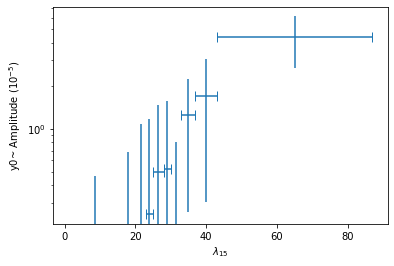

In [517]:
x = []
xerr = []

for i in range(len(perc)-1):
    x.append((perc[i]+perc[i+1])/2)
    xerr.append((perc[i+1]-perc[i])/2)
plt.errorbar(x, np.array(y)*10**5, xerr = xerr, ls = 'none', capsize = 5.0)
plt.errorbar(x, np.array(y)*10**5, yerr = np.array(yerr)*10**5, ls = 'none', c =u'#1f77b4')

plt.yscale('log')
#plt.ylim((-0.1,10))

#yaxis = plt.gca().yaxis
#yaxis.set_minor_locator(MinorSymLogLocator(1e-0))


#plt.title('Weighted Richness vs Stacked Signal Central Bin')
plt.xlabel('$\lambda_{15}$')
plt.ylabel('y0~ Amplitude ($10^{-5}$)')
plt.savefig('./plots/log_rich_bright_radially_bin.pdf')
plt.savefig('./plots/log_rich_bright_radially_bin.png', dpi = 300)
plt.show()

# Jackknife Null Test


3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 506
Number in stack: 506


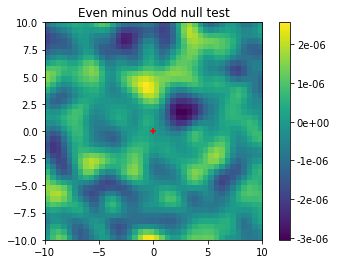

In [49]:
stack_even, stack_num_even = s18dStack(ra[0::2], dec[0::2], s18d)#, weight = True)
stack_odd, stack_num_odd = s18dStack(ra[1::2], dec[1::2], s18d)#, weight = True)

plot = plt.imshow(stack_even-stack_odd, extent = [-10,10,-10,10])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title('Even minus Odd null test')
plt.savefig("even_odd_null_no_weight.png")
plt.show()
plt.close()


# Jackknife Variance


In [10]:
yerr_jk = []
jks = {}

for i in range(bins):
    
    num_jk = 20
    
    jks['{}'.format(i)] = []
    
    cut = np.where((rich>perc[i]) & (rich <= perc[i+1]))[0]
    
    ra_cut = ra[cut]
    dec_cut = dec[cut]
    rich_cut = rich[cut]
    names_cut = names[cut]
    
    chunks = np.array_split(range(len(ra_cut)),num_jk)    

    for j in range(num_jk):
        
        ra_temp = np.delete(ra_cut, chunks[j])
        dec_temp = np.delete(dec_cut, chunks[j])
        rich_temp = np.delete(rich_cut, chunks[j])
        names_temp = np.delete(names_cut, chunks[j])
        
        #print(ra_temp)
        
        stack, stack_num = s18dStack(ra_temp, dec_temp, s18d)#, weight = True)
    
        jks['{}'.format(i)].append(stack)
        #stack_nums.append(stack_num)
        
        print(j)
        
pk.dump(stacks, open( "unweighted_jks.p", "wb" ))


Number in stack: 106
0
Number in stack: 106
1
Number in stack: 106
2
Number in stack: 106
3
Number in stack: 106
4
Number in stack: 106
5
Number in stack: 106
6
Number in stack: 106
7
Number in stack: 106
8
Number in stack: 106
9
Number in stack: 106
10
Number in stack: 106
11
Number in stack: 107
12
Number in stack: 107
13
Number in stack: 107
14
Number in stack: 107
15
Number in stack: 107
16
Number in stack: 107
17
Number in stack: 107
18
Number in stack: 107
19
Number in stack: 101
0
Number in stack: 101
1
Number in stack: 101
2
Number in stack: 101
3
Number in stack: 101
4
Number in stack: 101
5
Number in stack: 101
6
Number in stack: 102
7
Number in stack: 102
8
Number in stack: 102
9
Number in stack: 102
10
Number in stack: 102
11
Number in stack: 102
12
Number in stack: 102
13
Number in stack: 102
14
Number in stack: 102
15
Number in stack: 102
16
Number in stack: 102
17
Number in stack: 102
18
Number in stack: 102
19
Number in stack: 115
0
Number in stack: 115
1
Number in stac

Number in stack: 116
8
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 116
9
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.542

Number in stack: 78
12
Number in stack: 78
13
Number in stack: 78
14
Number in stack: 78
15
Number in stack: 78
16
Number in stack: 78
17
Number in stack: 78
18
Number in stack: 78
19
Number in stack: 84
0
Number in stack: 84
1
Number in stack: 84
2
Number in stack: 84
3
Number in stack: 84
4
Number in stack: 84
5
Number in stack: 84
6
Number in stack: 84
7
Number in stack: 84
8
Number in stack: 85
9
Number in stack: 85
10
Number in stack: 85
11
Number in stack: 85
12
Number in stack: 85
13
Number in stack: 85
14
Number in stack: 85
15
Number in stack: 85
16
Number in stack: 85
17
Number in stack: 85
18
Number in stack: 85
19
Number in stack: 113
0
Number in stack: 113
1
Number in stack: 113
2
Number in stack: 113
3
Number in stack: 113
4
Number in stack: 113
5
Number in stack: 113
6
Number in stack: 113
7
Number in stack: 113
8
Number in stack: 113
9
Number in stack: 113
10
Number in stack: 113
11
Number in stack: 113
12
Number in stack: 113
13
Number in stack: 113
14
Number in stack:

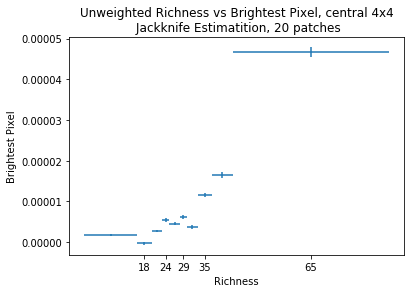

In [12]:
y = []
yerr_jk = []

for i in range(len(stacks)):
    straps = []
    y.append(np.amax(stacks[i][18:22, 18:22]))

    for j in range(len(jks['{}'.format(i)])):
        cur_stack = jks['{}'.format(i)][j]
        straps.append(np.amax(cur_stack[18:22, 18:22]))
    yerr_jk.append(np.sqrt(np.var(straps)))
   

x = []
xerr = []

for i in range(len(perc)-1):
    x.append((perc[i]+perc[i+1])/2)
    xerr.append((perc[i+1]-perc[i])/2)
plt.errorbar(x, y, xerr = xerr, yerr = yerr_jk, ls = 'none')
plt.xticks(x[1::2])
plt.title('Unweighted Richness vs Brightest Pixel, central 4x4\n Jackknife Estimatition, 20 patches')
plt.xlabel('Richness')
plt.ylabel('Brightest Pixel')
plt.savefig('jk_brightrich_unweighted.pdf')
plt.show()

In [57]:
t = QTable.read('/scratch/r/rbond/jorlo/AdvACT2.fits')

ra = t['RADeg']
dec = t['decDeg']
ra, dec = np.array(ra), np.array(dec)

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches.fits')
in_act = act[1].data['Name']

names = t['name']

print(in_act)

for name in in_act:
    if name not in names:
        print(name)

print('space')
for name in names:
    if 'J2321' in name:
        print(name)

['ACT-CL J0221.0+1755' 'ACT-CL J0248.4-0925' 'ACT-CL J1521.1+0451'
 'ACT-CL J1152.3+1652' 'ACT-CL J0023.9-0945' 'ACT-CL J1205.3-0245'
 'ACT-CL J2319.8-1856' 'ACT-CL J0212.2+0746' 'ACT-CL J2326.2+0030'
 'ACT-CL J0105.5+1323' 'ACT-CL J0448.4-1705' 'ACT-CL J1346.2-0142'
 'ACT-CL J2332.6-0014' 'ACT-CL J0125.3-0802' 'ACT-CL J1151.2+1656'
 'ACT-CL J0028.1-1005' 'ACT-CL J0308.1-2915' 'ACT-CL J2231.9+1131'
 'ACT-CL J1454.6+0628' 'ACT-CL J0131.9+0329' 'ACT-CL J0256.5+0006'
 'ACT-CL J0048.4+1757' 'ACT-CL J1455.5+0439' 'ACT-CL J0303.6+1857'
 'ACT-CL J1418.2+0723' 'ACT-CL J1149.4+0921' 'ACT-CL J1208.3+0501'
 'ACT-CL J1014.1+0038' 'ACT-CL J0101.7+0030' 'ACT-CL J2121.8+0040'
 'ACT-CL J1536.5+0954' 'ACT-CL J0300.2+0125' 'ACT-CL J1048.7+0743'
 'ACT-CL J1354.8+1329' 'ACT-CL J1008.7+1147' 'ACT-CL J1205.0+1525'
 'ACT-CL J2235.0+1321' 'ACT-CL J0239.6-1036' 'ACT-CL J0102.6+0201'
 'ACT-CL J0934.4+1751' 'ACT-CL J2316.2+0920' 'ACT-CL J0103.7+0119'
 'ACT-CL J1620.1+1340' 'ACT-CL J1110.2-0030' 'ACT-CL J1139.3+0

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b7db49e0940>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7db49e0da0>]

chararray(['ACT-CL J0019.0-0000', 'ACT-CL J0019.8+0210',
           'ACT-CL J0023.9-0945', 'ACT-CL J0028.1-1005',
           'ACT-CL J0048.4+1757', 'ACT-CL J0101.7+0030',
           'ACT-CL J0102.6+0201', 'ACT-CL J0105.5+1323',
           'ACT-CL J0105.8-1839', 'ACT-CL J0120.7-0305',
           'ACT-CL J0125.3-0802', 'ACT-CL J0129.2-1641',
           'ACT-CL J0131.9+0329', 'ACT-CL J0208.1-0935',
           'ACT-CL J0212.2+0746', 'ACT-CL J0221.0+1755',
           'ACT-CL J0234.5-0107', 'ACT-CL J0239.6-1036',
           'ACT-CL J0248.4-0925', 'ACT-CL J0256.5+0006',
           'ACT-CL J0300.2+0125', 'ACT-CL J0303.6+1857',
           'ACT-CL J0308.1-2915', 'ACT-CL J0353.3+0832',
           'ACT-CL J0448.4-1705', 'ACT-CL J0934.4+1751',
           'ACT-CL J1008.7+1147', 'ACT-CL J1014.1+0038',
           'ACT-CL J1029.9+0016', 'ACT-CL J1048.7+0743',
           'ACT-CL J1053.2+1052', 'ACT-CL J1110.2-0030',
           'ACT-CL J1139.3+0154', 'ACT-CL J1142.1+1345',
           'ACT-CL J1142.7+1527

In [94]:
ras, decs = [5.55130626, 342.205825, 15.7417231], [-0.6048555, -44.528127, -49.267319]

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'
names = []
rms_names = []

rms = fits.open('/scratch/r/rbond/jorlo/S18d_202006/selFn/RMSMap_Arnaud_M2e14_z0p4.fits')
for i in range(len(ras)):
    names.append(tileFinder(ras[i], decs[i],s18d))

for i in range(1,281):
    rms_names.append(str(rms[i].header['EXTNAME']))

test = np.intersect1d(rms_names, names)

for j in range(1,500):
    if rms[j].header['EXTNAME'] == tileName:
        break
print(j)

print(rms_names)

173
['1_0_0', '1_0_1', '1_0_2', '1_0_3', '1_0_4', '1_0_5', '1_0_6', '1_0_7', '1_0_8', '1_0_9', '1_0_10', '1_1_0', '1_1_1', '1_1_2', '1_1_3', '1_1_4', '1_1_5', '1_1_6', '1_1_7', '1_1_8', '1_1_9', '1_1_10', '1_1_11', '1_2_0', '1_2_1', '1_2_2', '1_2_3', '1_2_4', '1_2_5', '1_2_6', '1_2_7', '1_2_8', '1_2_9', '1_2_10', '1_2_11', '1_2_12', '1_2_13', '1_3_0', '1_3_1', '1_3_2', '1_3_3', '1_3_4', '1_3_5', '1_3_6', '1_3_7', '1_3_8', '1_3_9', '1_3_10', '1_3_11', '1_3_12', '1_3_13', '1_3_14', '1_4_0', '1_4_1', '1_4_2', '1_4_3', '1_4_4', '1_4_5', '1_4_6', '1_4_7', '1_4_8', '1_4_9', '1_4_10', '1_4_11', '1_4_12', '1_4_13', '1_4_14', '1_4_15', '1_5_0', '1_5_1', '1_5_2', '1_5_3', '1_5_4', '1_5_5', '1_5_6', '1_5_7', '1_5_8', '1_5_9', '1_5_10', '1_5_11', '1_5_12', '1_5_13', '1_5_14', '1_5_15', '1_5_16', '1_6_0', '1_6_1', '1_6_2', '1_6_3', '1_6_4', '1_6_5', '1_6_6', '1_6_7', '1_6_8', '1_6_9', '1_6_10', '1_6_11', '1_6_12', '1_6_13', '1_6_14', '1_6_15', '1_6_16', '1_7_0', '1_7_1', '1_7_2', '1_7_3', '1_7_4', 

In [6]:
act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches.fits')
print(act[1].data['Act Cluster'])
print(act[1].data['RA(deg) '])

['ACT-CL J0019.0-0000' 'ACT-CL J0019.8+0210' 'ACT-CL J0023.9-0945'
 'ACT-CL J0028.1-1005' 'ACT-CL J0048.4+1757' 'ACT-CL J0101.7+0030'
 'ACT-CL J0102.6+0201' 'ACT-CL J0105.5+1323' 'ACT-CL J0105.8-1839'
 'ACT-CL J0120.7-0305' 'ACT-CL J0125.3-0802' 'ACT-CL J0129.2-1641'
 'ACT-CL J0131.9+0329' 'ACT-CL J0208.1-0935' 'ACT-CL J0212.2+0746'
 'ACT-CL J0221.0+1755' 'ACT-CL J0234.5-0107' 'ACT-CL J0239.6-1036'
 'ACT-CL J0248.4-0925' 'ACT-CL J0256.5+0006' 'ACT-CL J0300.2+0125'
 'ACT-CL J0303.6+1857' 'ACT-CL J0308.1-2915' 'ACT-CL J0353.3+0832'
 'ACT-CL J0448.4-1705' 'ACT-CL J0934.4+1751' 'ACT-CL J1008.7+1147'
 'ACT-CL J1014.1+0038' 'ACT-CL J1029.9+0016' 'ACT-CL J1048.7+0743'
 'ACT-CL J1053.2+1052' 'ACT-CL J1110.2-0030' 'ACT-CL J1139.3+0154'
 'ACT-CL J1142.1+1345' 'ACT-CL J1142.7+1527' 'ACT-CL J1149.4+0921'
 'ACT-CL J1152.3+1652' 'ACT-CL J1205.0+1525' 'ACT-CL J1205.3-0245'
 'ACT-CL J1208.3+0501' 'ACT-CL J1241.0+0010' 'ACT-CL J1310.6+1707'
 'ACT-CL J1322.9-0227' 'ACT-CL J1346.2-0142' 'ACT-CL J1354.8+1

In [7]:
#print(act[1].data['ACT Cluster'])


path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

old_act = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/AdvACT_S18d_202006_MaDCoWSUnionMatch.fits')
old_act_names = old_act[1].data['Name']
old_ra = old_act[1].data['RADeg']
old_dec = old_act[1].data['DecDeg']

new_act_names = act[1].data['ACT Cluster']
new_ra = act[1].data['RA(deg) ']
new_dec = act[1].data['Dec(deg) ']

#print(len(np.intersect1d(old_act_names, new_act_names)))

for i, name in enumerate(new_act_names):
    if name in old_act_names:
        j = np.where((name == old_act_names))[0][0]
        
        
        if old_ra[j] != new_ra[i] or old_dec[j] != new_dec[i]:
            print(name)
            print(old_act_names[j], name)
            print(old_ra[j], new_ra[i])
            print(old_dec[j], new_dec[i])

ACT-CL J0103.7+0119
ACT-CL J0103.7+0119 ACT-CL J0103.7+0119
15.943230916521406 15.944446392557753
1.3209028145963373 1.3206711601115724
ACT-CL J1254.9+0947
ACT-CL J1254.9+0947 ACT-CL J1254.9+0947
193.72920799748317 193.7305642181257
9.799999999999962 9.797274565063228
ACT-CL J2332.7-3813
ACT-CL J2332.7-3813 ACT-CL J2332.7-3813
353.1860675078451 353.1840953309555
-38.228400320118816 -38.22818780624654
ACT-CL J2140.5+0248
ACT-CL J2140.5+0248 ACT-CL J2140.5+0248
325.1451577418461 325.1451687967746
2.801920450943174 2.8019992080160576


In [31]:
#for i in range(len(new_ra)):
#    test = s18dStamp(new_ra[i], new_dec[i], s18d, 'test', write = False)
#    if test is None:
#        print(i)

print('New stack')
stack, numstack = s18dStack(new_ra, new_dec, s18d, weight = True)
print('Old stack')
stack, numstack = s18dStack(old_ra, old_dec, s18d, weight = True)

New stack
33
Number in stack: 92
Old stack
3
Number in stack: 95


In [248]:
catalog = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches_V03.fits')

ra_mdcw = catalog[1].data['MaDCoWS RA(deg)']
dec_mdcw = catalog[1].data['MaDCoWS Dec(deg)']
ra_mdcw, dec_mdcw = np.array(ra_mdcw), np.array(dec_mdcw)

ra_act = catalog[1].data['ACT RA(deg)']
names_act = catalog[1].data['ACT Cluster']
dec_act = catalog[1].data['ACT Dec(deg)']
ra_act, dec_act = np.array(ra_act), np.array(dec_act)


In [253]:
for i in range(len(ra_act)):
    print((ra_act[i]-ra_mdcw[i])*3600, (dec_act[i]-dec_mdcw[i])*3600)
    #print(ra_act[i], ra_mdcw[i])
print('\n')

test = offsetSim(ra_act, dec_act, num = 1, normalize = True, testrun = True )



50.72909444785054 -56.81026811996929
20.6005514855363 8.395876904832988
-33.33896810286525 -25.004642667262544
25.729191821322317 11.782551153444132
-65.36102201552154 2.6449083042379584
18.754944703906062 -31.563307287819732
-15.720746340087999 -7.974320628882126
4.624136885585983 -10.693426444944265
27.943492124441605 -40.15595081939409
48.972239431830644 -40.22682391841563
-2.9844085402899623 5.529715917904809
-0.8446756744802997 -23.838951311877565
-40.951107968236045 -15.916612064949476
41.99999999952695 33.93096340480639
-103.38208660159012 10.533997694282249
19.499999999470674 -38.239692387639934
21.91655228664331 -37.6217253926562
-25.27401025412246 -40.08378986689749
17.9999999993953 9.495550396069774
-13.43322398453779 3.5583970895401773
28.979874588756616 10.427593150748482
3.6019487893327096 -4.02800157946217
21.095062032952683 -30.129912657334046
-13.315852006186901 12.41949604943855
-27.25355685175259 -6.19568937805326
14.903736861776906 2.8637097885734875
17.021208493667

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [266]:
w =25.0

ra_temp = ra_act + w/3600*np.random.normal(size = len(ra_act))
dec_temp = dec_act + w/3600*np.random.normal(size = len(ra_act))

for i in range(len(ra_act)):
    print((ra_act[i]-ra_temp[i])*3600, (dec_act[i]-dec_temp[i])*3600)

16.843144091484774 -21.158009498524255
-12.173628837571826 6.838489924923863
-11.172142740556623 -6.956163169486729
-8.612609307177976 -22.30547758900059
27.80434207248703 23.383232973854717
35.194203936499235 11.207368663736418
-33.64310551741738 -5.762014110106861
-2.159502936650881 30.35622117807648
16.675084703520326 42.93098408874556
-12.173783374802838 -33.2825400037855
-16.327139426859105 -18.21039773102271
-41.55419325461196 21.338786559989842
35.92266521335432 17.59964892500392
16.866782086160015 -19.482077754016558
-17.22741661634757 -15.390060484330448
-6.249741337902037 -17.360237881437968
-46.77074027812864 -21.088309084827994
7.033477793245879 33.775158457424226
31.326335745563938 -10.060166999927844
23.380860778831902 -38.710534315225715
-8.664294304071518 -8.85423328007331
-29.27465355522827 22.03016007701848
41.09917521592763 31.695687486615043
-0.8820197860529788 -23.09880601880394
14.662482214055217 12.837259932746292
-10.423728524403941 24.939604642491986
-14.267682